In [1]:
## Loading functions
import os
os.chdir("/data/biocomp/bahin/qPCR/qPCRquantification/")
#os.chdir("/users/biocomp/bahin/Mounted_dir/data_bioclust/qPCR/qPCRquantification")
import HiFit_pd
from HiFit_pd import *
import methods_comparison
from methods_comparison import *
import qPCR_functions
from qPCR_functions import *

In [ ]:
import importlib
importlib.reload(HiFit_pd)

In [2]:
cycles_col = ["F" + str(i).zfill(2) for i in range(40)]
cycles_col_noBL = ["F" + str(i).zfill(2) + "_noBL" for i in range(40)]
cycles_col_norm = ["F" + str(i).zfill(2) + "_norm" for i in range(40)]
cycles_col_mod = ["F" + str(i).zfill(2) + "_mod" for i in range(40)]
cycles_col_mod_Gwb = ["F" + str(i).zfill(2) + "_mod_Gompertz_with_bump" for i in range(40)]
cycles_col_mod_GwbfE = ["F" + str(i).zfill(2) + "_mod_fixed_E_Gompertz_with_bump" for i in range(40)]
cycles_col_log = ["F" + str(i).zfill(2) + "_log" for i in range(40)]
corr_cycles_col = ["F" + str(i).zfill(2) + "_corr" for i in range(40)]
cycles_col_bump_corr = ["F" + str(i).zfill(2) + "_bump_corr" for i in range(40)]
log_corr_cycles_col = ["F" + str(i).zfill(2) + "_log_corr" for i in range(40)]

In [13]:
## Getting data (with modelled fluo values + theoretical N0)
import pandas as pd

# Loading data
dir = "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/"
data = pd.read_csv(dir + "final_data.Gompertz_with_bump.REF.tsv", sep="\t", index_col=0)

display(data[["Theoretical_N0", "F00_mod_Gompertz_with_bump"]].head(2))

FileNotFoundError: [Errno 2] File /data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/final_data.Gompertz_with_bump.REF.tsv does not exist: '/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/final_data.Gompertz_with_bump.REF.tsv'

In [3]:
## Creating HiFit colormap
import matplotlib
from matplotlib.colors import LinearSegmentedColormap

tab20 = matplotlib.cm.get_cmap("tab20")
HiFit_colormap = tab20.colors[::2] + tab20.colors[1::2]
random_colormap = LinearSegmentedColormap.from_list("HiFit_colormap", HiFit_colormap, N=20)
matplotlib.cm.register_cmap("HiFit_colormap", random_colormap)

In [204]:
def modelled_fluo(row, equation):
    ''' Computing the 40 fluo values using chosen parameters for the equation. '''
    params = ["P_" + letter + "_final_" + equation.__name__ for letter in list(string.ascii_lowercase)[0:equation.__code__.co_argcount - 1]]
    args = row[params].values.tolist()
    args[0:2] = [0, args[1] - args[0]]  # With min subtracted to min and max
    #args[0:2] = [0, 1]  # With min and max to 0 and 1
    return equation(np.arange(40), *args)

# Setting parameters
equation = Gompertz_with_bump
cycles_name = ["F" + str(i).zfill(2) + "_mod_full_" + equation.__name__ for i in range(40)]
genes = ["BMP4", "Bactine2", "Crabp2a", "Cyp26a1", "Delta C", "DeltaD", "FGF8a", "Her7", "Hoxa1a", "Hoxa5a", "Hoxb1b", "Hoxd4a", "Notch1A", "RPL13a1", "RPL13a2", "Rarab"]
#genes = ["BMP4", "Cyp26a1", "Delta C", "DeltaD", "Her7", "Hoxa1a", "Hoxb1b", "Hoxd4a", "RPL13a1", "RPL13a2"]

dataset = data.loc[(data["Pre_amplification"] == 0) & (data["S_or_C"] == "PS") & (data["Sigmoid_curve"]) & data["Gene"].isin(genes)]
#dataset = data.loc[(data["Pre_amplification"] == 0) & (data["S_or_C"] == "PS") & (data["Sigmoid_curve"]) & (data["Gene"] == "Her7")]
dataset[cycles_name] = dataset.apply(lambda row: modelled_fluo(row, equation), axis=1, result_type="expand")
dataset = dataset.sort_values(by=["Gene", "Condition"])
dataset.to_csv("/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/tmp.tsv", sep="\t")
dataset["F00_mod_full_Gompertz_with_bump_log"] = np.log(dataset["F00_mod_full_Gompertz_with_bump"])

/users/biocomp/bahin/miniconda3/envs/Env_conda_qPCR/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


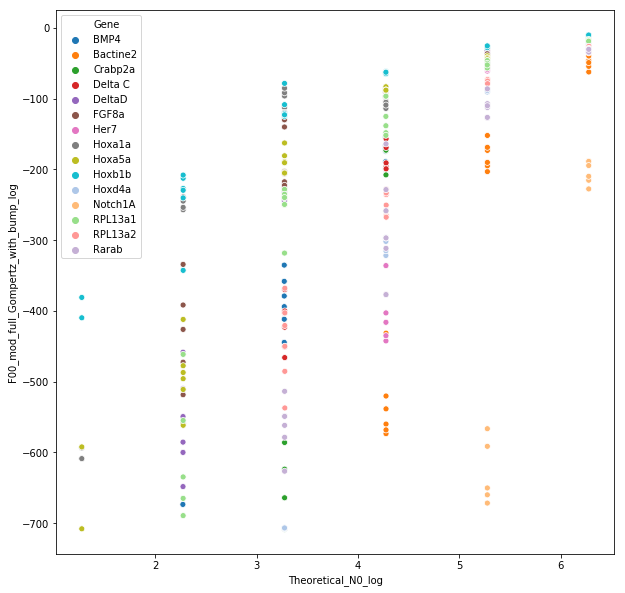

In [207]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x="Theoretical_N0_log", y="F00_mod_full_Gompertz_with_bump_log", hue="Gene", palette=HiFit_colormap, data=dataset)

(546, 149)


/users/biocomp/bahin/miniconda3/envs/Env_conda_qPCR/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


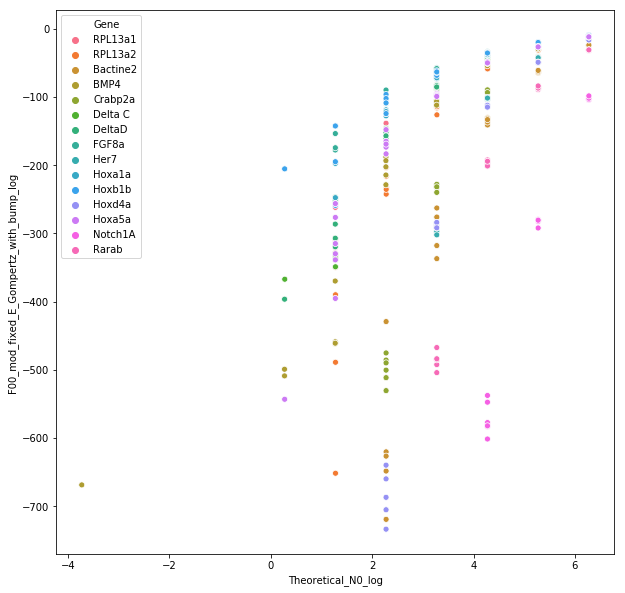

In [32]:
## Displaying N0 versus F0 from modelled curves
import seaborn as sns

data_not_preamp = data.loc[(data["Pre_amplification"] == 0) & (data["Sigmoid_curve"]) & (data["S_or_C"] == "PS")]
#data_not_preamp = data.loc[(data["Pre_amplification"] == 0) & (data["Sigmoid_curve"]) & (data["S_or_C"] == "PS") & ((data["Gene"] == "RPL13a1") | (data["Gene"] == "RPL13a2"))]
#data_not_preamp = data.loc[(data["Pre_amplification"] == 0) & (data["Sigmoid_curve"]) & (data["S_or_C"] == "PS") & (data["Gene"] == "Her7")]
print(data_not_preamp.shape)
val = "F00_mod_fixed_E_Gompertz_with_bump"
#val = "F00_mod_Gompertz_with_bump"
data_not_preamp.loc[:, val + "_log"] = np.log(data_not_preamp[val])
data_not_preamp.to_csv(dir + "tmp.tsv", sep="\t")

plt.figure(figsize=(10, 10))
#ax = sns.scatterplot(x="Theoretical_N0_log", y="F00_mod_Gompertz_with_bump_log", hue="Gene", data=data_not_preamp)
ax = sns.scatterplot(x="Theoretical_N0_log", y=val + "_log", hue="Gene", data=data_not_preamp)
#plt.ylim(-1e-7, 2e-6)
#plt.xlim(0, 500000000)

0.0005706099950165996


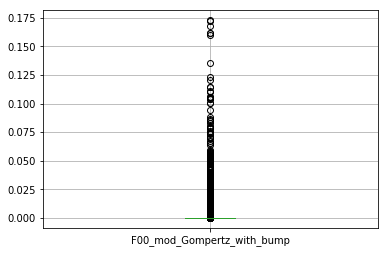

In [8]:
## Checking the distribution of a value (one column)

# Loading data
dir = "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/"
data = pd.read_csv(dir + "final_data.Gompertz_with_bump.REF.tsv", sep="\t", index_col=0)

pd.DataFrame(data.loc[data["Sigmoid_curve"], "F00_mod_Gompertz_with_bump"]).boxplot()
print(data.loc[data["Sigmoid_curve"], "RSS_Gompertz_with_bump"].mean())

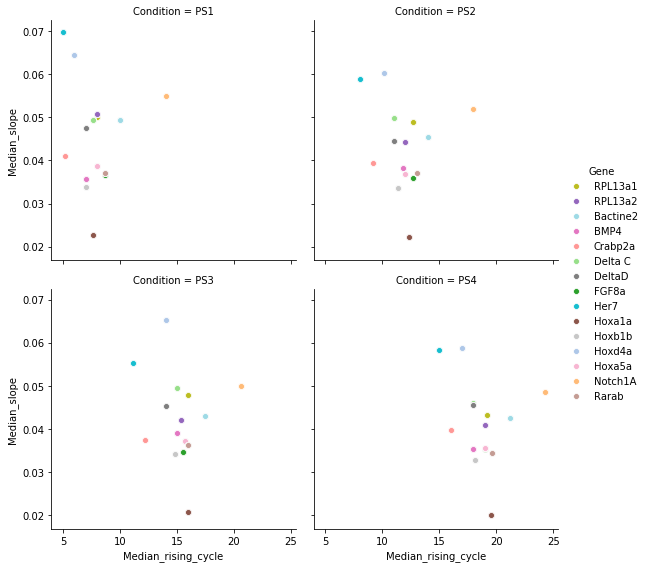

In [431]:
## Plotting the rising cycle against the efficacy for genes that had the same N0
import numpy as np
from sklearn.linear_model import LinearRegression

def get_slope(row):
    start_cycle = row["Rising_cycle"]
    x = np.array(range(start_cycle + 1, start_cycle + 6)).reshape(-1, 1)
    cycles = ["F" + str(c).zfill(2) for c in range(start_cycle + 1, start_cycle + 6)]
    #cycles = ["F" + str(c).zfill(2) + "_mod_Gompertz_with_bump" for c in range(start_cycle + 1, start_cycle + 6)]
    reg = LinearRegression().fit(x, row[cycles])
    return row.WellID, row.Gene, reg.coef_[0]

# Selecting the curves
#conditions = ["PS1"]
conditions = ["PS1", "PS2", "PS3", "PS4"]
genes = ["Hoxa1a", "Hoxb1b", "Hoxd4a", "Hoxa5a"]
#dataset = data.loc[(data["Condition"].isin(conditions)) & (data["Sigmoid_curve"] == True) & (data["Gene"].isin(genes))]
dataset = data.loc[(data["Condition"].isin(conditions)) & (data["Sigmoid_curve"] == True)]

# Computing the curves slope and adding the info
df = dataset.apply(get_slope, axis=1, result_type="expand")
df.columns = ["WellID", "Gene", "Slope"]
#display(df)
dataset = pd.merge(dataset, df, on=["WellID", "Gene"])
#display(dataset[["Gene", "Rising_cycle", "Slope"]])

# Adding the median rising cycle and slope
dataset = dataset.merge(dataset[["Gene", "Condition", "Rising_cycle", "Slope"]].groupby(["Gene", "Condition"]).mean(), on=["Gene", "Condition"])
dataset.rename(columns={"Rising_cycle_x": "Rising_cycle", "Rising_cycle_y": "Median_rising_cycle",
                        "Slope_x": "Slope", "Slope_y": "Median_slope"}, inplace=True)
#display(dataset[["Gene", "Condition", "Median_rising_cycle", "Median_slope"]].drop_duplicates())

# Plotting
#sns.scatterplot(x="Rising_cycle", y="Slope", hue="Gene", data=dataset)
g = sns.FacetGrid(dataset, col="Condition", hue="Gene", col_wrap=2, height=4)
g = (g.map_dataframe(sns.scatterplot, "Median_rising_cycle", "Median_slope", units="WellID", estimator=None).add_legend())
#g = (g.map_dataframe(sns.scatterplot, "Rising_cycle", "Slope", units="WellID", estimator=None).add_legend())

In [411]:
# Defining the colormap

#tab20 = cm.get_cmap("tab20")
#print(tab20.colors)
#print(tuple(random.sample(tab20.colors, len(tab20.colors))))
#sns.set_palette((((0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (1.0, 0.4980392156862745, 0.054901960784313725), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), (0.5803921568627451, 0.403921568627451, 0.7411764705882353))))
sns.set_palette(tuple(random.sample(tab20.colors, len(tab20.colors))))

In [439]:
# Defining the colormap

tab20 = cm.get_cmap("tab20")
print(tab20.colors)
print(tuple(random.sample(tab20.colors, len(tab20.colors))))

((0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.6823529411764706, 0.7803921568627451, 0.9098039215686274), (1.0, 0.4980392156862745, 0.054901960784313725), (1.0, 0.7333333333333333, 0.47058823529411764), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), (0.596078431372549, 0.8745098039215686, 0.5411764705882353), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), (1.0, 0.596078431372549, 0.5882352941176471), (0.5803921568627451, 0.403921568627451, 0.7411764705882353), (0.7725490196078432, 0.6901960784313725, 0.8352941176470589), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354), (0.7686274509803922, 0.611764705882353, 0.5803921568627451), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902), (0.9686274509803922, 0.7137254901960784, 0.8235294117647058), (0.4980392156862745, 0.4980392156862745, 0.4980392156862745), (0.7803921568627451, 0.7803921568627451, 0.7803921568627451), (0.7372549019607844, 0.7411764705882353, 0.1333

(0, 40)

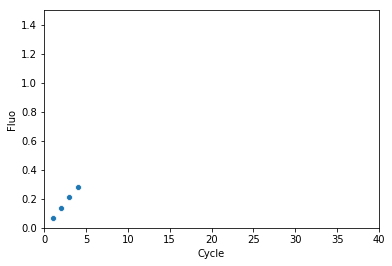

In [73]:
## Checking a linear regression trend
df = pd.DataFrame(np.array([1, 2, 3, 4]), columns=["Cycle"])
df["Fluo"] = df["Cycle"] * 0.07
sns.scatterplot(x="Cycle", y="Fluo", data=df)
plt.ylim(0, 1.5)
plt.xlim(0, 40)

PS1           PC1           F00           F01  \
RPL13a1   6.961704e+08  2.784681e+09  6.961704e+08  1.253107e+09   
RPL13a2   7.009786e+08  2.803915e+09  7.009786e+08  1.261762e+09   
Bactine2  6.982229e+08  9.775121e+09  6.982229e+08  1.256801e+09   
BMP4      6.921012e+08  1.384202e+07  6.921012e+08  1.245782e+09   
Crabp2a   6.973662e+08  8.089448e+08  6.973662e+08  1.255259e+09   

                   F02           F03           F04           F05  \
RPL13a1   2.255592e+09  4.060065e+09  7.308118e+09  1.315461e+10   
RPL13a2   2.271171e+09  4.088107e+09  7.358593e+09  1.324547e+10   
Bactine2  2.262242e+09  4.072036e+09  7.329665e+09  1.319340e+10   
BMP4      2.242408e+09  4.036334e+09  7.265401e+09  1.307772e+10   
Crabp2a   2.259467e+09  4.067040e+09  7.320672e+09  1.317721e+10   

                   F06           F07  ...           F31           F32  \
RPL13a1   2.367830e+10  4.262094e+10  ...  5.703785e+16  1.026681e+17   
RPL13a2   2.384184e+10  4.291532e+10  ...  5.743180e+16  1.033772e+17   
Bactine2  2.374812e+10  4.274661e+10  ...  5.720603e+16  1.029708e+17   
BMP4      2.353990e+10  4.237182e+10  ...  5.670446e+16  1.020680e+17   
Crabp2a   2.371898e+10  4.269416e+10  ...  5.713583e+16  1.028445e+17   

                   F33           F34           F35           F36  \
RPL13a1   1.848026e+17  3.326448e+17  5.987606e+17  1.077769e+18   
RPL13a2   1.860790e+17  3.349423e+17  6.028961e+17  1.085213e+18   
Bactine2  1.853475e+17  3.336255e+17  6.005260e+17  1.080947e+18   
BMP4      1.837225e+17  3.307004e+17  5.952608e+17  1.071469e+18   
Crabp2a   1.851201e+17  3.332162e+17  5.997891e+17  1.079620e+18   

                   F37           F38           F39      Gene  
RPL13a1   1.939984e+18  3.491972e+18  6.285549e+18   RPL13a1  
RPL13a2   1.953383e+18  3.516090e+18  6.328962e+18   RPL13a2  
Bactine2  1.945704e+18  3.502267e+18  6.304081e+18  Bactine2  
BMP4      1.928645e+18  3.471561e+18  6.248809e+18      BMP4  
Crabp2a   1.943317e+18  3.497970e+18  6.296346e+18   Crabp2a  

[5 rows x 43 columns]

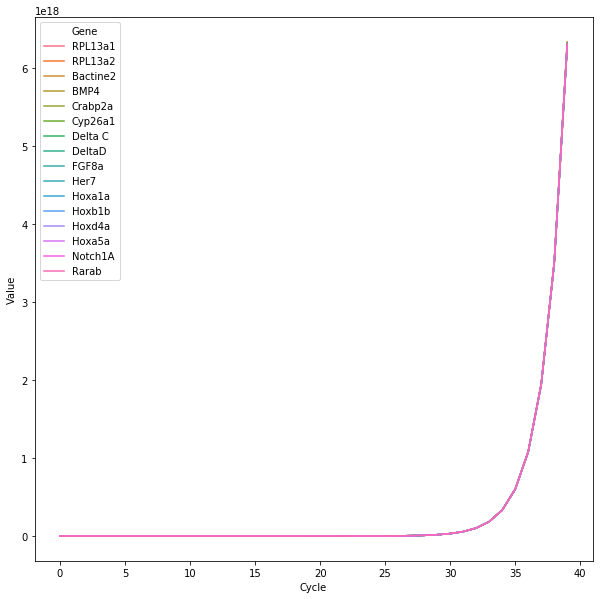

In [46]:
## Displaying the theoretical curves with known N0 and an equal efficiency of 1.8

N0_file = "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/PS1_PC1_N0.tsv"
molecules = pd.read_csv(N0_file, sep="\t", header=0, index_col=0)
E = 1.8
#display(molecules)

molecules = molecules.transpose()
#display(molecules.head(2))
for c in cycles_col:
    molecules[c] = molecules.apply(lambda row: row["PS1"] * E**int(c[1:3]), axis=1)
molecules["Gene"] = molecules.index
display(molecules.head(5))

df = pd.melt(molecules, id_vars="Gene", value_vars=cycles_col, var_name="Cycle", value_name="Value")
df["Cycle"] = df.apply(lambda row: int(row["Cycle"][1:3]), axis=1)
#display(df.head(2))

plt.figure(figsize=(10, 10))
#plt.xlim(36, 37)
#plt.ylim(1.2e18, 1.6e18)
sns.lineplot(x="Cycle", y="Value", hue="Gene", data=df)

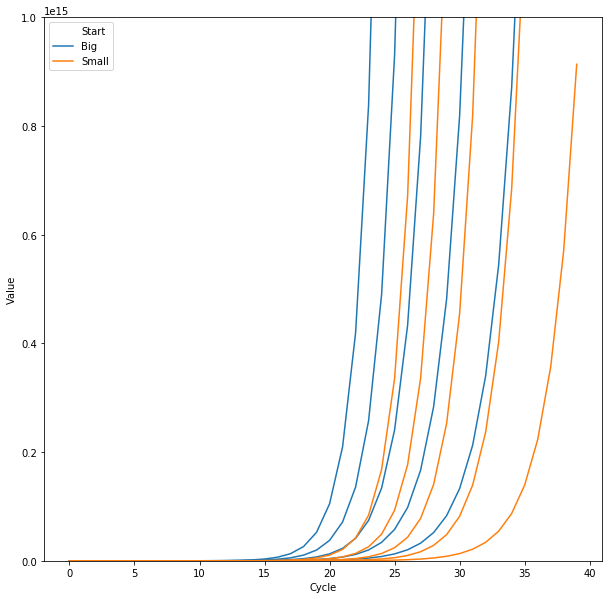

In [93]:
## Displaying the theoretical curves with equal N0 and different efficiences
# Creating the DataFrame with N0 and efficiency
molecules = pd.DataFrame(np.array([["Eff1.6", "Big", 1e8, 1.6], ["Eff1.7", "Big", 1e8, 1.7], ["Eff1.8", "Big", 1e8, 1.8],
                                   ["Eff1.9", "Big", 1e8, 1.9], ["Eff2.0", "Big", 1e8, 2.0],
                                   ["Eff1.6", "Small", 1e7, 1.6], ["Eff1.7", "Small", 1e7, 1.7], ["Eff1.8", "Small", 1e7, 1.8],
                                   ["Eff1.9", "Small", 1e7, 1.9], ["Eff2.0", "Small", 1e7, 2.0]]), columns=["Sample", "Start", "N0", "eff"])
#display(molecules)

# Creating the 40 cycle values
for c in cycles_col:
    molecules[c] = molecules.apply(lambda row: float(row["N0"]) * float(row["eff"])**int(c[1:3]), axis=1)
#display(molecules.head(5))

df = pd.melt(molecules, id_vars=["Sample", "Start"], value_vars=cycles_col, var_name="Cycle", value_name="Value")
df["Cycle"] = df.apply(lambda row: int(row["Cycle"][1:3]), axis=1)
#display(df.head(2))

plt.figure(figsize=(10, 10))
#plt.xlim(36, 37)
#plt.ylim(1.2e18, 1.6e18)
plt.ylim(0, 1e15)
sns.lineplot(x="Cycle", y="Value", hue="Start", units="Sample", estimator=None, data=df)

WellID  E00       E13       E14       E15       E16       E17
14  S01-A01  NaN  0.093668  0.084620  0.072449  0.063574  0.053449
26  S01-A02  NaN  0.105588  0.092659  0.072069  0.068341  0.056336

WellID Cycle  Efficiency
0  S01-A01    13    0.093668
1  S01-A02    13    0.105588
2  S01-A03    13    0.105512
3  S01-A04    13    0.105378
4  S01-A05    13    0.100691

WellID Cycle      Fluo  Efficiency
0  S01-A01    13  0.628319    0.093668
1  S01-A02    13  0.637648    0.105588

Fluo                                         Efficiency  \
Cycle          13        14        15        16        17         13   
WellID                                                                 
S01-A01  0.628319  0.681488  0.730860  0.777324  0.818871   0.093668   
S01-A02  0.637648  0.696732  0.746945  0.797991  0.842947   0.105588   
S01-A03  0.659365  0.714473  0.770864  0.823756  0.867983   0.105512   
S01-A04  0.640428  0.698248  0.753031  0.806337  0.854376   0.105378   
S01-A05  0.639086  0.701608  0.756307  0.811092  0.856704   0.100691   
S01-A06  0.609130  0.668904  0.724006  0.774302  0.819677   0.105104   

                                                 
Cycle          14        15        16        17  
WellID                                           
S01-A01  0.084620  0.072449  0.063574  0.053449  
S01-A02  0.092659  0.072069  0.068341  0.056336  
S01-A03  0.083577  0.078927  0.068614  0.053689  
S01-A04  0.090284  0.078457  0.070789  0.059576  
S01-A05  0.097830  0.077963  0.072437  0.056235  
S01-A06  0.098130  0.082377  0.069469  0.058602

Fluo          
Cycle          13        14
WellID                     
S01-A01  0.628319  0.681488
S01-A02  0.637648  0.696732
S01-A03  0.659365  0.714473
S01-A04  0.640428  0.698248
S01-A05  0.639086  0.701608
S01-A06  0.609130  0.668904

      Cycle
Fluo  13       0.628319
      14       0.681488
Name: S01-A01, dtype: float64

            Cycle
Efficiency  13       0.093668
            14       0.084620
Name: S01-A01, dtype: float64

Fluo                                         Efficiency  \
Cycle          13        14        15        16        17         13   
WellID                                                                 
S01-A01  0.628319  0.681488  0.730860  0.777324  0.818871   0.093668   
S01-A02  0.637648  0.696732  0.746945  0.797991  0.842947   0.105588   
S01-A03  0.659365  0.714473  0.770864  0.823756  0.867983   0.105512   
S01-A04  0.640428  0.698248  0.753031  0.806337  0.854376   0.105378   
S01-A05  0.639086  0.701608  0.756307  0.811092  0.856704   0.100691   

                                                     Fmax  
Cycle          14        15        16        17            
WellID                                                     
S01-A01  0.084620  0.072449  0.063574  0.053449 -0.206466  
S01-A02  0.092659  0.072069  0.068341  0.056336 -0.304113  
S01-A03  0.083577  0.078927  0.068614  0.053689 -0.237832  
S01-A04  0.090284  0.078457  0.070789  0.059576 -0.239274  
S01-A05  0.097830  0.077963  0.072437  0.056235 -0.190384

(0, 1)

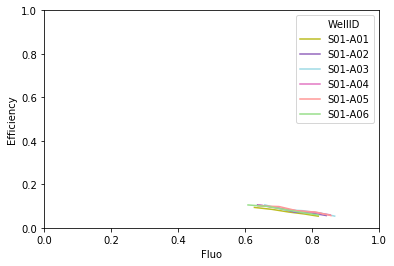

In [625]:
## Plotting Ec vs. Fc (LRE)
dataset = data.loc[(data["Gene"] == "RPL13a1") & (data["Condition"] == "PS1")]

ccols = ["F00", "F01", "F02", "F03"]
ccols = cycles_col
ccols = ["F" + str(i).zfill(2) for i in range(13, 18)]
nccols = ["E00", "E01", "E02", "E03"]
nccols = ["E" + str(i).zfill(2) for i in range(13, 18)]

df2 = pd.DataFrame()
df2["WellID"] = dataset["WellID"]
df2["E00"] = np.nan
for i in range(13, 18):
    df2["E" + str(i).zfill(2)] = dataset["F" + str(i).zfill(2)] / dataset["F" + str(i - 1).zfill(2)] - 1
display(df2.head(2))

dataset = pd.melt(dataset, id_vars=["WellID"], value_vars=ccols, var_name="Cycle", value_name="Fluo")
dataset["Cycle"] = dataset.apply(lambda row: row["Cycle"][1:3], axis=1)
#display(dataset.head())
df2 = pd.melt(df2, id_vars=["WellID"], value_vars=nccols, var_name="Cycle", value_name="Efficiency")
df2["Cycle"] = df2.apply(lambda row: row["Cycle"][1:3], axis=1)
display(df2.head())

df3 = dataset.merge(df2)
display(df3.head(2))

df4 = df3.pivot(index="WellID", columns="Cycle")
display(df4)
display(df4.loc[:, (df4.columns.get_level_values(1).isin(["13", "14"])) & (df4.columns.get_level_values(0) == "Fluo")])
display(df4.iloc[0][(df4.columns.get_level_values(1).isin(["13", "14"])) & (df4.columns.get_level_values(0) == "Fluo")])
display(df4.iloc[0][(df4.columns.get_level_values(1).isin(["13", "14"])) & (df4.columns.get_level_values(0) == "Efficiency")])
#df4["Fmax"] = df4.apply(lambda row: LinearRegression().fit(row[("Fluo", [13, 14, 15, 16, 17])], row[("Efficiency", [13, 14, 15, 16, 17])]).coef_[0], axis=1)
df4["deltaE"] = df4.apply(lambda row: LinearRegression().fit(np.array(row.loc[(df4.columns.get_level_values(1).isin(["13", "14", "15"])) & (df4.columns.get_level_values(0) == "Fluo")]).reshape(-1, 1),
                        row.loc[(df4.columns.get_level_values(1).isin(["13", "14", "15"])) & (df4.columns.get_level_values(0) == "Efficiency")]).coef_[0], axis=1)
#df4["Fmax"] = df4.apply(lambda row: row[("Fluo", 13)], axis=1)
display(df4.head())

sns.lineplot(x="Fluo", y="Efficiency", hue="WellID", data=df3)
plt.xlim(0, 1)
plt.ylim(0, 1)

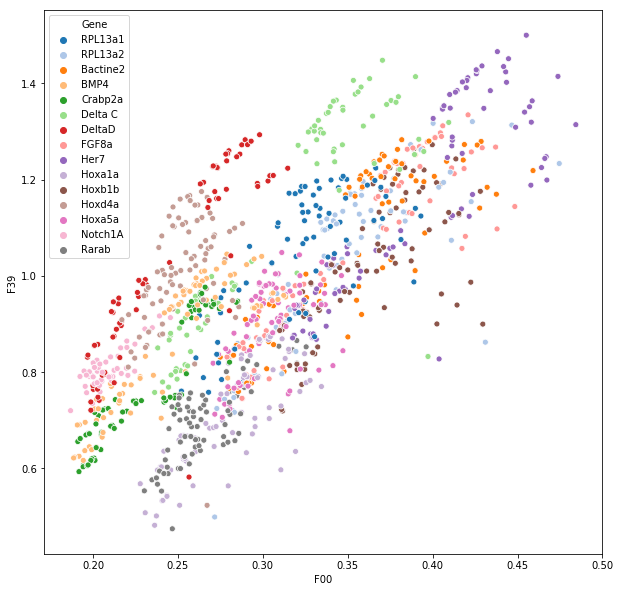

In [28]:
## Plotting F0 vs F39
dataset = data.loc[(data["Pre_amplification"] == 0) & (data["Sigmoid_curve"])]
plt.figure(figsize=(10, 10))
sns.scatterplot(x="F00", y="F39", palette="tab20", hue="Gene", data=dataset)

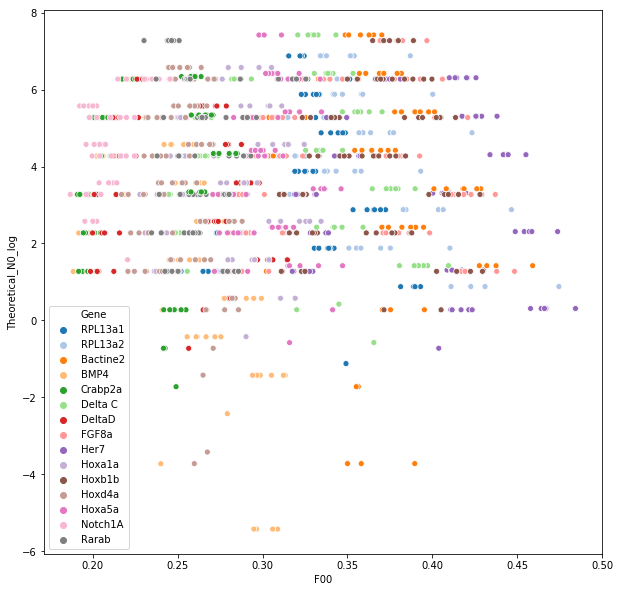

In [32]:
## Plotting F0 (raw) vs N0
dataset = data.loc[(data["Pre_amplification"] == 0) & (data["Sigmoid_curve"])]
plt.figure(figsize=(10, 10))
sns.scatterplot(x="F00", y="Theoretical_N0_log", palette="tab20", hue="Gene", data=dataset)

WellID Condition     Gene  Fluidigm_Ct  Sample  Assay       F00       F01  \
0  S01-A01       PS1  RPL13a1     8.491106       1      1  0.370476  0.375293   
1  S01-A02       PS1  RPL13a1     8.375671       1      2  0.351437  0.359487   

        F02       F03  ...  F32_mod_fixed_E_Gompertz_with_bump  \
0  0.379359  0.384355  ...                            0.967959   
1  0.363358  0.368100  ...                            0.968269   

   F33_mod_fixed_E_Gompertz_with_bump  F34_mod_fixed_E_Gompertz_with_bump  \
0                            0.973307                            0.977772   
1                            0.973566                            0.977988   

   F35_mod_fixed_E_Gompertz_with_bump  F36_mod_fixed_E_Gompertz_with_bump  \
0                            0.981497                            0.984603   
1                            0.981678                            0.984754   

   F37_mod_fixed_E_Gompertz_with_bump  F38_mod_fixed_E_Gompertz_with_bump  \
0                            0.987191                            0.989347   
1                            0.987317                            0.989451   

   F39_mod_fixed_E_Gompertz_with_bump  Theoretical_N0  Theoretical_N0_log  
0                            0.991141    1.879660e+06            6.274079  
1                            0.991228    1.879660e+06            6.274079  

[2 rows x 150 columns]

(546, 150)


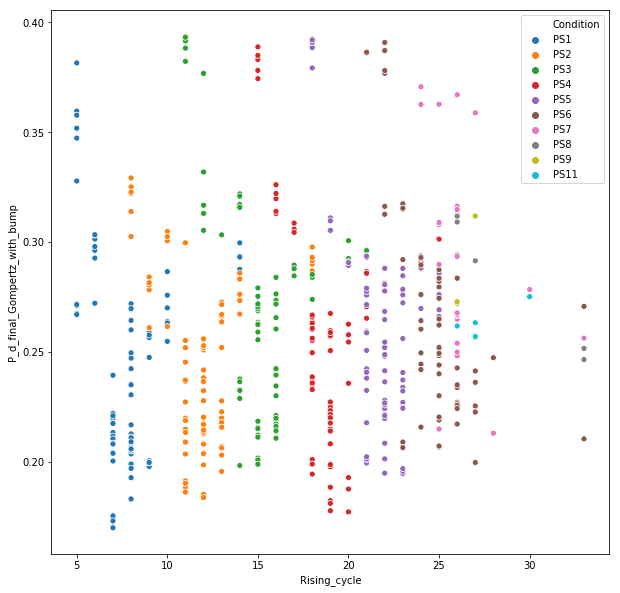

In [46]:
## Plotting E (Gompertz with bump fitted) against the rising cycle

#dataset = data.loc[(data.Gene == "RPL13a1") & data.Sigmoid_curve]
dataset = data.loc[(data.Sigmoid_curve) & (data.Pre_amplification == 0) & (data.S_or_C == "PS")]
display(dataset.head(2))
print(dataset.shape)
plt.figure(figsize=(10, 10))
sns.scatterplot(x="Rising_cycle", y="P_d_final_Gompertz_with_bump", hue="Condition", palette=HiFit_colormap, data=dataset)

<Figure size 720x720 with 0 Axes>

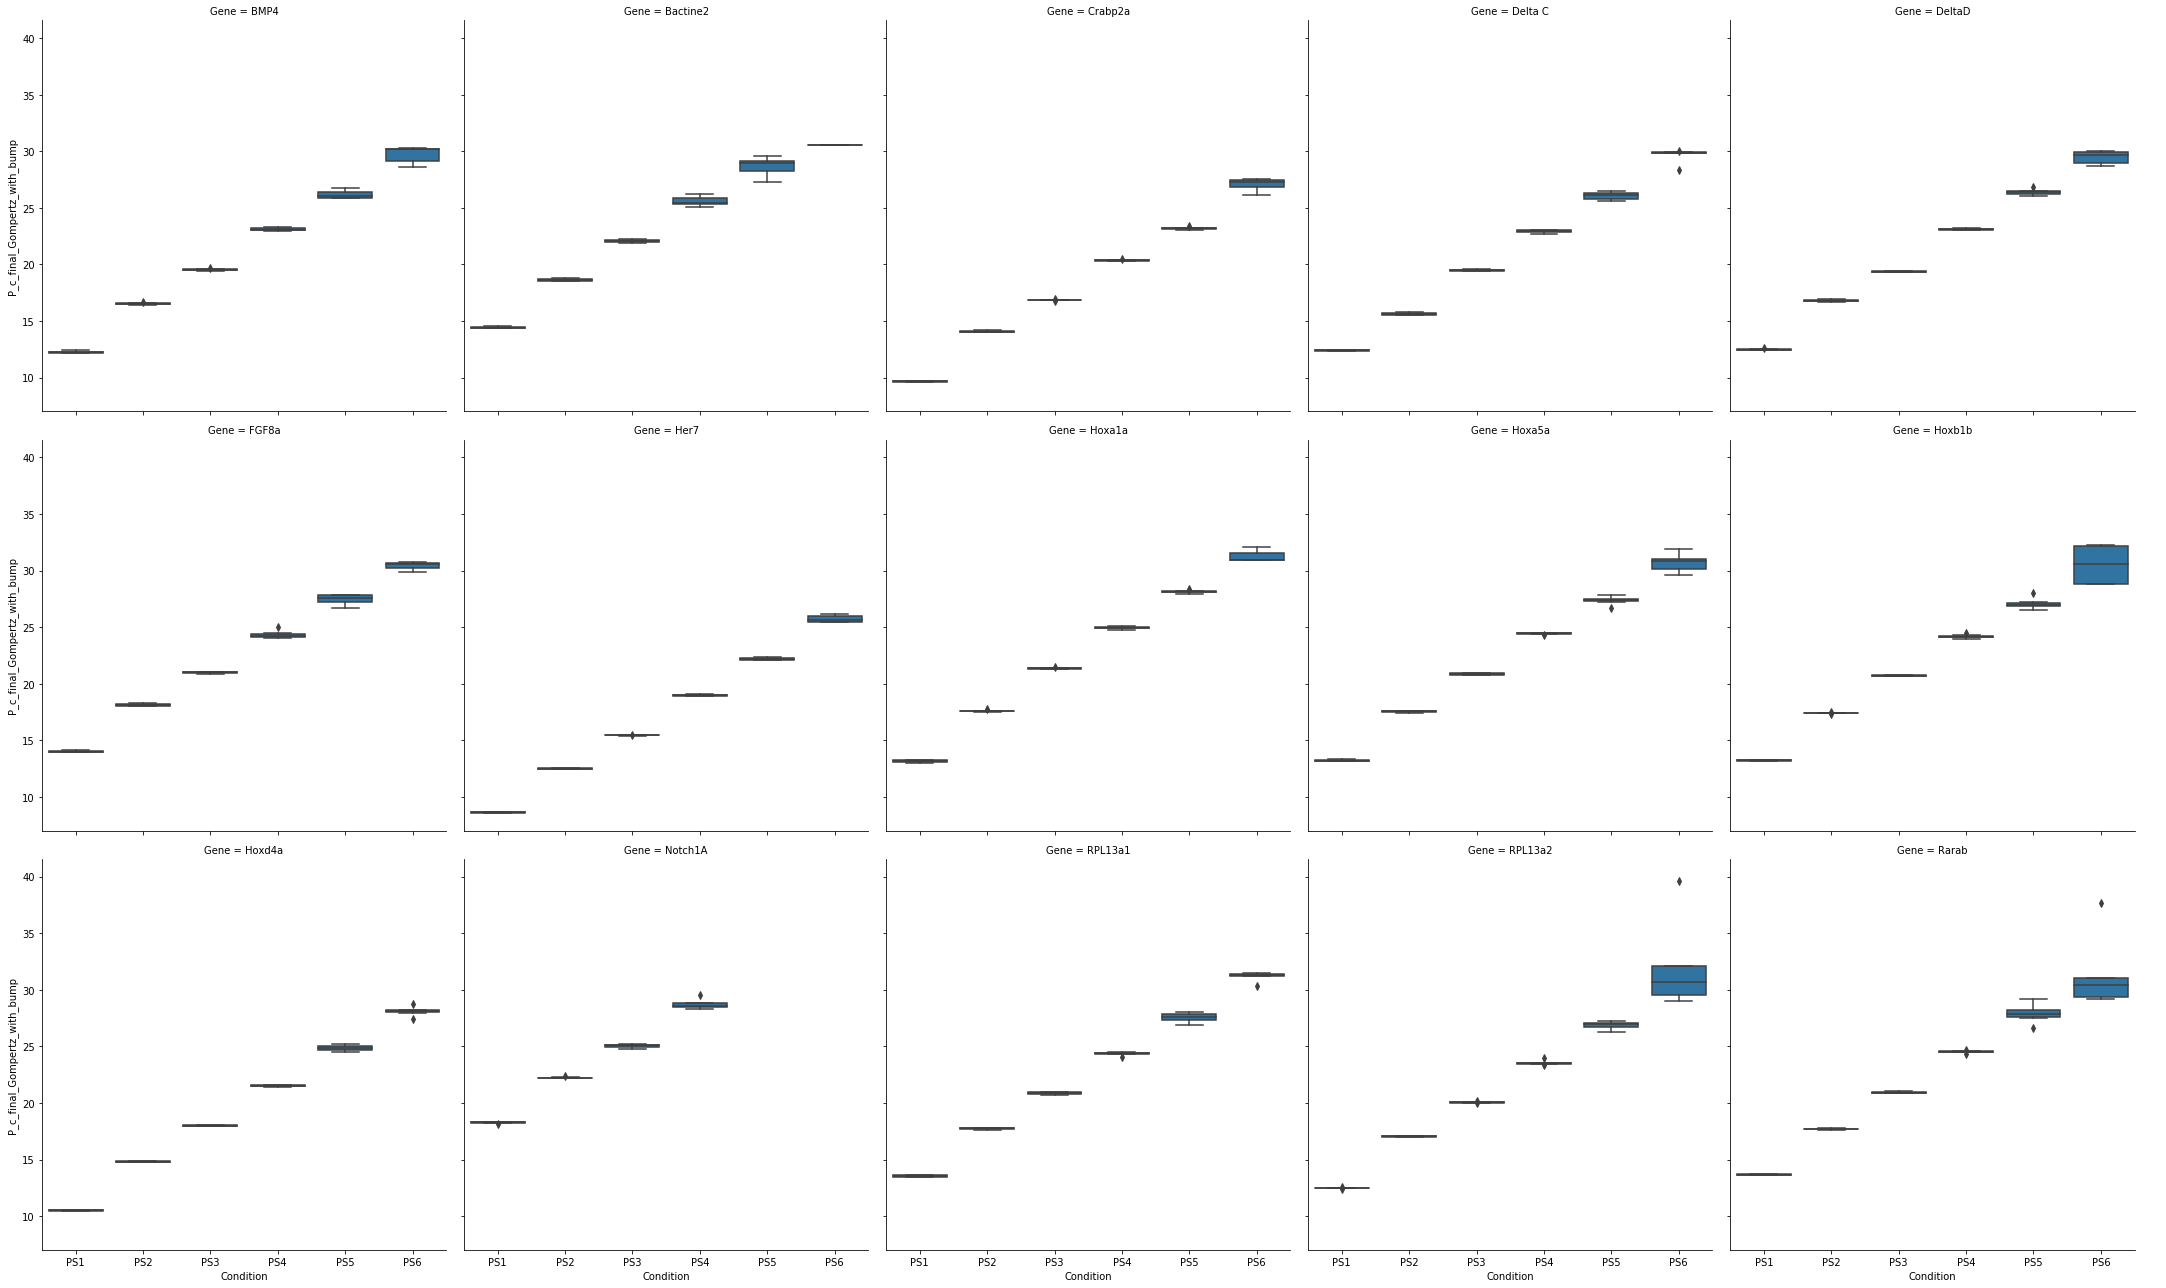

In [115]:
## Plotting efficiency param (Gompertz with bump fitted) per condition and per gene
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/final_data.Gompertz_with_bump.REF.tsv", sep="\t")
dataset = data.loc[(data.Sigmoid_curve) & (data.Pre_amplification == 0) & (data.S_or_C == "PS")]
dataset = dataset.sort_values(by=["Gene", "Dilution"])

plt.figure(figsize=(10, 10))
g = sns.FacetGrid(dataset, col="Gene", col_wrap=5, height=6)
g = (g.map_dataframe(sns.boxplot, "Condition", "P_c_final_Gompertz_with_bump").add_legend())

<Figure size 720x720 with 0 Axes>

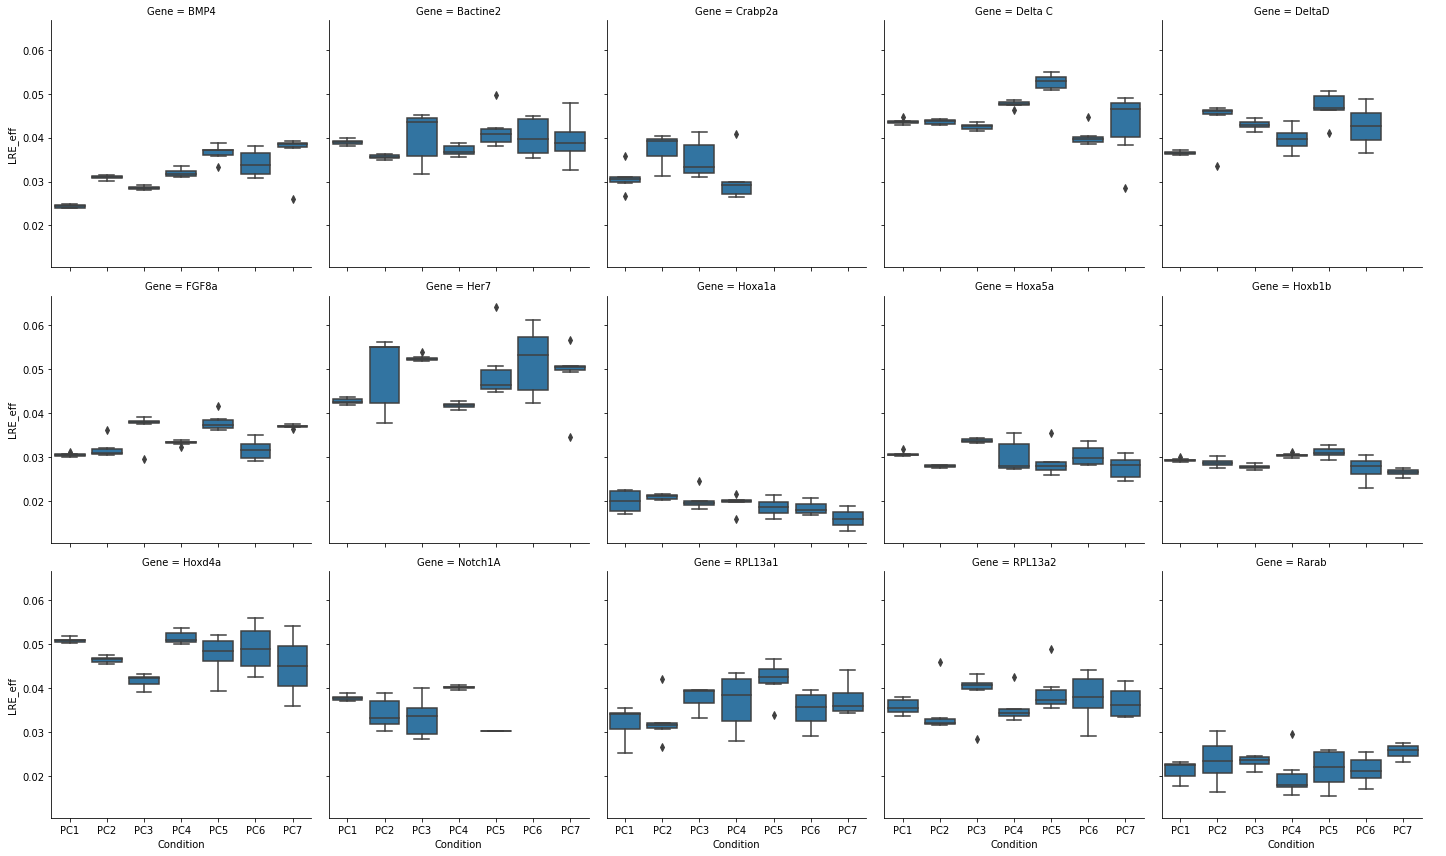

In [111]:
## Plotting the slope per condition and per gene (with LRE windows gross method)
import numpy as np
from sklearn.linear_model import LinearRegression

def eff_slope(row):
    ''' Getting the slope for the linear regression for the 4 cycles including the rising one. '''
    start_cycle = row["Rising_cycle"]
    cycles = np.array(range(start_cycle, start_cycle + 4))
    # Linearly regressing on the cycles
    model = LinearRegression().fit(cycles.reshape((-1, 1)), row[["F" + str(x).zfill(2) for x in range(start_cycle, start_cycle + 4)]])
    return model.coef_[0]

conditions = ["PC" + str(x) for x in range(1, 13)]
dataset = data.copy()
dataset["LRE_eff"] = dataset.apply(eff_slope, axis=1)
dataset = dataset.loc[(dataset.Sigmoid_curve) & (dataset.Fluidigm_Ct < 40) & (dataset.Condition.isin(conditions))]
dataset = dataset.sort_values(by=["Gene", "Dilution"])
plt.figure(figsize=(10, 10))
g = sns.FacetGrid(dataset, col="Gene", col_wrap=5, height=4)
g = (g.map_dataframe(sns.boxplot, "Condition", "LRE_eff").add_legend())

<Figure size 720x720 with 0 Axes>

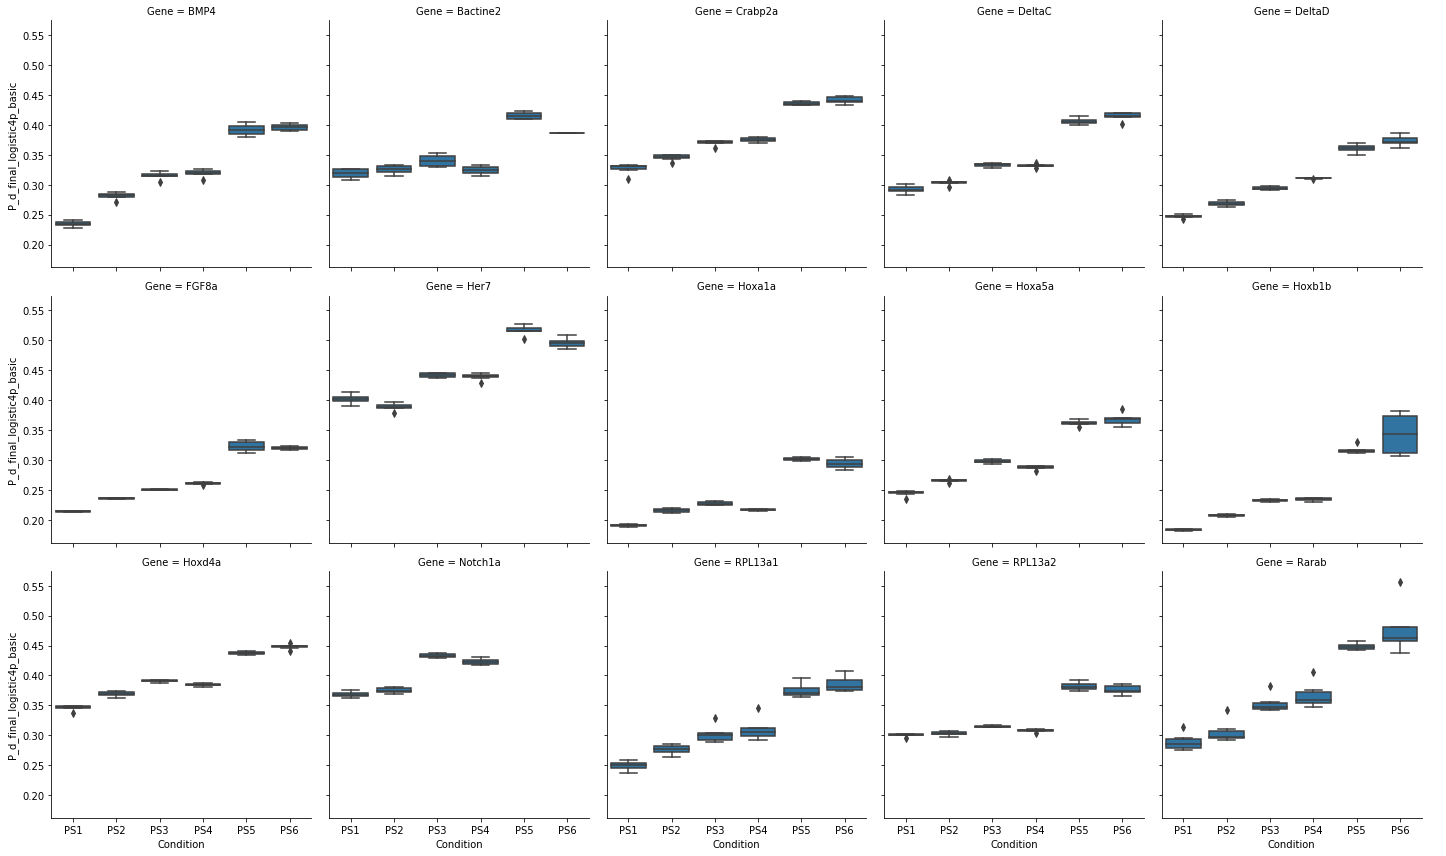

In [132]:
## Plotting the efficiency param for the basic logisitic4p
conditions = ["PS" + str(x) for x in range(1, 13)]
data = pd.read_csv("/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/logistic4p_basic/final_data.logistic4p_basic.tsv", sep="\t")
dataset = data.loc[(data.Sigmoid_curve) & (data.Fluidigm_Ct < 40) & (data.Condition.isin(conditions))]
dataset = dataset.sort_values(by=["Gene", "Dilution"])

plt.figure(figsize=(10, 10))
g = sns.FacetGrid(dataset, col="Gene", col_wrap=5, height=4)
g = (g.map_dataframe(sns.boxplot, "Condition", "P_d_final_logistic4p_basic").add_legend())
#g = (g.map_dataframe(sns.boxplot, "Condition", "F00_mod_logistic4p_basic").add_legend())

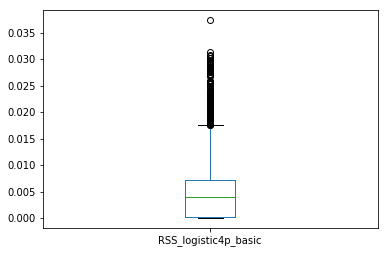

In [82]:
data4["RSS_logistic4p_basic"].plot.box()

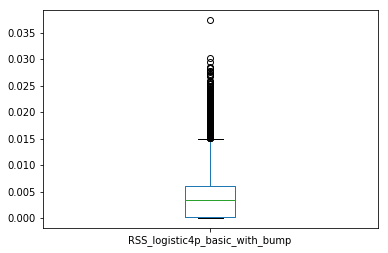

In [81]:
data5["RSS_logistic4p_basic_with_bump"].plot.box()

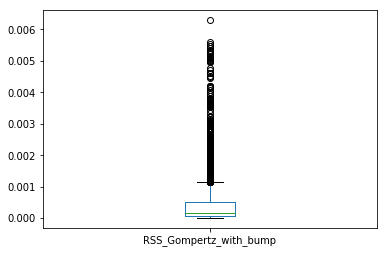

In [83]:
data["RSS_Gompertz_with_bump"].plot.box()

In [225]:
## Counting true/false feat comparisons according to theoretical N0 for the whole dataset
def compare_feat(df, feat, ctrl_feat="Fluidigm_Ct", reversed=False):
    #dataset = df.loc[(df.Pre_amplification == 0) & (df.Sigmoid_curve), ["Condition", "Gene", "S_or_C", feat, "Theoretical_N0_log"]].copy()
    #dataset = df.loc[(df.Sigmoid_curve) & (df.Pre_amplification == 0) & (df.Gene != "Notch1a") & ~((df.Gene == "Crabp2a") & (df.S_or_C == "PC")) & ~((df.Gene == "BMP4") & (df.S_or_C == "PC")), ["Condition", "Gene", "S_or_C", feat, "Fluidigm_Ct", "Theoretical_N0_log"]].copy()
    dataset = df.loc[:, ["Condition", "Gene", "S_or_C", feat, ctrl_feat, "Theoretical_N0_log", "key"]].copy()
    dataset.reset_index(inplace=True)
    #print(dataset.shape)
    pairs = pd.merge(dataset, dataset, on="key", suffixes=["_1", "_2"])
    #print(pairs.shape)
    #pairs = pairs.loc[(pairs.WellID_1 < pairs.WellID_2) & ((pairs.Condition_1 != pairs.Condition_2) | (pairs.Gene_1 != pairs.Gene_2))]
    #pairs = pairs.loc[(pairs.Condition_1 != pairs.Condition_2) | (pairs.Gene_1 != pairs.Gene_2)]
    #pairs = pairs.loc[((pairs.Condition_1 != pairs.Condition_2) | (pairs.Gene_1 != pairs.Gene_2)) & (np.abs(pairs.Theoretical_N0_log_1 - pairs.Theoretical_N0_log_2) < 2)]
    pairs = pairs.loc[((pairs.Condition_1 != pairs.Condition_2) | (pairs.Gene_1 != pairs.Gene_2)) & (np.abs(pairs.Theoretical_N0_log_1 - pairs.Theoretical_N0_log_2) < 2) & (np.abs(pairs.Theoretical_N0_log_1 - pairs.Theoretical_N0_log_2) > 0.1)].copy()
    #display(pairs.shape[0], pairs.head(2))
    pairs.loc[:, ctrl_feat + "_status"] = ((pairs.Theoretical_N0_log_1 > pairs.Theoretical_N0_log_2) & (pairs[ctrl_feat + "_1"] < pairs[ctrl_feat + "_2"])) | ((pairs.Theoretical_N0_log_1 < pairs.Theoretical_N0_log_2) & (pairs[ctrl_feat + "_1"] > pairs[ctrl_feat + "_2"]))
    print(ctrl_feat + " accuracy:", "{:.1%}".format(pairs.loc[pairs[ctrl_feat + "_status"], :].shape[0] / pairs.shape[0]))
    if reversed:
        pairs.loc[:, feat + "_status"] = ((pairs.Theoretical_N0_log_1 > pairs.Theoretical_N0_log_2) & (pairs[feat + "_1"] < pairs[feat + "_2"])) | ((pairs.Theoretical_N0_log_1 < pairs.Theoretical_N0_log_2) & (pairs[feat + "_1"] > pairs[feat + "_2"]))
    else:
        pairs.loc[:, feat + "_status"] = ((pairs.Theoretical_N0_log_1 > pairs.Theoretical_N0_log_2) & (pairs[feat + "_1"] > pairs[feat + "_2"])) | ((pairs.Theoretical_N0_log_1 < pairs.Theoretical_N0_log_2) & (pairs[feat + "_1"] < pairs[feat + "_2"]))
    print(feat, "accuracy:", "{:.1%}".format(pairs.loc[pairs[feat + "_status"], :].shape[0] / pairs.shape[0]))
    #pairs.to_csv("/data/biocomp/bahin/tmp.tsv", sep="\t", index=False)
    print("Equal " + feat + ":", "{:.1%}".format(pairs.loc[pairs[feat + "_1"] == pairs[feat + "_2"]].shape[0] / pairs.shape[0]))
    return pairs

#errors = compare_feat(data, "F00")
#compare_feat(data, "F00_mod_Gompertz_with_bump")
print(dataset.shape)
pairs = compare_feat(dataset, "P_c_final_Gompertz_with_bump", reversed=True)
#compare_feat(data, "P_d_final_Gompertz_with_bump")

(1005, 108)
Fluidigm_Ct accuracy: 91.1%
P_c_final_Gompertz_with_bump accuracy: 85.9%
Equal P_c_final_Gompertz_with_bump: 0.0%


In [147]:
filepath = "/data/biocomp/bahin/tmp.tsv"
dataset = pd.read_csv(filepath, sep="\t")
display(dataset.head(2))
print(dataset.groupby(["Fluidigm_status", "Feat_status"]).size())

WellID_1 Condition_1   Gene_1 S_or_C_1  Predicted_N0_1  Fluidigm_Ct_1  \
0  S01-A01         PS1  RPL13a1       PS        6.400175       8.491106   
1  S01-A01         PS1  RPL13a1       PS        6.400175       8.491106   

   Theoretical_N0_log_1  key WellID_2 Condition_2   Gene_2 S_or_C_2  \
0              6.274079    0  S02-A01         PS2  RPL13a1       PS   
1              6.274079    0  S02-A02         PS2  RPL13a1       PS   

   Predicted_N0_2  Fluidigm_Ct_2  Theoretical_N0_log_2  Fluidigm_status  \
0        5.129367      12.929817              5.274079             True   
1        5.221391      12.504388              5.274079             True   

   Feat_status  
0         True  
1         True

Fluidigm_status  Feat_status
False            False           24986
                 True            13084
True             False            6842
                 True           384604
dtype: int64


Gene_1  Condition_1  Gene_2    Condition_2
BMP4    PC1          BMP4      PS1            36
                               PS2            36
                     Bactine2  PC1            36
                               PC2            36
                               PC3            36
                               PS1            36
                               PS2            36
                     Crabp2a   PC1            36
                               PC2            36
                               PS1            36
                               PS2            36
                     DeltaC    PC2            36
                               PC3            36
                               PS1            36
                               PS2            36
                     DeltaD    PC1            36
                               PC2            36
                               PS1            36
                               PS2            36
                     FGF8a

/users/biocomp/bahin/miniconda3/envs/Env_conda_qPCR/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


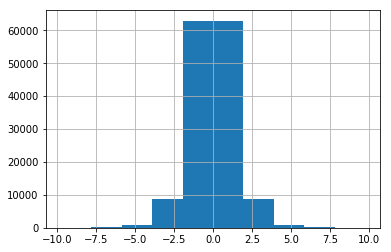

In [119]:
display(errors.groupby(["Gene_1", "Condition_1", "Gene_2", "Condition_2"]).size())
errors.groupby(["Gene_1", "Condition_1"]).size().to_csv("/data/biocomp/bahin/tmp.tsv", sep="\t")
errors.loc[:, "Diff"] = errors["Theoretical_N0_log_1"] - errors["Theoretical_N0_log_2"]
errors["Diff"].hist()
#errors.to_csv("/data/biocomp/bahin/tmp.tsv", sep="\t")

In [17]:
## Splitting the DataFrame into training and testing sets
# Creating the training set (500 first wells with sigmoid curve and no preamp for one random shuffling)
#dataset = data.loc[(data.Sigmoid_curve) & (data.Pre_amplification == 0)]
dataset = data.loc[(data.Sigmoid_curve) & (data.Pre_amplification == 0) & (data.Gene != "Notch1a") & ~((data.Gene == "Crabp2a") & (data.S_or_C == "PC")) & ~((data.Gene == "BMP4") & (data.S_or_C == "PC")), :].copy()
training_set = dataset.sample(frac=1, random_state=52).iloc[:500, :]
display(training_set.head(2))

# Creating the test set (the other wells with sigmoid curve and no preamp)
test_set = dataset.iloc[500:, :]
display(test_set.head(2))

Condition    Gene  Fluidigm_Ct  Sample  Assay       F00       F01  \
WellID                                                                      
S03-A37       PS3  DeltaC    16.068862       3     37  0.273822  0.281206   
S50-A63       PC2  Hoxa1a    12.360721      50     63  0.303179  0.310176   

              F02       F03       F04  ...  F30_mod_Gompertz_with_bump  \
WellID                                 ...                               
S03-A37  0.287446  0.292988  0.297778  ...                    0.943026   
S50-A63  0.315739  0.321675  0.326757  ...                    0.843106   

         F31_mod_Gompertz_with_bump  F32_mod_Gompertz_with_bump  \
WellID                                                            
S03-A37                    0.956327                    0.966577   
S50-A63                    0.864304                    0.882840   

         F33_mod_Gompertz_with_bump  F34_mod_Gompertz_with_bump  \
WellID                                                            
S03-A37                    0.974454                    0.980493   
S50-A63                    0.898993                    0.913029   

         F35_mod_Gompertz_with_bump  F36_mod_Gompertz_with_bump  \
WellID                                                            
S03-A37                    0.985116                    0.988649   
S50-A63                    0.925197                    0.935723   

         F37_mod_Gompertz_with_bump  F38_mod_Gompertz_with_bump  \
WellID                                                            
S03-A37                    0.991347                    0.993406   
S50-A63                    0.944812                    0.952649   

         F39_mod_Gompertz_with_bump  
WellID                               
S03-A37                    0.994977  
S50-A63                    0.959396  

[2 rows x 107 columns]

Condition  Gene  Fluidigm_Ct  Sample  Assay       F00       F01  \
WellID                                                                    
S07-A55       PS7  Her7    27.976653       7     55  0.421526  0.432370   
S07-A56       PS7  Her7    25.339252       7     56  0.410911  0.423314   

              F02       F03       F04  ...  F30_mod_Gompertz_with_bump  \
WellID                                 ...                               
S07-A55  0.440438  0.449605  0.457405  ...                    0.259978   
S07-A56  0.431239  0.438537  0.447736  ...                    0.601714   

         F31_mod_Gompertz_with_bump  F32_mod_Gompertz_with_bump  \
WellID                                                            
S07-A55                    0.390261                    0.518296   
S07-A56                    0.704258                    0.785060   

         F33_mod_Gompertz_with_bump  F34_mod_Gompertz_with_bump  \
WellID                                                            
S07-A55                    0.631893                    0.725700   
S07-A56                    0.846176                    0.891112   

         F35_mod_Gompertz_with_bump  F36_mod_Gompertz_with_bump  \
WellID                                                            
S07-A55                    0.799364                    0.855206   
S07-A56                    0.923512                    0.946560   

         F37_mod_Gompertz_with_bump  F38_mod_Gompertz_with_bump  \
WellID                                                            
S07-A55                    0.896508                    0.926533   
S07-A56                    0.962802                    0.974175   

         F39_mod_Gompertz_with_bump  
WellID                               
S07-A55                    0.948099  
S07-A56                    0.982103  

[2 rows x 107 columns]

In [20]:
## Counting true/false feat comparisons according to theoretical N0 for the test set
#compare_feat(test_set, "F00")
#compare_feat(test_set, "F00_mod_Gompertz_with_bump")
#compare_feat(test_set, "P_c_final_Gompertz_with_bump")
#errors = compare_feat(test_set, "P_c_final_Gompertz_with_bump")

(505, 7)


WellID_1 Condition_1 Gene_1 S_or_C_1  Fluidigm_Ct_1  Theoretical_N0_log_1  \
5  S07-A55         PS7   Her7       PS      27.976653              0.274718   
6  S07-A55         PS7   Her7       PS      27.976653              0.274718   

   key WellID_2 Condition_2  Gene_2 S_or_C_2  Fluidigm_Ct_2  \
5    0  S07-A68         PS7  Hoxb1b       PS      26.108907   
6    0  S07-A73         PS7  Hoxd4a       PS      29.762595   

   Theoretical_N0_log_2  
5              0.274292  
6              0.274292

(113594, 13)
N0_1 > N0_2, Fluidigm_Ct_1 > Fluidigm_Ct_2 (13746, 13)
N0_1 > N0_2, Fluidigm_Ct_1 < Fluidigm_Ct_2 (99378, 13)
N0_1 = N0_2 (470, 13)


In [21]:
## Trying the linear regression with the parameters "c" and "d"
from scipy.optimize import minimize

# Equations
def residualSumSquare_predict(parameter_rss, data, equation):
    return np.sum((np.array(data["Theoretical_N0_log"]) - equation(data["P_c_final_Gompertz_with_bump"], data["P_d_final_Gompertz_with_bump"], *parameter_rss))**2)

def linear_reg_2p(Pc, Pd, a, b, c):
    return Pc * a + Pd * b + c

def quadratic_eq_beg(Pc, Pd, a, b, c, d, e):
    return a * np.exp(b * Pc) + c * np.exp(d * Pd) + e

def quadratic_eq(Pc, Pd, a, b, c, d, e, f, g):
    return a * np.exp(b * Pc) + c * np.exp(d * Pd) + Pc * e + Pd * f + g

def quadratic_true_eq(Pc, Pd, a, b, c, d, e, f, g):
    return a * Pc**2 * Pd**2 + b * Pc**2 * Pd + c * Pc * Pd**2 + d * Pc * Pd + e * Pc + f * Pd + g 

def simple_eq(Pc, Pd, a, b, c):
    return a * Pc + b * Pd + c

def simple_plus_exp_eq(Pc, Pd, a, b, c, d):
    return a * Pc + b * Pd + c + np.power(d, Pc)

def Tif_eq(Pc, Pd, a, b, c, d, e, f):
    return a * Pc + b * Pd + c + d / Pc + e / Pd + f / (Pc * Pd)

def mega_Tif_eq(Pc, Pd, a, b, c, d, e, f, h, i, j, k, l, m):
    return h * Pc + i * Pd + j + k/Pc + l/Pd + m/(Pc * Pd) + \
a * Pc**2 * Pd**2 + b * Pc**2 * Pd + c * Pc * Pd**2 + d * Pc * Pd + e * Pc + f * Pd

# Filtering the dataset
#dataset = data.loc[(data["Pre_amplification"] == 0) & (data["Sigmoid_curve"])].copy()
dataset = data.loc[(data.Sigmoid_curve) & (data.Pre_amplification == 0) & (data.Gene != "Notch1a") & ~((data.Gene == "Crabp2a") & (data.S_or_C == "PC")) & ~((data.Gene == "BMP4") & (data.S_or_C == "PC")), :].copy()

# Setting the equation
eq = linear_reg_2p
#eq = quadratic_eq
#eq = quadratic_true_eq
#eq = simple_eq
#eq = simple_plus_exp_eq
#eq = Tif_eq
#eq = mega_Tif_eq

# Adjusting the parameters minimizing the RSS
x0 = [1] * (eq.__code__.co_argcount - 2)
minimized_IPS = minimize(residualSumSquare_predict, x0=x0, args=(dataset, eq), method="Nelder-Mead", options={"maxiter":10000} )
print(minimized_IPS)

# Computing the predicted value
dataset.loc[:, "Predicted_N0"] = eq(dataset["P_c_final_Gompertz_with_bump"], dataset["P_d_final_Gompertz_with_bump"], *minimized_IPS.x)
print(dataset[["Theoretical_N0_log", "Predicted_N0"]].head())
print(np.mean(np.abs(dataset["Theoretical_N0_log"] - dataset["Predicted_N0"])))

# Checking the results
pairs = compare_feat(dataset, "Predicted_N0")

 final_simplex: (array([[-0.29126493, -8.2237622 , 12.08403354],
       [-0.29126258, -8.2238548 , 12.08399597],
       [-0.29126464, -8.22367105, 12.08399445],
       [-0.29126229, -8.22371004, 12.08396911]]), array([317.06903793, 317.06903795, 317.06903798, 317.06903812]))
           fun: 317.06903793012077
       message: 'Optimization terminated successfully.'
          nfev: 296
           nit: 164
        status: 0
       success: True
             x: array([-0.29126493, -8.2237622 , 12.08403354])
         Theoretical_N0_log  Predicted_N0
WellID                                   
S01-A01            6.274079      6.380689
S01-A02            6.274079      6.421067
S01-A03            6.274079      6.433991
S01-A04            6.274079      6.422894
S01-A05            6.274079      6.376495
0.33057476242432765
Fluidigm accuracy: 91.1%
Predicted_N0 accuracy: 92.2%


(100, 100)


Text(0, 0.5, 'Pc')

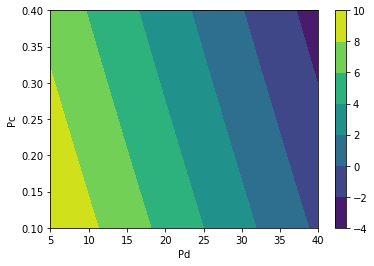

In [28]:
# Plotting the plan
xlist = np.linspace(5, 40, 100)
ylist = np.linspace(0.1, 0.4, 100)
X, Y = np.meshgrid(xlist, ylist)
#Z = np.sqrt(X**2 + Y**2)
Z = eq(X, Y, *minimized_IPS.x)
print(Z.shape)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
#ax.set_title('Filled Contours Plot')
ax.set_xlabel("Pd")
ax.set_ylabel("Pc")

In [34]:
## Checking linear regression with the parameters "c" and "d" success rate
import pandas as pd

dataset = test_set.merge(dataset["Predicted_N0"], left_index=True, right_index=True)
#display(dataset.head(2))

errors = compare_feat(dataset, "Predicted_N0")

(505, 7)


WellID_1 Condition_1 Gene_1 S_or_C_1  Predicted_N0_1  Theoretical_N0_log_1  \
5  S07-A55         PS7   Her7       PS        0.152921              0.274718   
6  S07-A55         PS7   Her7       PS        0.152921              0.274718   

   key WellID_2 Condition_2  Gene_2 S_or_C_2  Predicted_N0_2  \
5    0  S07-A68         PS7  Hoxb1b       PS        1.316106   
6    0  S07-A73         PS7  Hoxd4a       PS       -0.109896   

   Theoretical_N0_log_2  
5              0.274292  
6              0.274292

(113594, 13)
N0_1 > N0_2, Predicted_N0_1 > Predicted_N0_2 (99098, 13)
N0_1 > N0_2, Predicted_N0_1 < Predicted_N0_2 (14026, 13)
N0_1 = N0_2 (470, 13)


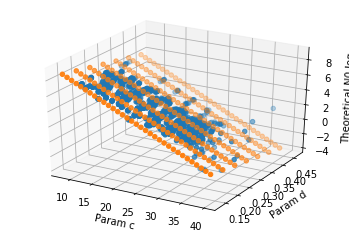

In [29]:
## Displaying params "c" and "d" against theoretical N0 in 3D + the predicting plan
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Setting the real data
#dataset = data.loc[(data.Sigmoid_curve) & (data.Pre_amplification == 0), :]
dataset = data.loc[(data.Sigmoid_curve) & (data.Pre_amplification == 0) & (data.Gene != "Notch1a") & ~((data.Gene == "Crabp2a") & (data.S_or_C == "PC")) & ~((data.Gene == "BMP4") & (data.S_or_C == "PC")), :].copy()
#display(dataset.head(2))
#print(dataset.columns.values)

# Setting the plan
l1 = range(8, 41)
l2 = np.arange(0.13, 0.47, 0.05)
dataset2 = pd.DataFrame(list(product(l1, l2)), columns=["l1", "l2"])
#display(dataset2.head(2))
#dataset2.loc[:, "Testing"] = dataset2.apply(lambda row: linear_reg_2p(row.l1, row.l2, -0.29, -5.13, 11.27), axis=1)
dataset2.loc[:, "Testing"] = dataset2.apply(lambda row: eq(row.l1, row.l2, *minimized_IPS.x), axis=1)

# Displaying both
threedee = plt.figure().gca(projection='3d')
threedee.scatter(dataset.P_c_final_Gompertz_with_bump, dataset.P_d_final_Gompertz_with_bump, dataset.Theoretical_N0_log)
threedee.scatter(dataset2.l1, dataset2.l2, dataset2.Testing)
threedee.set_xlabel("Param c")
threedee.set_ylabel("Param d")
threedee.set_zlabel("Theoretical N0 log")
plt.show()

In [250]:
## Compare param d (efficiency) differences with a KS test between cases where I was right and Fluidigm wrong
from scipy import stats

dataset1 = pairs.loc[~pairs.Fluidigm_status & pairs.Feat_status, :].copy()
dataset2 = pairs.copy()
#dataset2 = pairs.loc[pairs.Feat_status == True, :].copy()
#dataset2 = pairs.loc[pairs.Fluidigm_status & ~pairs.Feat_status == True, :].copy()
print(dataset2.shape)

dataset1.loc[:, "Diff_param_d"] = dataset1.apply(lambda row: np.abs(data.loc[row["WellID_1"], "P_d_final_Gompertz_with_bump"] - data.loc[row["WellID_2"], "P_d_final_Gompertz_with_bump"]), axis=1)
dataset2.loc[:, "Diff_param_d"] = dataset2.apply(lambda row: np.abs(data.loc[row["WellID_1"], "P_d_final_Gompertz_with_bump"] - data.loc[row["WellID_2"], "P_d_final_Gompertz_with_bump"]), axis=1)

print(dataset1.shape, dataset1["Diff_param_d"].mean(), dataset2.shape, dataset2["Diff_param_d"].mean())
stats.ks_2samp(dataset1["Diff_param_d"], dataset2["Diff_param_d"])

(429516, 17)
(12222, 18) 0.10509885595201045 (429516, 18) 0.05734287688722667


Ks_2sampResult(statistic=0.4097389353864084, pvalue=0.0)

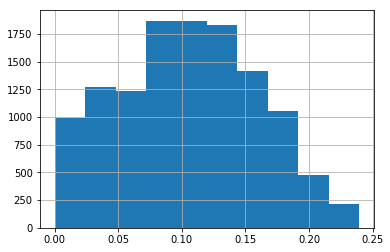

In [251]:
dataset1["Diff_param_d"].hist()

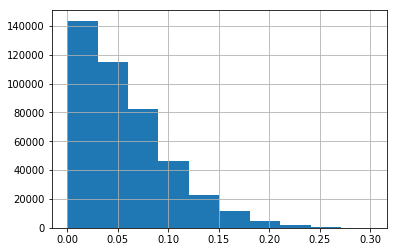

In [247]:
dataset2["Diff_param_d"].hist()

In [260]:
## Compare RSS sum (for both curves) with a KS test between cases where Fluidigm was right and I wrong
from scipy import stats

dataset1 = pairs.loc[pairs.Fluidigm_status & ~pairs.Feat_status, :].copy()
dataset2 = pairs.copy()
#dataset2 = pairs.loc[pairs.Fluidigm_status == True, :].copy()
#dataset2 = pairs.loc[~pairs.Fluidigm_status & pairs.Feat_status == True, :].copy()
print(dataset2.shape)

dataset1.loc[:, "Diff_RSS"] = dataset1.apply(lambda row: np.abs(data.loc[row["WellID_1"], "RSS_Gompertz_with_bump"] - data.loc[row["WellID_2"], "RSS_Gompertz_with_bump"]), axis=1)
dataset2.loc[:, "Diff_RSS"] = dataset2.apply(lambda row: np.abs(data.loc[row["WellID_1"], "RSS_Gompertz_with_bump"] - data.loc[row["WellID_2"], "RSS_Gompertz_with_bump"]), axis=1)

print(dataset1.shape, dataset1["Diff_RSS"].mean(), dataset2.shape, dataset2["Diff_RSS"].mean())
stats.ks_2samp(dataset1["Diff_RSS"], dataset2["Diff_RSS"])

(429516, 17)
(7476, 18) 0.00039569975763712676 (429516, 18) 0.00044158607998145776


Ks_2sampResult(statistic=0.05614994589378197, pvalue=1.3220876843495005e-20)

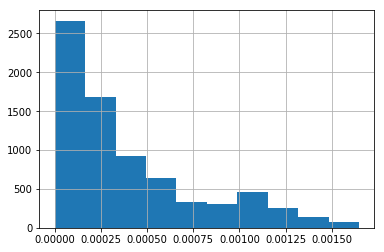

In [253]:
dataset1["Diff_RSS"].hist()

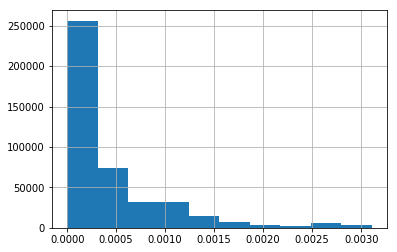

In [259]:
dataset2["Diff_RSS"].hist()

In [21]:
## Linear regression for c and d params (to get theoretical N0)
from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(training_set[["P_c_final_Gompertz_with_bump", "P_d_final_Gompertz_with_bump"]], training_set["Theoretical_N0_log"])

# Displaying the coefficient and intercept
print(reg.coef_)
print(reg.intercept_)

# Displaying the intercept
#reg.predict([[13.52, 0.21]])

[-0.29087107 -8.23248454]
12.069933779922897


In [22]:
test_set.loc[:, "Predicted_N0_log"] = test_set.apply(lambda row: reg.predict([[row.P_c_final_Gompertz_with_bump, row.P_d_final_Gompertz_with_bump]])[0], axis=1).copy()
display(test_set[["Theoretical_N0_log", "Predicted_N0_log"]].head())

/users/biocomp/bahin/miniconda3/envs/Env_conda_qPCR/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/users/biocomp/bahin/miniconda3/envs/Env_conda_qPCR/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Theoretical_N0_log  Predicted_N0_log
WellID                                       
S07-A55            0.274718          0.147834
S07-A56            0.274718          0.822949
S07-A57            0.274718          0.778132
S07-A59            0.274718          0.360079
S07-A60            0.274718          0.553953

In [23]:
## Comparing for the linear regression method
errors = compare_feat(test_set, "Predicted_N0_log")

(505, 7)


WellID_1 Condition_1 Gene_1 S_or_C_1  Predicted_N0_log_1  \
5  S07-A55         PS7   Her7       PS            0.147834   
6  S07-A55         PS7   Her7       PS            0.147834   

   Theoretical_N0_log_1  key WellID_2 Condition_2  Gene_2 S_or_C_2  \
5              0.274718    0  S07-A68         PS7  Hoxb1b       PS   
6              0.274718    0  S07-A73         PS7  Hoxd4a       PS   

   Predicted_N0_log_2  Theoretical_N0_log_2  
5            1.312307              0.274292  
6           -0.113033              0.274292

(113594, 13)
N0_1 > N0_2, Predicted_N0_log_1 > Predicted_N0_log_2 (99086, 13)
N0_1 > N0_2, Predicted_N0_log_1 < Predicted_N0_log_2 (14038, 13)
N0_1 = N0_2 (470, 13)


8.573599424331816 39.835496741310415 0.13268757598952458 0.4676091699047741


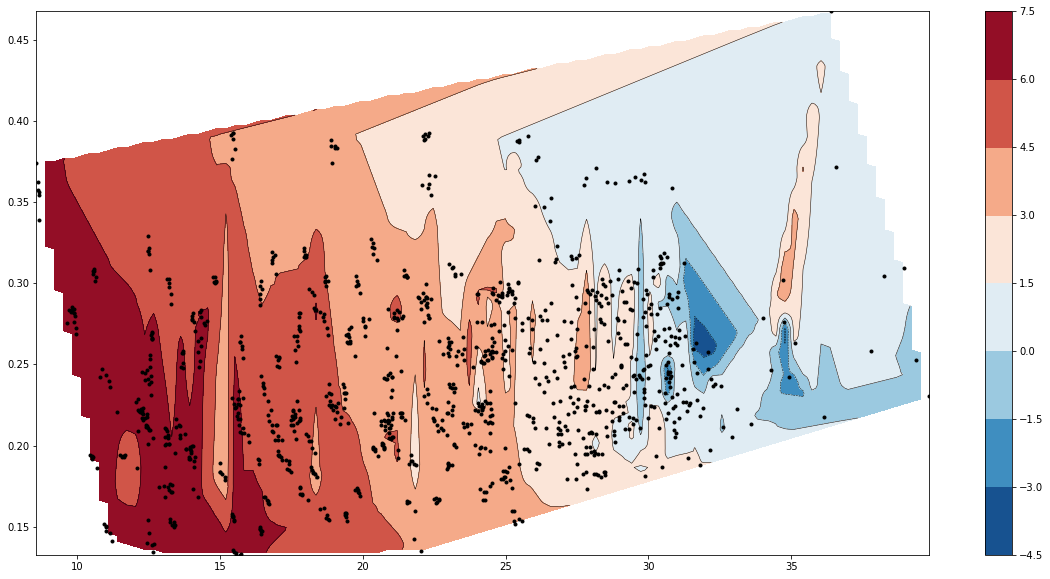

In [61]:
## TriLinearInterpolation approach
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np

npts = 200
ngridx = 100
ngridy = 200
#dataset = data.loc[data.Sigmoid_curve]
dataset = data.loc[(data.Sigmoid_curve) & (data.Pre_amplification == 0)]
x = dataset["P_c_final_Gompertz_with_bump"]
y = dataset["P_d_final_Gompertz_with_bump"]
z = dataset["Theoretical_N0_log"]

print(x.min(), x.max(), y.min(), y.max())

fig, ax1 = plt.subplots(nrows=1, figsize=(20,10))

# Creating regularly spaced values from x min to x max
xi = np.linspace(x.min(), x.max(), ngridx)
# Creating regularly spaced values from y min to y max
yi = np.linspace(y.min(), y.max(), ngridy)

# Creating the interpolation function
triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)
# Creating a mesh grid encompassing all data from x and y min to x and y max
Xi, Yi = np.meshgrid(xi, yi)
# Interpolating z values
zi = interpolator(Xi, Yi)

ax1.contour(xi, yi, zi, levels=10, linewidths=0.5, colors='k')
cntr1 = ax1.contourf(xi, yi, zi, levels=10, cmap="RdBu_r")

fig.colorbar(cntr1, ax=ax1)
ax1.plot(x, y, 'ko', ms=3)  # Show the points

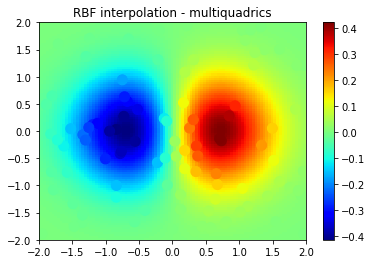

In [4]:
import numpy as np
from scipy.interpolate import Rbf

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import cm

# 2-d tests - setup scattered data
x = np.random.rand(100)*4.0-2.0
y = np.random.rand(100)*4.0-2.0
z = x*np.exp(-x**2-y**2)
ti = np.linspace(-2.0, 2.0, 100)
XI, YI = np.meshgrid(ti, ti)

# use RBF
rbf = Rbf(x, y, z, epsilon=2)
ZI = rbf(XI, YI)

# plot the result
n = plt.Normalize(-2., 2.)
plt.subplot(1, 1, 1)
plt.pcolor(XI, YI, ZI, cmap=cm.jet)
plt.scatter(x, y, 100, z, cmap=cm.jet)
plt.title('RBF interpolation - multiquadrics')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.colorbar()

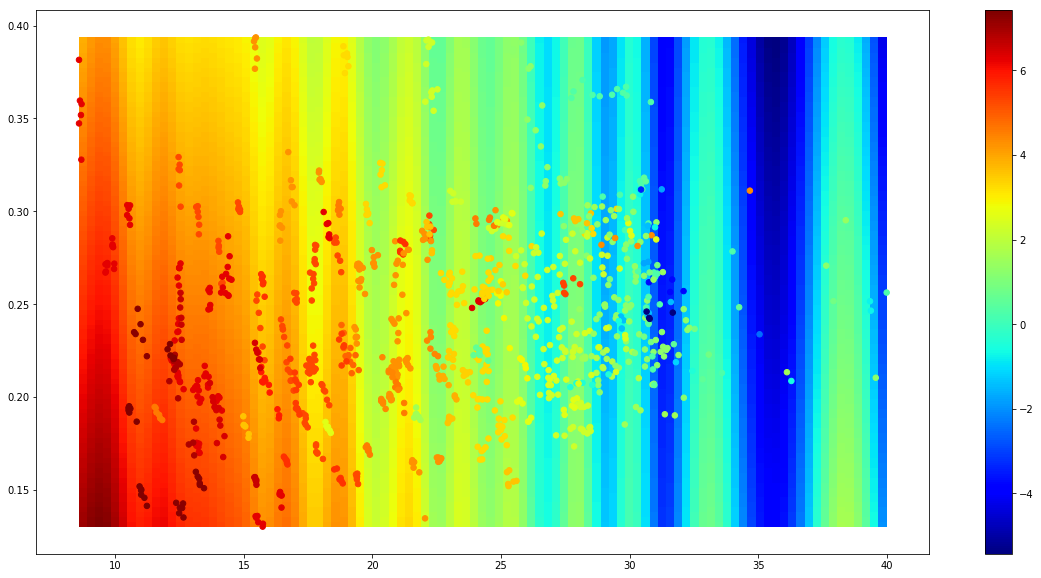

In [55]:
import numpy as np
from scipy.interpolate import Rbf

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import cm

# 2-d tests - setup scattered data
dataset = data.loc[(data.Sigmoid_curve) & (data.Pre_amplification == 0)]
x = dataset["P_c_final_Gompertz_with_bump"]
y = dataset["P_d_final_Gompertz_with_bump"]
z = dataset["Theoretical_N0_log"]

#ti = np.linspace(-2.0, 2.0, 100)
#XI, YI = np.meshgrid(ti, ti)
# Creating regularly spaced values from x min to x max
xi = np.linspace(x.min(), x.max(), 100)
# Creating regularly spaced values from y min to y max
yi = np.linspace(y.min(), y.max(), 100)
# Creating a mesh grid encompassing all data from x and y min to x and y max
XI, YI = np.meshgrid(xi, yi)

# use RBF
rbf = Rbf(x, y, z, function="cubic", smooth=10, epsilon=2)
ZI = rbf(XI, YI)

# plot the result
plt.figure(figsize=(20, 10))
plt.pcolor(XI, YI, ZI, cmap=cm.jet)
plt.scatter(x, y, 30, z, cmap=cm.jet)
plt.colorbar()

In [18]:
## Saving data for AG deep learning test
dir = "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/"
data = pd.read_csv(dir + "final_data.Gompertz_with_bump.REF.tsv", index_col=0, sep="\t")
#data = pd.read_csv(dir + "QV_plate/final_data.Gompertz_with_bump.REF.tsv", index_col=0, sep="\t")
#dataset = data.loc[(data.Pre_amplification == 0) & (data.Sigmoid_curve), ["Condition", "Gene", "Theoretical_N0"] + cycles_col]
dataset = data.loc[(data.Pre_amplification == 0) & (data.Sigmoid_curve), ["Condition", "Gene", "Theoretical_N0_log"] + cycles_col]
display(dataset.head(2))
dataset.to_csv("/projects/biocomp/Projects/qPCR/research_plate.log.AG.csv", sep=";")
#dataset.to_csv("/projects/biocomp/Projects/qPCR/QV_plate.log.AG.csv", sep=";")

Condition     Gene  Theoretical_N0_log       F00       F01       F02  \
WellID                                                                         
S01-A01       PS1  RPL13a1            6.274079  0.370476  0.375293  0.379359   
S01-A02       PS1  RPL13a1            6.274079  0.351437  0.359487  0.363358   

              F03       F04       F05       F06    ...          F30       F31  \
WellID                                             ...                          
S01-A01  0.384355  0.390125  0.395933  0.401709    ...     1.082936  1.091343   
S01-A02  0.368100  0.374405  0.380636  0.387685    ...     1.128257  1.135592   

              F32       F33       F34       F35       F36       F37      F38  \
WellID                                                                         
S01-A01  1.093735  1.099976  1.103117  1.105738  1.110323  1.114438  1.11796   
S01-A02  1.145927  1.146932  1.153027  1.155100  1.160351  1.166274  1.16749   

              F39  
WellID             
S01-A01  1.119182  
S01-A02  1.171007  

[2 rows x 43 columns]

Condition     Gene  Fluidigm_Ct  Sample  Assay       F00       F01  \
WellID                                                                       
S01-A01       PS1  RPL13a1     8.491106       1      1  0.370476  0.375293   
S01-A02       PS1  RPL13a1     8.375671       1      2  0.351437  0.359487   

              F02       F03       F04  ...  F30_mod_Gompertz_with_bump  \
WellID                                 ...                               
S01-A01  0.379359  0.384355  0.390125  ...                    0.970113   
S01-A02  0.363358  0.368100  0.374405  ...                    0.970076   

         F31_mod_Gompertz_with_bump  F32_mod_Gompertz_with_bump  \
WellID                                                            
S01-A01                    0.975771                    0.980369   
S01-A02                    0.975709                    0.980292   

         F33_mod_Gompertz_with_bump  F34_mod_Gompertz_with_bump  \
WellID                                                            
S01-A01                    0.984102                    0.987129   
S01-A02                    0.984017                    0.987043   

         F35_mod_Gompertz_with_bump  F36_mod_Gompertz_with_bump  \
WellID                                                            
S01-A01                    0.989583                    0.991571   
S01-A02                    0.989499                    0.991492   

         F37_mod_Gompertz_with_bump  F38_mod_Gompertz_with_bump  \
WellID                                                            
S01-A01                    0.993181                    0.994484   
S01-A02                    0.993107                    0.994417   

         F39_mod_Gompertz_with_bump  
WellID                               
S01-A01                    0.995539  
S01-A02                    0.995479  

[2 rows x 107 columns]

<IPython.core.display.Javascript object>


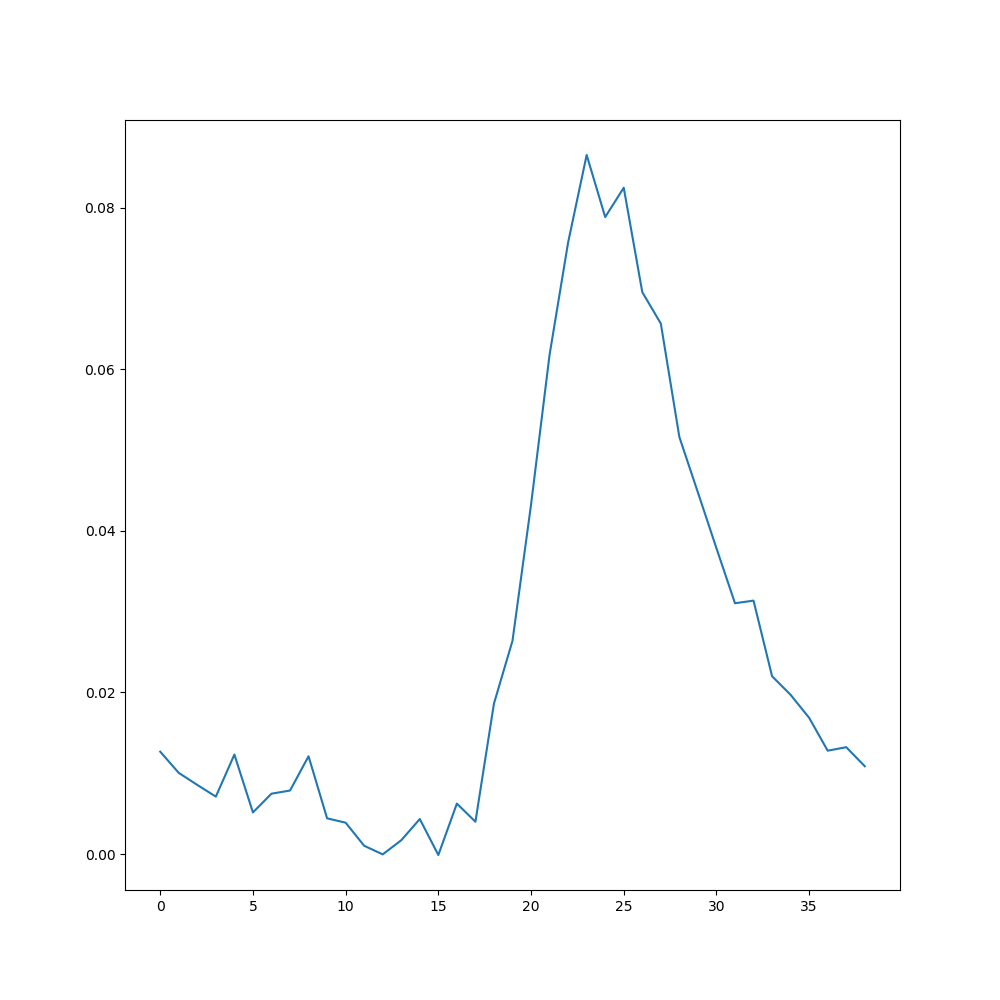

[0.3384807362345968, 0.3427682737169518, 0.34621053448142114, 0.3491706712137653, 0.35165260469076554, 0.3559820461228912, 0.35781515198271874, 0.3604875414641672, 0.3633207314250443, 0.3677175088857982, 0.3693422777392243, 0.3707761147970992, 0.3711554767594234, 0.3711403711403711, 0.3717741314228488, 0.37338461538461537, 0.3733404957409255, 0.375671115201718, 0.3771734967445423, 0.3841976441792872, 0.3943381790359602, 0.4113875744161197, 0.43680878651514, 0.4698712577131104, 0.5105198963256594, 0.5507643166780744, 0.5961801856642824, 0.6376393840552226, 0.6794998105342933, 0.7145670782516476, 0.7465416887141886, 0.7747924528301887, 0.7988401867751167, 0.8238932046157327, 0.8420221169036335, 0.8586139506915214, 0.8730884557721139, 0.8842554465823164, 0.8959485722828524, 0.9056843679880328]
[0.012667005898330919, 0.01004253027020785, 0.008550105896627525, 0.007108081180967174, 0.012311700167649375, 0.0051494334610198145, 0.007468631405462611, 0.007859328367825658, 0.01210164210423259, 

In [11]:
## Displaying cycle efficiency from fluo data
display(data.head(2))
plt.figure(figsize=(10, 10))
f = data.loc["S43-A01", cycles_col].tolist()
print(f)
e = [f[x]/f[x-1] - 1 for x in range(1, 40)]
print(e)
sns.lineplot(range(39), e)

0     1     2     3     4     5     6     7     8     9  ...  \
WellID                                                               ...   
S43-A01  6663  6702  6750  6789  6838  6878  6917  6955  6997  7040  ...   
S43-A02  6882  6919  6974  7029  7079  7127  7180  7225  7279  7327  ...   
S43-A03  6929  6981  7044  7090  7156  7186  7243  7287  7340  7385  ...   
S43-A04  7000  7046  7101  7151  7226  7266  7313  7366  7421  7467  ...   
S43-A05  7075  7112  7180  7243  7308  7354  7409  7459  7520  7565  ...   

            30     31     32     33     34     35     36     37     38     39  
WellID                                                                         
S43-A01  12198  12586  12931  13251  13515  13753  13970  14146  14311  14445  
S43-A02  13380  13829  14219  14577  14919  15150  15440  15654  15877  16043  
S43-A03  13492  13987  14384  14763  15089  15394  15668  15883  16107  16287  
S43-A04  14050  14535  14984  15374  15707  16022  16314  16544  16757  16949  
S43-A05  14363  14894  15363  15756  16124  16457  16717  16968  17174  17370  

[5 rows x 40 columns]

[6663, 6702, 6750, 6789, 6838, 6878, 6917, 6955, 6997, 7040, 7073, 7089, 7099, 7101, 7107, 7127, 7149, 7183, 7217, 7304, 7439, 7678, 8018, 8466, 8997, 9556, 10143, 10717, 11271, 11757, 12198, 12586, 12931, 13251, 13515, 13753, 13970, 14146, 14311, 14445]
6663
[   0   39   87  126  175  215  254  292  334  377  410  426  436  438
  444  464  486  520  554  641  776 1015 1355 1803 2334 2893 3480 4054
 4608 5094 5535 5923 6268 6588 6852 7090 7307 7483 7648 7782]
[inf, 1.2307692307692308, 0.4482758620689655, 0.38888888888888884, 0.22857142857142865, 0.1813953488372093, 0.14960629921259838, 0.14383561643835607, 0.12874251497005984, 0.08753315649867366, 0.039024390243902474, 0.023474178403755763, 0.004587155963302836, 0.013698630136986356, 0.04504504504504503, 0.047413793103448176, 0.06995884773662553, 0.06538461538461537, 0.15703971119133575, 0.21060842433697347, 0.3079896907216495, 0.3349753694581281, 0.3306273062730627, 0.29450915141430944, 0.2395029991431019, 0.20290356031800894, 0.16494

/users/biocomp/bahin/miniconda3/envs/Env_conda_qPCR/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':


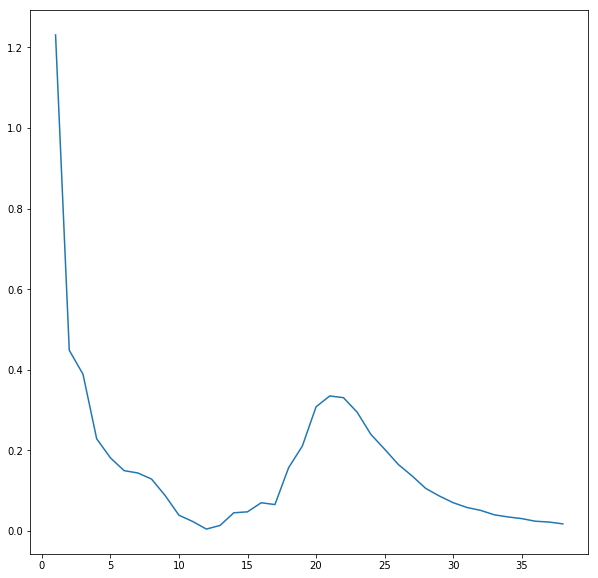

In [48]:
## Displaying cycle efficiency from FAM data
dataset = pd.read_csv("/data/biocomp/bahin/FAM.tsv", sep="\t")
dataset.set_index("WellID", inplace=True)
display(dataset.head())
#print(data.loc[:, cycles_col].iloc[0])
plt.figure(figsize=(10, 10))
#sns.lineplot(range(40), dataset.loc["S43-A01", :])
f = dataset.loc["S43-A01", :].tolist()
print(f)
print(min(f))
f2 = np.array(f) - min(f)
print(f2)
e = [f2[x]/f2[x-1] - 1 for x in range(1, 40)]
print(e)
sns.lineplot(range(39), e)

Predicted_N0_log accuracy: 78.4%
Predicted_N0_log accuracy: 88.4%
Predicted_N0_log accuracy: 82.8%
Predicted_N0_log accuracy: 88.3%
Predicted_N0_log accuracy: 88.1%
Predicted_N0_log accuracy: 87.9%
Predicted_N0_log accuracy: 88.1%
Predicted_N0_log accuracy: 80.6%
Predicted_N0_log accuracy: 58.3%
Predicted_N0_log accuracy: 80.4%
Predicted_N0_log accuracy: 73.4%
Predicted_N0_log accuracy: 91.2%
Predicted_N0_log accuracy: 92.2%
Predicted_N0_log accuracy: 92.3%
Predicted_N0_log accuracy: 90.1%
Predicted_N0_log accuracy: 77.0%
Predicted_N0_log accuracy: 75.7%
Predicted_N0_log accuracy: 91.0%
Predicted_N0_log accuracy: 87.4%
Predicted_N0_log accuracy: 72.4%
Predicted_N0_log accuracy: 67.4%
Predicted_N0_log accuracy: 91.0%
Predicted_N0_log accuracy: 51.1%
Predicted_N0_log accuracy: 91.2%
Predicted_N0_log accuracy: 89.1%
Predicted_N0_log accuracy: 92.4%
Predicted_N0_log accuracy: 92.2%
Predicted_N0_log accuracy: 92.4%
Predicted_N0_log accuracy: 52.9%
Predicted_N0_log accuracy: 92.3%
Predicted_

(array([ 1.,  0.,  2.,  2.,  1.,  2.,  4.,  6.,  4., 28.]),
 array([0.39227409, 0.44546606, 0.49865802, 0.55184999, 0.60504195,
        0.65823392, 0.71142588, 0.76461785, 0.81780981, 0.87100178,
        0.92419374]),
 <a list of 10 Patch objects>)

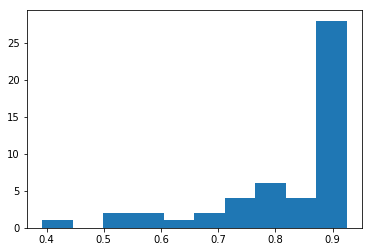

In [6]:
## Testing whether I can have a good error rate (comparing 2 curves) with a plan defined by 3 points
import numpy as np
from multiprocessing import Pool
import random

# Setting the dataset
dataset = data.loc[(data.Sigmoid_curve) & (data.Pre_amplification == 0) & (data.Gene != "Notch1a") & ~((data.Gene == "Crabp2a") & (data.S_or_C == "PC")) & ~((data.Gene == "BMP4") & (data.S_or_C == "PC")), :].copy()

def get_error_rate(x):
    # Getting 3 random points
    df = dataset.sample(n=3, random_state=x)
    #display(df)
    p1, p2, p3 = df.loc[:, ["P_c_final_Gompertz_with_bump", "P_d_final_Gompertz_with_bump", "Theoretical_N0_log"]].to_numpy()
    # Getting two vectors in the plane
    v1 = p3 - p1
    v2 = p2 - p1
    # Getting the cross product that is normal to the plane
    cp = np.cross(v1, v2)
    a, b, c = cp

    # Predicting the N0s
    dataset.loc[:, "Predicted_N0_log"] = (dataset.loc[:, "P_c_final_Gompertz_with_bump"]*cp[0] + dataset.loc[:, "P_d_final_Gompertz_with_bump"]*cp[1] - np.dot(cp, p1))/(-1*cp[2])
    #display(dataset.loc[:, ["Theoretical_N0_log", "Predicted_N0_log"]].head())
    pairs = compare_feat(dataset, "Predicted_N0_log")
    return pairs.loc[pairs.Feat_status, :].shape[0] / pairs.shape[0]

# Running the function several times in parallell
pool = Pool(processes=50)
test = [random.randrange(1, 5000, 1) for i in range(50)]
res = pool.map(get_error_rate, test)

# Displaying the results
plt.hist(res)

0.8072393484759586


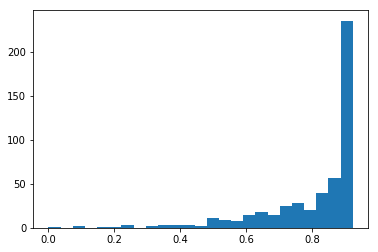

In [23]:
plt.hist(res, bins=25)
print(sum(res) / len(res))

Predicted_N0_log accuracy: 92.0%
Predicted_N0_log accuracy: 85.6%
Predicted_N0_log accuracy: 92.4%
Predicted_N0_log accuracy: 80.7%
Predicted_N0_log accuracy: 75.9%
Predicted_N0_log accuracy: 90.2%
Predicted_N0_log accuracy: 91.6%
Predicted_N0_log accuracy: 90.9%
Predicted_N0_log accuracy: 92.3%
Predicted_N0_log accuracy: 87.5%
Predicted_N0_log accuracy: 92.1%
Predicted_N0_log accuracy: 92.1%
Predicted_N0_log accuracy: 92.1%
Predicted_N0_log accuracy: 74.3%
Predicted_N0_log accuracy: 73.6%
Predicted_N0_log accuracy: 53.5%
Predicted_N0_log accuracy: 91.6%
Predicted_N0_log accuracy: 90.4%
Predicted_N0_log accuracy: 92.2%
Predicted_N0_log accuracy: 91.9%
Predicted_N0_log accuracy: 92.2%
Predicted_N0_log accuracy: 79.9%
Predicted_N0_log accuracy: 52.8%
Predicted_N0_log accuracy: 91.1%
Predicted_N0_log accuracy: 91.5%
Predicted_N0_log accuracy: 57.0%
Predicted_N0_log accuracy: 88.6%
Predicted_N0_log accuracy: 88.0%
Predicted_N0_log accuracy: 84.6%
Predicted_N0_log accuracy: 88.0%
Predicted_

Predicted_N0_log accuracy: 91.9%
Predicted_N0_log accuracy: 88.8%
Predicted_N0_log accuracy: 92.4%
Predicted_N0_log accuracy: 87.6%
Predicted_N0_log accuracy: 64.4%
Predicted_N0_log accuracy: 91.0%
Predicted_N0_log accuracy: 91.9%
Predicted_N0_log accuracy: 90.5%
Predicted_N0_log accuracy: 91.3%
Predicted_N0_log accuracy: 88.6%
Predicted_N0_log accuracy: 92.0%
Predicted_N0_log accuracy: 88.4%
Predicted_N0_log accuracy: 92.4%
Predicted_N0_log accuracy: 68.0%
Predicted_N0_log accuracy: 91.8%
Predicted_N0_log accuracy: 71.5%
Predicted_N0_log accuracy: 81.3%
Predicted_N0_log accuracy: 91.9%
Predicted_N0_log accuracy: 92.4%
Predicted_N0_log accuracy: 87.2%
Predicted_N0_log accuracy: 90.6%
Predicted_N0_log accuracy: 92.4%
Predicted_N0_log accuracy: 91.9%
Predicted_N0_log accuracy: 88.7%
Predicted_N0_log accuracy: 81.8%
Predicted_N0_log accuracy: 91.9%
Predicted_N0_log accuracy: 69.4%
Predicted_N0_log accuracy: 81.6%
Predicted_N0_log accuracy: 84.0%
Predicted_N0_log accuracy: 50.9%
Predicted_

Predicted_N0_log accuracy: 86.6%
Predicted_N0_log accuracy: 92.4%


(array([  5.,   1.,   3.,   9.,  10.,   8.,  32.,  29.,  64., 339.]),
 array([0.50902411, 0.55054154, 0.59205897, 0.6335764 , 0.67509383,
        0.71661126, 0.75812868, 0.79964611, 0.84116354, 0.88268097,
        0.9241984 ]),
 <a list of 10 Patch objects>)

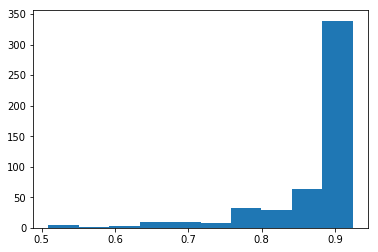

In [31]:
## Fitting a plane to 4 points (https://stackoverflow.com/questions/20699821/find-and-draw-regression-plane-to-a-set-of-points/44315297)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scipy.optimize
import functools
from multiprocessing import Pool
import random

# Setting the dataset
dataset = data.loc[(data.Sigmoid_curve) & (data.Pre_amplification == 0) & (data.Gene != "Notch1a") & ~((data.Gene == "Crabp2a") & (data.S_or_C == "PC")) & ~((data.Gene == "BMP4") & (data.S_or_C == "PC")), :].copy()

def get_error_rate(x):
    # Getting 3 random points
    df = dataset.sample(n=4, random_state=x)
    #display(df)
    p1, p2, p3, p4 = df.loc[:, ["P_c_final_Gompertz_with_bump", "P_d_final_Gompertz_with_bump", "Theoretical_N0_log"]].to_numpy()
    points = np.array([p1, p2, p3, p4])    # Getting two vectors in the plane
    
    fun = functools.partial(error, points=points)
    params0 = [0, 0, 0]
    res = scipy.optimize.minimize(fun, params0)

    dataset.loc[:, "Predicted_N0_log"] = res.x[0] * dataset.loc[:, "P_c_final_Gompertz_with_bump"] + res.x[1] * dataset.loc[:, "P_d_final_Gompertz_with_bump"] + res.x[2]
    pairs = compare_feat(dataset, "Predicted_N0_log")
    return pairs.loc[pairs.Feat_status, :].shape[0] / pairs.shape[0]

# Running the function several times in parallell
pool = Pool(processes=50)
test = [random.randrange(1, 5000, 1) for i in range(500)]
res = pool.map(get_error_rate, test)

# Displaying the results
plt.hist(res)

0.8749868503152386


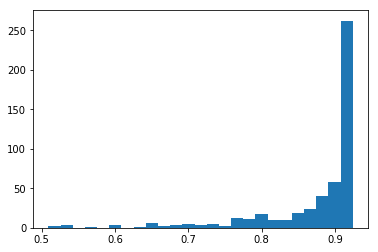

In [38]:
plt.hist(res, bins=25)
print(np.mean(res))

In [29]:
## Fitting a plane to 4 points (https://stackoverflow.com/questions/20699821/find-and-draw-regression-plane-to-a-set-of-points/44315297)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scipy.optimize
import functools

def plane(x, y, params):
    a = params[0]
    b = params[1]
    c = params[2]
    z = a*x + b*y + c
    return z

def error(params, points):
    result = 0
    for (x,y,z) in points:
        plane_z = plane(x, y, params)
        diff = abs(plane_z - z)
        result += diff**2
    return result

df = dataset.sample(n=4)
p1, p2, p3, p4 = df.loc[:, ["P_c_final_Gompertz_with_bump", "P_d_final_Gompertz_with_bump", "Theoretical_N0_log"]].to_numpy()
points = np.array([p1, p2, p3, p4])

fun = functools.partial(error, points=points)
params0 = [0, 0, 0]
res = scipy.optimize.minimize(fun, params0)

dataset.loc[:, "Predicted_N0_log"] = res.x[0] * dataset.loc[:, "P_c_final_Gompertz_with_bump"] + res.x[1] * dataset.loc[:, "P_d_final_Gompertz_with_bump"] + res.x[2]
display(df[["Theoretical_N0_log", "Predicted_N0_log"]].head(2))
pairs = compare_feat(dataset, "Predicted_N0_log")

Theoretical_N0_log  Predicted_N0_log
WellID                                       
S02-A62            5.274292          4.826192
S01-A79            6.274292          5.910201

Predicted_N0_log accuracy: 92.1%


In [24]:
## Computing 1 vs 2 ratios
#p1_TN0_log = dataset.loc[(dataset.Gene == "RPL13a1") & (dataset.Condition == "PS1"), "Theoretical_N0_log"].values
#p2_TN0_log = dataset.loc[(dataset.Gene == "BMP4") & (dataset.Condition == "PS4"), "Theoretical_N0_log"].values
#display(p1_TN0_log / p2_TN0_log)
combs.loc[:, "Theoretical_N0_log_ratio"] = combs.apply(lambda row: np.mean(dataset.loc[(dataset.Gene == row.Gene_1) & (dataset.Condition == row.Condition_1), "Theoretical_N0_log"].values / dataset.loc[(dataset.Gene == row.Gene_2) & (dataset.Condition == row.Condition_2), "Theoretical_N0_log"].values), axis=1)
#display(combs.head())

# Computing Predicted N0 ratio
#p1_pN0 = dataset.loc[(dataset.Gene == "RPL13a1") & (dataset.Condition == "PS1"), "Predicted_N0"].values
#p2_pN0 = dataset.loc[(dataset.Gene == "BMP4") & (dataset.Condition == "PS4"), "Predicted_N0"].values
#display(np.mean(p1_pN0 / p2_pN0))
combs.loc[:, "Predicted_N0_ratio"] = combs.apply(lambda row: np.mean(dataset.loc[(dataset.Gene == row.Gene_1) & (dataset.Condition == row.Condition_1), "Predicted_N0"].values / dataset.loc[(dataset.Gene == row.Gene_2) & (dataset.Condition == row.Condition_2), "Predicted_N0"].values), axis=1)
#display(combs.head())

#p1_FCt = dataset.loc[(dataset.Gene == "RPL13a1") & (dataset.Condition == "PS1"), "Fluidigm_Ct"].values
#p2_FCt = dataset.loc[(dataset.Gene == "BMP4") & (dataset.Condition == "PS4"), "Fluidigm_Ct"].values
#display(p2_FCt / p1_FCt)
combs.loc[:, "Fluidigm_Ct_ratio"] = combs.apply(lambda row: np.mean(dataset.loc[(dataset.Gene == row.Gene_2) & (dataset.Condition == row.Condition_2), "Fluidigm_Ct"].values / dataset.loc[(dataset.Gene == row.Gene_1) & (dataset.Condition == row.Condition_1), "Fluidigm_Ct"].values), axis=1)
#display(combs.head())

#p1_TN0 = dataset.loc[(dataset.Gene == "RPL13a1") & (dataset.Condition == "PS1"), "Theoretical_N0"].values
#p2_TN0 = dataset.loc[(dataset.Gene == "BMP4") & (dataset.Condition == "PS4"), "Theoretical_N0"].values
#display(p1_TN0 / p2_TN0)
combs.loc[:, "Theoretical_N0_ratio"] = combs.apply(lambda row: np.mean(dataset.loc[(dataset.Gene == row.Gene_1) & (dataset.Condition == row.Condition_1), "Theoretical_N0"].values / dataset.loc[(dataset.Gene == row.Gene_2) & (dataset.Condition == row.Condition_2), "Theoretical_N0"].values), axis=1)
display(combs.head())

Gene_1 Condition_1  key    Gene_2 Condition_2  Theoretical_N0_log_ratio  \
2  RPL13a1         PS1    0  Bactine2         PS1                  0.999796   
3  RPL13a1         PS1    0      BMP4         PS1                  1.000406   
4  RPL13a1         PS1    0   Crabp2a         PS1                  0.999881   
5  RPL13a1         PS1    0    DeltaC         PS1                  0.999677   
6  RPL13a1         PS1    0    DeltaD         PS1                  1.000203   

   Predicted_N0_ratio  Fluidigm_Ct_ratio  Theoretical_N0_ratio  
2            1.143882           1.288920              0.997060  
3            0.953781           0.948078              1.005879  
4            0.924479           0.771878              0.998285  
5            0.989078           1.018418              0.995345  
6            0.953659           0.922503              1.002940

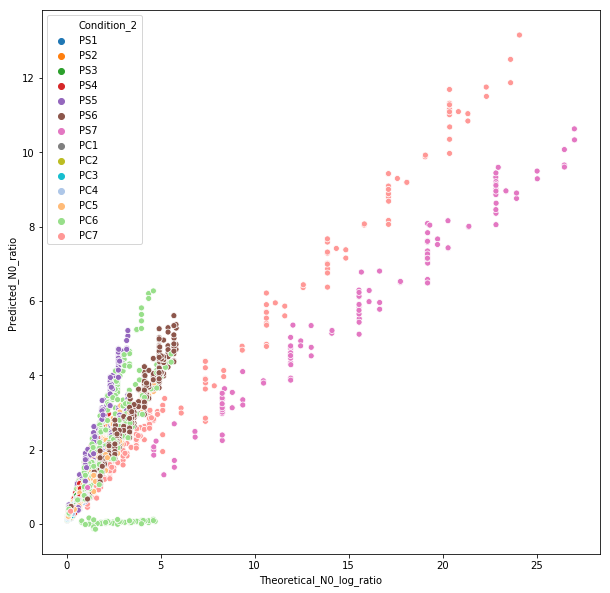

In [291]:
#combs.plot.scatter(x="Theoretical_N0_log_ratio", y="Predicted_N0_ratio")
plt.figure(figsize=(10, 10))
g = sns.scatterplot(x="Theoretical_N0_log_ratio", y="Predicted_N0_ratio", hue="Condition_2", data=combs, palette=HiFit_colormap)
#g.set(xlim=(0, 10), ylim=(0, 6))

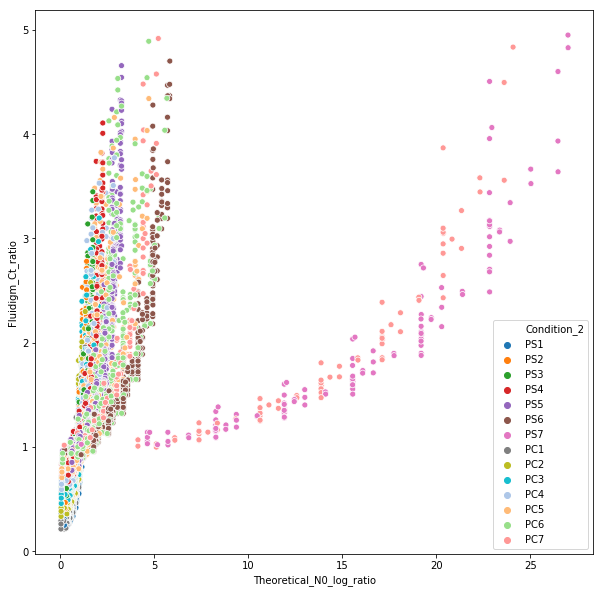

In [292]:
plt.figure(figsize=(10, 10))
g = sns.scatterplot(x="Theoretical_N0_log_ratio", y="Fluidigm_Ct_ratio", hue="Condition_2", data=combs, palette=HiFit_colormap)

In [57]:
display(combs.loc[(combs.Gene_2 == "Her7") & (combs.Condition_2 == "PC7"), :].head())
display(dataset.loc[(dataset.Gene == "Her7") & (dataset.Condition == "PC7"), "Theoretical_N0_log"])
display(dataset.loc[(dataset.Gene == "RPL13a1") & (dataset.Condition == "PS1"), "Theoretical_N0_log"])

Gene_1 Condition_1  key Gene_2 Condition_2  Theoretical_N0_log_ratio  \
148   RPL13a1         PS1    0   Her7         PC7                 20.361009   
297   RPL13a2         PS1    0   Her7         PC7                 20.370710   
1489   Hoxa1a         PS1    0   Her7         PC7                 20.361700   
1638   Hoxb1b         PS1    0   Her7         PC7                 20.361700   
1787   Hoxd4a         PS1    0   Her7         PC7                 20.361700   

      Predicted_N0_ratio  Fluidigm_Ct_ratio  Theoretical_N0_ratio  
148            11.011304           3.100442         924564.937304  
297            10.682282           3.049112         930950.684281  
1489           11.319817           2.947853         925018.155410  
1638           11.691285           3.059964         925018.155410  
1787           11.159058           3.869223         925018.155410

WellID
S55-A55    0.308142
S55-A56    0.308142
S55-A57    0.308142
S55-A58    0.308142
S55-A59    0.308142
S55-A60    0.308142
Name: Theoretical_N0_log, dtype: float64

WellID
S01-A01    6.274079
S01-A02    6.274079
S01-A03    6.274079
S01-A04    6.274079
S01-A05    6.274079
S01-A06    6.274079
Name: Theoretical_N0_log, dtype: float64

In [9]:
def second_derivative(fx):
    ''' Computes the second derivative of a function.
    In our case, the input is a np.array containing the fluorescence value of a qPCR curve.
    The output is a np.array of the second derivative of the input.
    '''
    df = [0] + [fx[i]-fx[i-1] for i in range(1, len(fx))]
    ddf = [0, 0] + [df[i]-df[i-1] for i in range(2, len(df))]
    return ddf


def max_second_derivative_smart(fx):
    ''' Computes the second derivative of a function.
    In our case, the input is a np.array containing the fluorescence value of a qPCR curve.
    The output is a np.array of the second derivative of the input.
    '''
    ddf = [0, 0] + [fx[i + 2] - 2 * fx[i] + fx[i - 2] for i in range(2, len(fx) - 2)] + [0, 0]
    return np.argmax(ddf)


def max_second_derivative(fx):
    ''' Returns the maximum of a np.array.
    In our case, the input is a np.array containing the second derivative of qPCR curves.
    The output is the index of the maximum in the input, it should correspond to the first point in the qPCR exponential phase.
    '''
    return np.argmax(second_derivative(fx))

In [59]:
## Getting the max second derivative
wellID = "S03-A59"
fluo = dataset.loc[wellID, cycles_col]
#display(fluo)
areas, cycle, area = area_under_chord_pd(fluo)
print(areas, cycle, area)
#plt.plot(areas)
f = ["F" + str(x).zfill(2) for x in range(cycle - 5, cycle + 5)]
#display(fluo.loc[:, ["F" + str(x).zfill(2) for x in range(cycle - 5, cycle +5)]])
display(dataset.loc["S03-A59", f])

#print(max_second_derivative(dataset.loc[wellID, f]) + cycle - 6)
#plt.plot(dataset.loc[wellID, f])
#plt.plot(second_derivative(dataset.loc[wellID, f]))
print(max_second_derivative_smart(dataset.loc[wellID, f]) + cycle - 5)

NameError: name 'dataset' is not defined

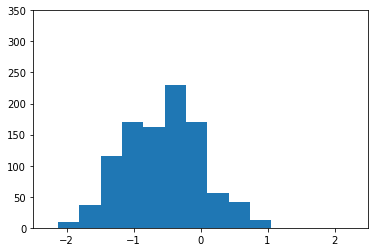

In [174]:
## Checking whether my rising cycle is close to the Fluidigm Ct
def get_new_rising_cycle(row):
    fluo = row[cycles_col]
    cycle = area_under_chord_pd(fluo)[1]
    f = ["F" + str(x).zfill(2) for x in range(cycle - 5, cycle + 5)]
    return max_second_derivative_smart(row[f]) + cycle - 5

# Adding the new rising cycle to the dataset
dataset.loc[:, "Rising_cycle_new"] = dataset.apply(lambda row: get_new_rising_cycle(row), axis=1)

df = dataset.loc[:, ["Fluidigm_Ct", "Rising_cycle", "Rising_cycle_new"]]
df.loc[:, "Diff"] = df["Fluidigm_Ct"] - df["Rising_cycle"]
df.loc[:, "Diff_new"] = df["Fluidigm_Ct"] - df["Rising_cycle_new"]
#display(df.loc[df["Diff"].idxmax(), :])
#diff = df["Diff"].to_list()
#plt.hist(diff)
#display(df.loc[df["Diff"].idxmin(), :])
diff_new = df["Diff_new"].to_list()
plt.xlim(-2.5, 2.5)
plt.ylim(0, 350)
plt.hist(diff_new)
df.to_csv("/data/biocomp/bahin/tmp.tsv", sep="\t")

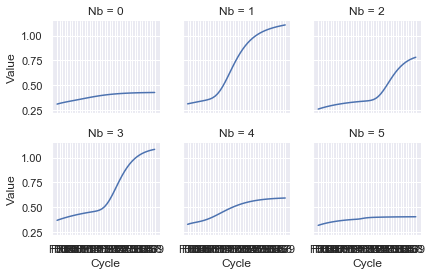

In [12]:
## Displaying IPS curves (WARNING NEW EQUATION FROM IMPORT)
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns

# Loading data
dir = "/users/biocomp/bahin/Mounted_dir/data_bioclust/qPCR/Research_plate/Fixed_keys/"
df = pd.read_csv(dir + "IPS.tsv", sep="\t")
df["Nb"] = df.index
#display(df.head())

# Computing the fluo values
params = ["P_" + letter + "_Gompertz_with_bump" for letter in list(string.ascii_lowercase)[0:Gompertz_with_bump.__code__.co_argcount - 1]]
df[cycles_col] = df.apply(lambda row: Gompertz_with_bump(np.array(range(40)), *row[params]), axis=1, result_type="expand")
#display(df.head())

# Preparing the plot
df2 = pd.melt(df, id_vars="Nb", value_vars=cycles_col, var_name="Cycle", value_name="Value")
#display(df2.head())

g = sns.FacetGrid(df2, col="Nb", col_wrap=3, height=2)
g = (g.map_dataframe(sns.lineplot, "Cycle", "Value").add_legend())

<h1>Check fitting RSS and params</h1>

5.2710828749453126e-05 0.00024383512953637845 0.012231724944963836
(0, 67)


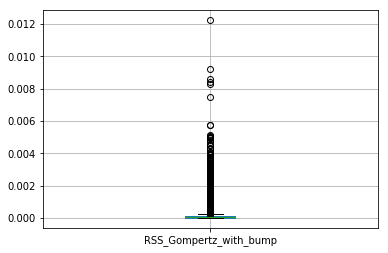

In [21]:
## Display RSS median, mean and distribution (boxplot)
import pandas as pd
import matplotlib.pyplot as plt

# Loading data
dir = "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/"
#dir = "/users/biocomp/bahin/Mounted_dir/data_bioclust/qPCR/Research_plate/Fixed_keys/"
#eq = "logistic4p_with_bump"
#eq = "logistic5p"
#eq = "logistic5p_with_bump"
#eq = "logistic5p_with_bump_log"
#eq = "logistic6p_with_bump"
#eq = "Gompertz"
eq = "Gompertz_with_bump"
#eq = "scf"
#eq = "scf_with_bump"
#eq = "Richards"
#eq = "Richards_with_bump"
#eq = "Boltzmann_LRE_with_bump"
#eq = "Hill_with_bump"
#eq = "scf_method_with_bump"
#df = pd.read_csv(dir + "final_data." + eq + ".REF.tsv", sep="\t", index_col=0)
df = pd.read_csv(dir + "final_data." + eq + ".tsv", sep="\t", index_col=0)
print(df.loc[df["RSS_" + eq] != 1, "RSS_" + eq].median(), df.loc[df["RSS_" + eq] != 1, "RSS_" + eq].mean(), df.loc[df["RSS_" + eq] != 1, "RSS_" + eq].max())
pd.DataFrame(df["RSS_" + eq]).boxplot()
print(df.loc[df["RSS_" + eq] == 1, :].shape)

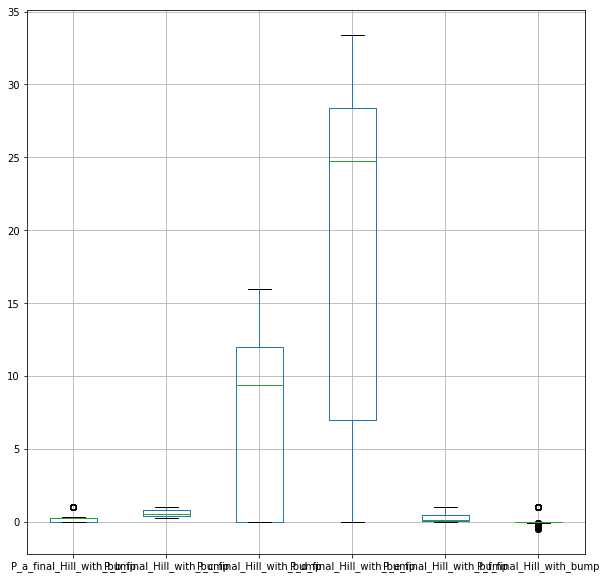

In [22]:
## Coronavirus local notebook version
import string
import matplotlib.pyplot as plt

def logistic4p_with_bump(x, minimum, maximum, F0, E, bump1, bump2):
    try:
        return bump1 - bump1 * np.exp(x * bump2) + minimum + (maximum - minimum) / (1 + ((((maximum - minimum) / F0) - 1) * np.power(E, -x)))
    except FloatingPointError:
        # If an error is raised, return a NaN vector so that it will not be used
        return np.repeat([np.nan], len(x))

def logistic5p_with_bump(x, minimum, maximum, IP, slope, f, bump1, bump2):
    try:
        return bump1 - bump1 * np.exp(x * bump2) + minimum + (maximum - minimum) / (np.power(1 + np.exp(slope * (x - IP)), f))
    except FloatingPointError:
        # If an error is raised, return a NaN vector so that it will not be used
        return np.repeat([np.nan], len(x))

def logistic6p_with_bump(x, minimum, maximum, F0, E, alpha, beta, bump1, bump2):
    ''' Equation of a six parameters sigmoid curve
    Input: "x" a integer or an np.array of integer(the index of a point of a qPCR curve), minimum/maximum/F0/E/alpha/beta a float
    Output: f(x) a float or an array of float, the image of x by the equation
    '''
    try:
        return bump1 - bump1 * np.exp(x * bump2) + minimum + (maximum - minimum) / (1 + ((((maximum - minimum) / F0) - 1) * np.power(E, -x)) + alpha * np.power((F0 * np.power(E, x)), -beta))
    except FloatingPointError:
        # If an error is raised, return a NaN vector so that it will not be used
        return np.repeat([np.nan], len(x))

def Gompertz_with_bump(x, minimum, maximum, c, d, bump1, bump2):
    try:
        return bump1 - bump1 * np.exp(x * bump2) + minimum + (maximum - minimum) * np.exp(-1 * np.exp(-d * (x - c)))
    except FloatingPointError:
        # If an error is raised, return a NaN vector so that it will not be used
        return np.repeat([np.nan], len(x))

def Richards(x, Fb, Fmax, c, b, d):
    try:
        return Fb + (Fmax / np.power(1 + np.exp((c - x) / b), d))
    except FloatingPointError:
        return np.repeat([0], len(x))

def Richards_with_bump(x, minimum, maximum, c, b, d, bump1, bump2):
    try:
        return bump1 - bump1 * np.exp(x * bump2) + minimum + (maximum / np.power(1 + np.exp((c - x) / b), d))
    except FloatingPointError:
        return np.repeat([np.nan], len(x))

def Boltzmann_LRE_with_bump(x, minimum, maximum, IP, slope, bump1, bump2):
    try:
        return bump1 - bump1 * np.exp(x * bump2) + minimum + maximum / (1 + np.exp(-1 * ((x - IP) / slope)))
    except FloatingPointError:
        # If an error is raised, return a NaN vector so that it will not be used
        return np.repeat([np.nan], len(x))

def scf_with_bump(x, minimum, maximum, c, b, bump1, bump2):
    try:
        return bump1 - bump1 * np.exp(x * bump2) + (maximum / (1 + np.exp(((-1) / b) * (x - c)))) + minimum
    except FloatingPointError:
        return np.repeat([np.nan], len(x))
"""
def Hill_with_bump(x, minimum, maximum, c, d, bump1, bump2):
    try:
        return bump1 - bump1 * np.exp(x * bump2) + minimum + (maximum * np.power(x, c)) / (np.power(d, c) + np.power(x, c))
    except FloatingPointError:
        return np.repeat([np.nan], len(x))
"""
def Hill_with_bump(x, bump1, bump2, minimum, maximum, c, d):
    try:
        return bump1 - bump1 * np.exp(x * bump2) + minimum + (maximum * np.power(x, c)) / (np.power(d, c) + np.power(x, c))
    except FloatingPointError:
        return np.repeat([np.nan], len(x))

#eq = logistic4p_with_bump
#eq = logistic5p
#eq = logistic5p_with_bump
#eq = logistic6p_with_bump
#eq = Boltzmann_LRE_with_bump
#eq = Gompertz_with_bump
#eq = Richards
#eq = Richards_with_bump
#eq = scf_with_bump
eq = Hill_with_bump
params = ["P_" + letter + "_final_" + eq.__name__ for letter in list(string.ascii_lowercase)[0:eq.__code__.co_argcount - 1]]
plt.figure(figsize=(10, 10))
#plt.ylim(-1, 3)
#print(df.loc[df.Sigmoid_curve, :].shape)
df1 = df.loc[df.Sigmoid_curve, :].copy()
pd.DataFrame(df[params]).boxplot()
#df2 = df.loc[~df.Sigmoid_curve, :].copy()
#pd.DataFrame(df2[params]).boxplot()

Ref_gene
Bactine2    0.104302
DeltaC      0.105164
DeltaD      0.114780
FGF8a       0.107858
Her7        0.152352
Hoxa1a      0.108129
Hoxa5a      0.106153
Hoxb1b      0.116120
Hoxd4a      0.105516
RPL13a1     0.106773
RPL13a2     0.106084
Rarab       0.106135
Name: Ct_method_ratio_diff, dtype: float64

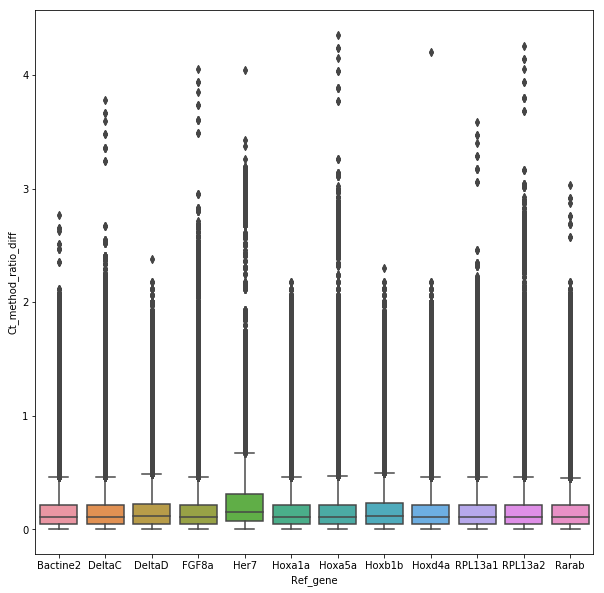

In [89]:
plt.figure(figsize=(10, 10))
sns.boxplot(x="Ref_gene", y="Ct_method_ratio_diff", data = df)

In [80]:
# Loading comparison dataset
filepath = "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/final_data.Richards_with_bump.REF.tsv"
raw_data = pd.read_csv(filepath, sep="\t", index_col=0)
#data = raw_data.loc[raw_data.Sigmoid_curve, :]  ## Not filtered figure
data = raw_data.loc[(raw_data.Sigmoid_curve) & (raw_data.Pre_amplification == 0) & (raw_data.Gene != "Notch1a") & ~((raw_data.Gene == "Crabp2a") & (raw_data.S_or_C == "PC")) & ~((raw_data.Gene == "BMP4") & (raw_data.S_or_C == "PC")), :].copy()
data = data.groupby(["Gene", "Condition"]).filter(lambda row: row["Sample"].count() == 6).copy()

Fluidigm_Ct Pearson correlation coef: -0.7540725580823588


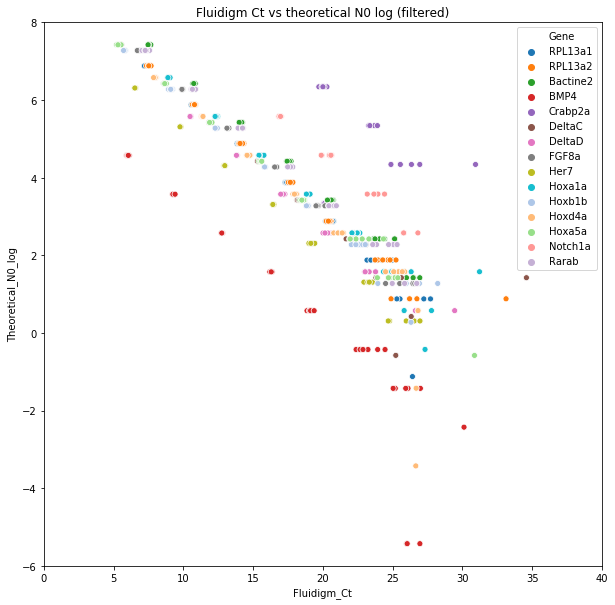

In [15]:
### Methods comparison ###
## Emulating Fluidigm Cq ##
# Fluidigm Cq #
import seaborn as sns

# Fluidigm_Ct Pearson correlation coef
print("Fluidigm_Ct Pearson correlation coef:", data["Theoretical_N0_log"].corr(data["Fluidigm_Ct"]))

dataset = data.loc[data.Sigmoid_curve & (data.Pre_amplification == 0) & (data.S_or_C == "PC"), :]

# Plotting
plt.figure(figsize=(10, 10))
plt.xlim(0, 40)
plt.ylim(-6, 8)
plt.title("Fluidigm Ct vs theoretical N0 log (filtered)")
sns.scatterplot(x="Fluidigm_Ct", y="Theoretical_N0_log", hue="Gene", palette=HiFit_colormap, data=dataset)

Rising cycle Pearson correlation coef: -0.9621898458312872


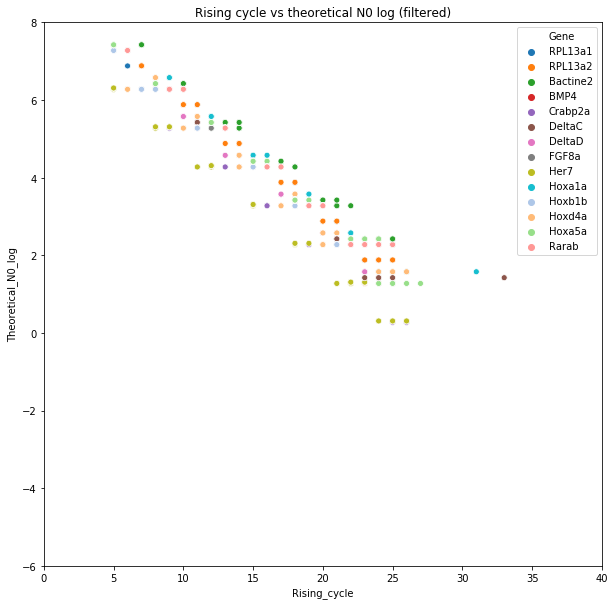

In [83]:
### Methods comparison ###
## Emulating Fluidigm Cq ##
# Rising cycle #
import seaborn as sns

# Fluidigm_Ct Pearson correlation coef
print("Rising cycle Pearson correlation coef:", data["Theoretical_N0_log"].corr(data["Rising_cycle"]))

# Plotting
plt.figure(figsize=(10, 10))
plt.xlim(0, 40)
plt.ylim(-6, 8)
plt.title("Rising cycle vs theoretical N0 log (filtered)")
sns.scatterplot(x="Rising_cycle", y="Theoretical_N0_log", hue="Gene", palette=HiFit_colormap, data=data)

Rising cycle new Pearson correlation coef: -0.9693559420031178


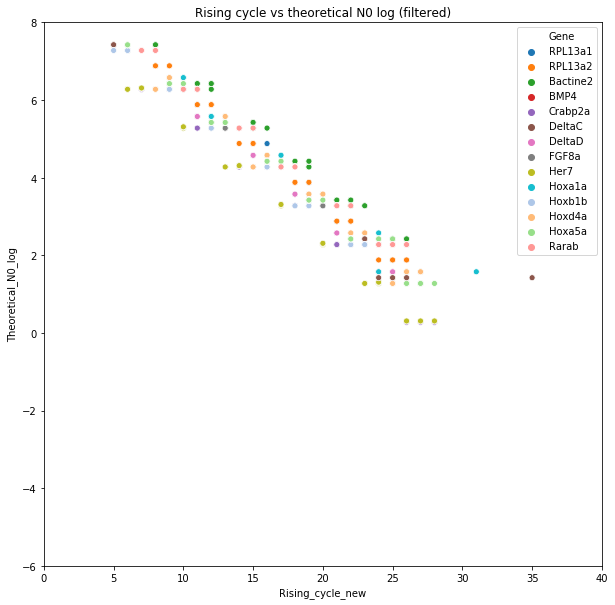

In [86]:
### Methods comparison ###
## Emulating Fluidigm Cq ##
# Rising cycle new #
import seaborn as sns

def get_new_rising_cycle(row):
    fluo = row[cycles_col]
    cycle = area_under_chord_pd(fluo)[1]
    f = ["F" + str(x).zfill(2) for x in range(cycle - 5, cycle + 5)]
    return max_second_derivative_smart(row[f]) + cycle - 5

# Adding the new rising cycle to the dataset
data.loc[:, "Rising_cycle_new"] = data.apply(lambda row: get_new_rising_cycle(row), axis=1)

# Fluidigm_Ct Pearson correlation coef
print("Rising cycle new Pearson correlation coef:", data["Theoretical_N0_log"].corr(data["Rising_cycle_new"]))

# Plotting
plt.figure(figsize=(10, 10))
plt.xlim(0, 40)
plt.ylim(-6, 8)
plt.title("Rising cycle vs theoretical N0 log (filtered)")
sns.scatterplot(x="Rising_cycle_new", y="Theoretical_N0_log", hue="Gene", palette=HiFit_colormap, data=data)

Unnamed: 0 WellID_1 Condition_1   Gene_1  Theoretical_N0_log_1  \
0           6  S01-A01         PS1  RPL13a1              6.274079   
1           7  S01-A01         PS1  RPL13a1              6.274079   

   Ct_method_N0_log_1  key WellID_2 Condition_2   Gene_2  \
0            7.077961    0  S01-A07         PS1  RPL13a2   
1            7.077961    0  S01-A08         PS1  RPL13a2   

   Theoretical_N0_log_2  Ct_method_N0_log_2  Ref_gene     Slope  Intercept  \
0              6.277069            6.792756  Bactine2 -0.285205   9.644806   
1              6.277069            6.792756  Bactine2 -0.285205   9.644806   

   Theoretical_N0_log_ratio  Ct_method_N0_log_ratio  Ct_method_ratio_diff  
0                 -0.000476                0.041129              0.041605  
1                 -0.000476                0.041129              0.041605

Ref_gene
Bactine2    0.104302
DeltaC      0.105164
DeltaD      0.114780
FGF8a       0.107858
Her7        0.152352
Hoxa1a      0.108129
Hoxa5a      0.106153
Hoxb1b      0.116120
Hoxd4a      0.105516
RPL13a1     0.106773
RPL13a2     0.106084
Rarab       0.106135
Name: Ct_method_ratio_diff, dtype: float64

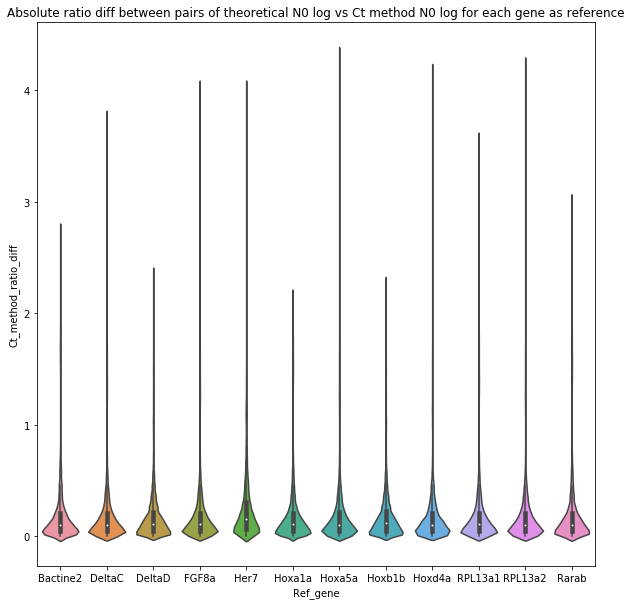

In [91]:
### The Ct method ###
## Choosing the reference gene ##
df = pd.read_csv("/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/Ct_method.pairs.ratio_diff.tsv", sep="\t")
display(df.head(2))
plt.figure(figsize=(10, 10))
plt.title("Absolute ratio diff between pairs of theoretical N0 log vs Ct method N0 log for each gene as reference")
sns.violinplot(x="Ref_gene", y="Ct_method_ratio_diff", data = df)
display(df.groupby("Ref_gene")["Ct_method_ratio_diff"].median())

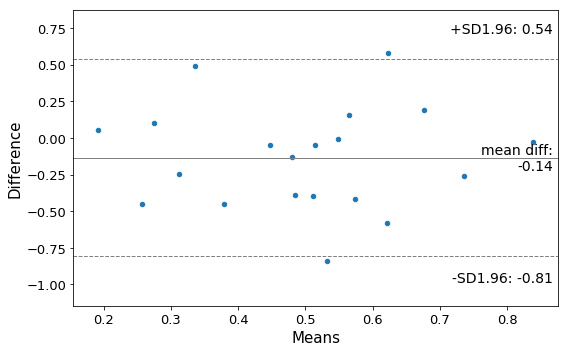

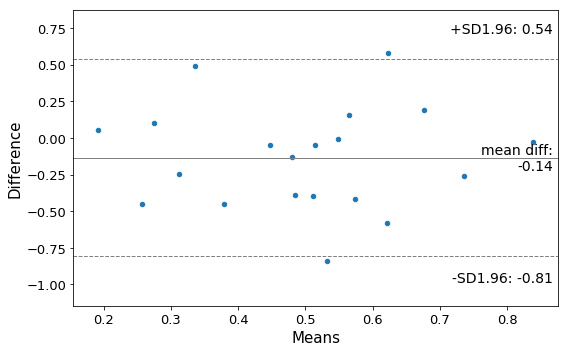

In [128]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

# Seed the random number generator.
# This ensures that the results below are reproducible.
np.random.seed(9999)
m1 = np.random.random(20)
m2 = np.random.random(20)

f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(m1, m2, ax = ax)

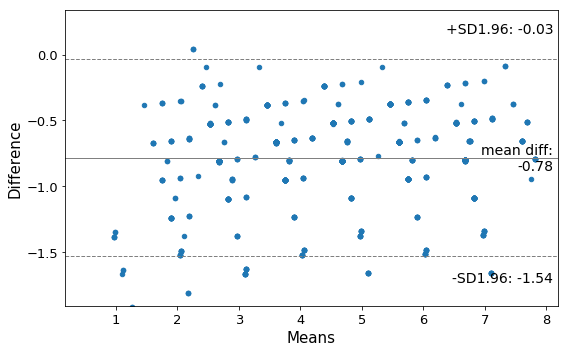

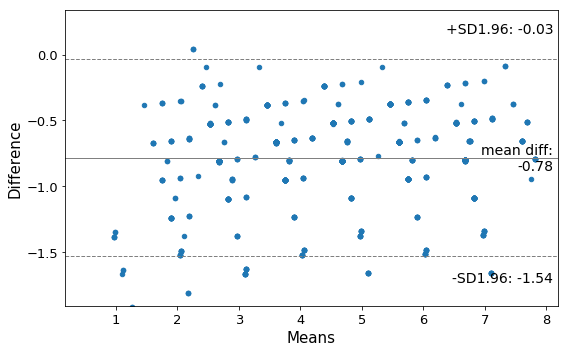

In [140]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("/data/biocomp/bahin/tmp.tsv", sep="\t")
#df2 = df.iloc[0:100, :]
#display(df2["Theoretical_N0_log"])

f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(df["Theoretical_N0_log"], df["Ct_method_N0_log"], ax = ax)

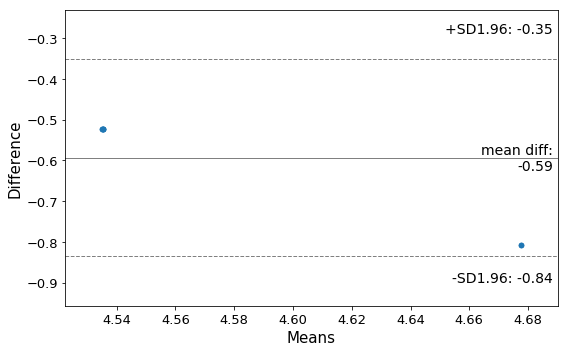

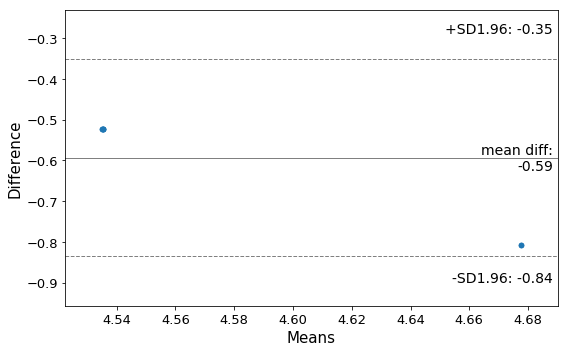

In [151]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("/data/biocomp/bahin/tmp.tsv", sep="\t")
df2 = df.loc[(df.Condition == "PS3") & (df.Gene.isin(["RPL13a1", "FGF8a"])), :].copy()

f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(df2["Theoretical_N0_log"], df2["Ct_method_N0_log"], ax = ax)

WellID Condition     Gene  Fluidigm_Ct  Sample  Assay       F00       F01  \
0  S01-A01       PS1  RPL13a1     8.491106       1      1  0.370476  0.375293   
1  S01-A02       PS1  RPL13a1     8.375671       1      2  0.351437  0.359487   

        F02       F03  ...  P_d_final_Richards_with_bump  \
0  0.379359  0.384355  ...                      5.135184   
1  0.363358  0.368100  ...                      3.923520   

   P_e_final_Richards_with_bump  P_f_final_Richards_with_bump  \
0                      9.234992                     -0.009303   
1                      2.479141                      0.177657   

   P_g_final_Richards_with_bump  RSS_Richards_with_bump  Rising_cycle_new  \
0                     -3.197203                0.001052                 9   
1                      0.015774                0.001501                 9   

   Ct_method_N0_log        Cy0    MescX     MescY  
0          7.077961  15.717766  6.67602 -0.803882  
1          7.077961  11.843858  6.67602 -0.803882  

[2 rows x 75 columns]

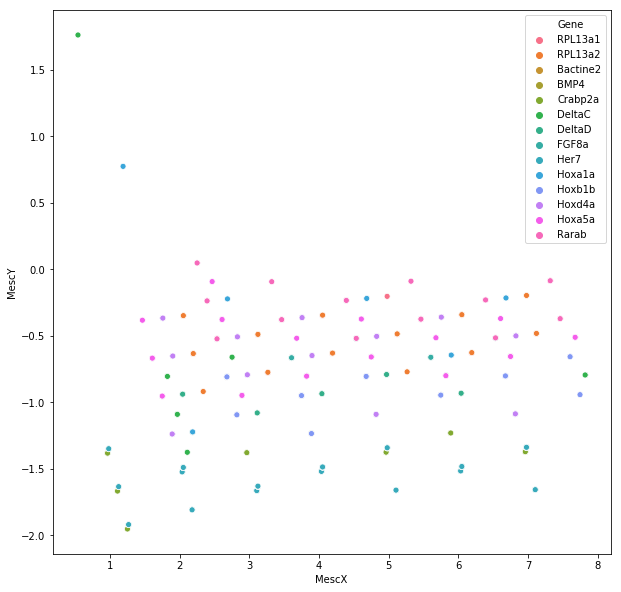

In [168]:
var = "Ct_method_N0_log"
#var = "Cy0"
df.loc[:, "MescX"] = (df["Theoretical_N0_log"] + df[var]) / 2
df.loc[:, "MescY"] = df["Theoretical_N0_log"] - df[var]
display(df.head(2))
plt.figure(figsize=(10, 10))
sns.scatterplot(x="MescX", y="MescY", data=df, hue="Gene")

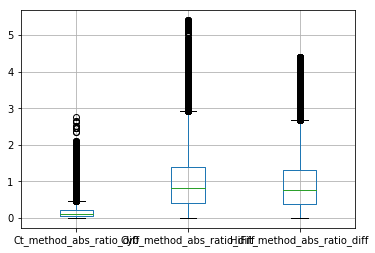

In [20]:
## Plotting the absolute ratio diff distribution
import pandas as pd

# Loading data
df = pd.read_csv("/data/biocomp/bahin/tmp.tsv", sep="\t")

# Displaying boxplots
df[["Ct_method_abs_ratio_diff", "Cy0_method_abs_ratio_diff", "HiFit_method_abs_ratio_diff"]].boxplot()

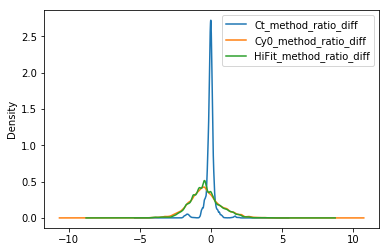

In [21]:
df[["Ct_method_ratio_diff", "Cy0_method_ratio_diff", "HiFit_method_ratio_diff"]].plot.kde()

In [285]:
from scipy import stats

def get_linear_regession_values(row, cycles):
    slope, intercept, r_value, p_value, std_err = stats.linregress(cycles, row[["F" + str(x).zfill(2) + "_log" for x in cycles]].tolist())
    return np.power(10, slope)

dataset = data.loc[(data.Gene == "RPL13a2") & (data.Condition == "PS3"), :].copy()
dataset.loc[:, "MSD"] = dataset.apply(lambda row: max_second_derivative(row[cycles_col_mod_Gwb]), axis=1)
dataset.loc[:, "MSD_gene_mean"] = dataset.groupby("Gene")["MSD"].agg("mean").values
dataset.loc[:, "Eff"] = dataset.apply(lambda row: get_linear_regession_values(row, list(range(int(row["MSD_gene_mean"] - 4), int(row["MSD_gene_mean"] + 1)))), axis=1)
display(dataset)

Condition     Gene  Fluidigm_Ct  Sample  Assay       F00       F01  \
WellID                                                                       
S03-A07       PS3  RPL13a2    16.307428       3      7  0.314015  0.320013   
S03-A08       PS3  RPL13a2    16.449197       3      8  0.306289  0.313225   
S03-A09       PS3  RPL13a2    16.316268       3      9  0.307854  0.313280   
S03-A10       PS3  RPL13a2    16.272253       3     10  0.313061  0.317582   
S03-A11       PS3  RPL13a2    16.319640       3     11  0.319062  0.325608   
S03-A12       PS3  RPL13a2    16.438059       3     12  0.343176  0.348832   

              F02       F03       F04  ...   F33_log   F34_log   F35_log  \
WellID                                 ...                                 
S03-A07  0.326308  0.332074  0.335465  ... -0.122778 -0.120789 -0.112777   
S03-A08  0.317288  0.325070  0.329350  ... -0.152336 -0.145244 -0.139346   
S03-A09  0.320692  0.324295  0.329362  ... -0.146647 -0.132224 -0.129862   
S03-A10  0.324384  0.331288  0.335669  ... -0.131638 -0.125103 -0.119490   
S03-A11  0.333157  0.338712  0.342525  ... -0.108983 -0.103859 -0.094534   
S03-A12  0.356957  0.360399  0.368014  ... -0.060479 -0.052695 -0.048281   

          F36_log   F37_log   F38_log   F39_log  MSD  MSD_gene_mean       Eff  
WellID                                                                         
S03-A07 -0.106429 -0.106444 -0.100805 -0.099933   17      17.833333  1.084089  
S03-A08 -0.132661 -0.128260 -0.126571 -0.124473   18      17.833333  1.082615  
S03-A09 -0.124191 -0.118522 -0.114977 -0.112757   18      17.833333  1.084499  
S03-A10 -0.113442 -0.112264 -0.107098 -0.103832   18      17.833333  1.085730  
S03-A11 -0.088042 -0.088514 -0.083272 -0.081069   18      17.833333  1.083069  
S03-A12 -0.041360 -0.036805 -0.033919 -0.029178   18      17.833333  1.072892  

[6 rows x 150 columns]

In [305]:
from scipy import stats

def get_linear_regession_values(row, cycles):
    slope, intercept, r_value, p_value, std_err = stats.linregress(cycles, row[["F" + str(x).zfill(2) + "_log" for x in cycles]].tolist())
    return np.power(10, slope)

dataset = data.loc[(data.Gene == "RPL13a2") & (data.Condition == "PS3"), :].copy()
dataset.loc[:, "MSD"] = dataset.apply(lambda row: max_second_derivative(row[cycles_col_mod_Gwb]), axis=1)
dataset.loc[:, "MSD_gene_mean"] = dataset.groupby("Gene")["MSD"].agg("mean").values

df = pd.DataFrame()
for upper in range(int(row["MSD_gene_mean"] - 2), int(row["MSD_gene_mean"])):
    #dataset.loc[:, "Eff"] = dataset.apply(lambda row: get_linear_regession_values(row, list(range(int(row["MSD_gene_mean"] - 4), int(row["MSD_gene_mean"] + 1)))), axis=1)
    s = dataset.apply(lambda row: get_linear_regession_values(row, list(range(upper - 4, upper + 1))), axis=1)
    display(s)
    df2 = pd.DataFrame(s)
    df2.loc[:, "Upper"] = upper
    df = pd.concat([df1, df2])
    display(df)
display(dataset)

WellID
S03-A07    1.030154
S03-A08    1.029678
S03-A09    1.030834
S03-A10    1.030877
S03-A11    1.029928
S03-A12    1.028039
dtype: float64

/users/biocomp/bahin/miniconda3/envs/Env_conda_qPCR/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Cycle           Type     Value   WellID         0  Upper
0          0.0  RPL13a1 - PS1 -0.992967  S01-A01       NaN    NaN
1          0.0  RPL13a1 - PS1 -1.045725  S01-A02       NaN    NaN
2          0.0  RPL13a1 - PS1 -1.003773  S01-A03       NaN    NaN
3          0.0  RPL13a1 - PS1 -1.051502  S01-A04       NaN    NaN
4          0.0  RPL13a1 - PS1 -1.060236  S01-A05       NaN    NaN
5          0.0  RPL13a1 - PS1 -1.118826  S01-A06       NaN    NaN
6          1.0  RPL13a1 - PS1 -0.980049  S01-A01       NaN    NaN
7          1.0  RPL13a1 - PS1 -1.023077  S01-A02       NaN    NaN
8          1.0  RPL13a1 - PS1 -0.989310  S01-A03       NaN    NaN
9          1.0  RPL13a1 - PS1 -1.030457  S01-A04       NaN    NaN
10         1.0  RPL13a1 - PS1 -1.039012  S01-A05       NaN    NaN
11         1.0  RPL13a1 - PS1 -1.103897  S01-A06       NaN    NaN
12         2.0  RPL13a1 - PS1 -0.969272  S01-A01       NaN    NaN
13         2.0  RPL13a1 - PS1 -1.012366  S01-A02       NaN    NaN
14         2.0  RPL13a1 - PS1 -0.974572  S01-A03       NaN    NaN
15         2.0  RPL13a1 - PS1 -1.013050  S01-A04       NaN    NaN
16         2.0  RPL13a1 - PS1 -1.024481  S01-A05       NaN    NaN
17         2.0  RPL13a1 - PS1 -1.086469  S01-A06       NaN    NaN
18         3.0  RPL13a1 - PS1 -0.956189  S01-A01       NaN    NaN
19         3.0  RPL13a1 - PS1 -0.999400  S01-A02       NaN    NaN
20         3.0  RPL13a1 - PS1 -0.956649  S01-A03       NaN    NaN
21         3.0  RPL13a1 - PS1 -1.002845  S01-A04       NaN    NaN
22         3.0  RPL13a1 - PS1 -1.004678  S01-A05       NaN    NaN
23         3.0  RPL13a1 - PS1 -1.070238  S01-A06       NaN    NaN
24         4.0  RPL13a1 - PS1 -0.941287  S01-A01       NaN    NaN
25         4.0  RPL13a1 - PS1 -0.982418  S01-A02       NaN    NaN
26         4.0  RPL13a1 - PS1 -0.939504  S01-A03       NaN    NaN
27         4.0  RPL13a1 - PS1 -0.985226  S01-A04       NaN    NaN
28         4.0  RPL13a1 - PS1 -0.988378  S01-A05       NaN    NaN
29         4.0  RPL13a1 - PS1 -1.051282  S01-A06       NaN    NaN
...        ...            ...       ...      ...       ...    ...
216       36.0  RPL13a1 - PS1  0.104651  S01-A01       NaN    NaN
217       36.0  RPL13a1 - PS1  0.148722  S01-A02       NaN    NaN
218       36.0  RPL13a1 - PS1  0.192862  S01-A03       NaN    NaN
219       36.0  RPL13a1 - PS1  0.173157  S01-A04       NaN    NaN
220       36.0  RPL13a1 - PS1  0.177513  S01-A05       NaN    NaN
221       36.0  RPL13a1 - PS1  0.119157  S01-A06       NaN    NaN
222       37.0  RPL13a1 - PS1  0.108350  S01-A01       NaN    NaN
223       37.0  RPL13a1 - PS1  0.153814  S01-A02       NaN    NaN
224       37.0  RPL13a1 - PS1  0.199671  S01-A03       NaN    NaN
225       37.0  RPL13a1 - PS1  0.177649  S01-A04       NaN    NaN
226       37.0  RPL13a1 - PS1  0.178845  S01-A05       NaN    NaN
227       37.0  RPL13a1 - PS1  0.121677  S01-A06       NaN    NaN
228       38.0  RPL13a1 - PS1  0.111506  S01-A01       NaN    NaN
229       38.0  RPL13a1 - PS1  0.154856  S01-A02       NaN    NaN
230       38.0  RPL13a1 - PS1  0.202943  S01-A03       NaN    NaN
231       38.0  RPL13a1 - PS1  0.180622  S01-A04       NaN    NaN
232       38.0  RPL13a1 - PS1  0.181037  S01-A05       NaN    NaN
233       38.0  RPL13a1 - PS1  0.123266  S01-A06       NaN    NaN
234       39.0  RPL13a1 - PS1  0.112598  S01-A01       NaN    NaN
235       39.0  RPL13a1 - PS1  0.157864  S01-A02       NaN    NaN
236       39.0  RPL13a1 - PS1  0.202362  S01-A03       NaN    NaN
237       39.0  RPL13a1 - PS1  0.182950  S01-A04       NaN    NaN
238       39.0  RPL13a1 - PS1  0.184558  S01-A05       NaN    NaN
239       39.0  RPL13a1 - PS1  0.124839  S01-A06       NaN    NaN
S03-A07    NaN            NaN       NaN      NaN  1.030154    8.0
S03-A08    NaN            NaN       NaN      NaN  1.029678    8.0
S03-A09    NaN            NaN       NaN      NaN  1.030834    8.0
S03-A10    NaN            NaN       NaN      NaN  1.030877    8.0
S03-A11    NaN            NaN       NaN      NaN 

WellID
S03-A07    1.028934
S03-A08    1.024677
S03-A09    1.027594
S03-A10    1.029982
S03-A11    1.028014
S03-A12    1.029364
dtype: float64

Cycle           Type     Value   WellID         0  Upper
0          0.0  RPL13a1 - PS1 -0.992967  S01-A01       NaN    NaN
1          0.0  RPL13a1 - PS1 -1.045725  S01-A02       NaN    NaN
2          0.0  RPL13a1 - PS1 -1.003773  S01-A03       NaN    NaN
3          0.0  RPL13a1 - PS1 -1.051502  S01-A04       NaN    NaN
4          0.0  RPL13a1 - PS1 -1.060236  S01-A05       NaN    NaN
5          0.0  RPL13a1 - PS1 -1.118826  S01-A06       NaN    NaN
6          1.0  RPL13a1 - PS1 -0.980049  S01-A01       NaN    NaN
7          1.0  RPL13a1 - PS1 -1.023077  S01-A02       NaN    NaN
8          1.0  RPL13a1 - PS1 -0.989310  S01-A03       NaN    NaN
9          1.0  RPL13a1 - PS1 -1.030457  S01-A04       NaN    NaN
10         1.0  RPL13a1 - PS1 -1.039012  S01-A05       NaN    NaN
11         1.0  RPL13a1 - PS1 -1.103897  S01-A06       NaN    NaN
12         2.0  RPL13a1 - PS1 -0.969272  S01-A01       NaN    NaN
13         2.0  RPL13a1 - PS1 -1.012366  S01-A02       NaN    NaN
14         2.0  RPL13a1 - PS1 -0.974572  S01-A03       NaN    NaN
15         2.0  RPL13a1 - PS1 -1.013050  S01-A04       NaN    NaN
16         2.0  RPL13a1 - PS1 -1.024481  S01-A05       NaN    NaN
17         2.0  RPL13a1 - PS1 -1.086469  S01-A06       NaN    NaN
18         3.0  RPL13a1 - PS1 -0.956189  S01-A01       NaN    NaN
19         3.0  RPL13a1 - PS1 -0.999400  S01-A02       NaN    NaN
20         3.0  RPL13a1 - PS1 -0.956649  S01-A03       NaN    NaN
21         3.0  RPL13a1 - PS1 -1.002845  S01-A04       NaN    NaN
22         3.0  RPL13a1 - PS1 -1.004678  S01-A05       NaN    NaN
23         3.0  RPL13a1 - PS1 -1.070238  S01-A06       NaN    NaN
24         4.0  RPL13a1 - PS1 -0.941287  S01-A01       NaN    NaN
25         4.0  RPL13a1 - PS1 -0.982418  S01-A02       NaN    NaN
26         4.0  RPL13a1 - PS1 -0.939504  S01-A03       NaN    NaN
27         4.0  RPL13a1 - PS1 -0.985226  S01-A04       NaN    NaN
28         4.0  RPL13a1 - PS1 -0.988378  S01-A05       NaN    NaN
29         4.0  RPL13a1 - PS1 -1.051282  S01-A06       NaN    NaN
...        ...            ...       ...      ...       ...    ...
216       36.0  RPL13a1 - PS1  0.104651  S01-A01       NaN    NaN
217       36.0  RPL13a1 - PS1  0.148722  S01-A02       NaN    NaN
218       36.0  RPL13a1 - PS1  0.192862  S01-A03       NaN    NaN
219       36.0  RPL13a1 - PS1  0.173157  S01-A04       NaN    NaN
220       36.0  RPL13a1 - PS1  0.177513  S01-A05       NaN    NaN
221       36.0  RPL13a1 - PS1  0.119157  S01-A06       NaN    NaN
222       37.0  RPL13a1 - PS1  0.108350  S01-A01       NaN    NaN
223       37.0  RPL13a1 - PS1  0.153814  S01-A02       NaN    NaN
224       37.0  RPL13a1 - PS1  0.199671  S01-A03       NaN    NaN
225       37.0  RPL13a1 - PS1  0.177649  S01-A04       NaN    NaN
226       37.0  RPL13a1 - PS1  0.178845  S01-A05       NaN    NaN
227       37.0  RPL13a1 - PS1  0.121677  S01-A06       NaN    NaN
228       38.0  RPL13a1 - PS1  0.111506  S01-A01       NaN    NaN
229       38.0  RPL13a1 - PS1  0.154856  S01-A02       NaN    NaN
230       38.0  RPL13a1 - PS1  0.202943  S01-A03       NaN    NaN
231       38.0  RPL13a1 - PS1  0.180622  S01-A04       NaN    NaN
232       38.0  RPL13a1 - PS1  0.181037  S01-A05       NaN    NaN
233       38.0  RPL13a1 - PS1  0.123266  S01-A06       NaN    NaN
234       39.0  RPL13a1 - PS1  0.112598  S01-A01       NaN    NaN
235       39.0  RPL13a1 - PS1  0.157864  S01-A02       NaN    NaN
236       39.0  RPL13a1 - PS1  0.202362  S01-A03       NaN    NaN
237       39.0  RPL13a1 - PS1  0.182950  S01-A04       NaN    NaN
238       39.0  RPL13a1 - PS1  0.184558  S01-A05       NaN    NaN
239       39.0  RPL13a1 - PS1  0.124839  S01-A06       NaN    NaN
S03-A07    NaN            NaN       NaN      NaN  1.028934    9.0
S03-A08    NaN            NaN       NaN      NaN  1.024677    9.0
S03-A09    NaN            NaN       NaN      NaN  1.027594    9.0
S03-A10    NaN            NaN       NaN      NaN  1.029982    9.0
S03-A11    NaN            NaN       NaN      NaN 

Condition     Gene  Fluidigm_Ct  Sample  Assay       F00       F01  \
WellID                                                                       
S03-A07       PS3  RPL13a2    16.307428       3      7  0.314015  0.320013   
S03-A08       PS3  RPL13a2    16.449197       3      8  0.306289  0.313225   
S03-A09       PS3  RPL13a2    16.316268       3      9  0.307854  0.313280   
S03-A10       PS3  RPL13a2    16.272253       3     10  0.313061  0.317582   
S03-A11       PS3  RPL13a2    16.319640       3     11  0.319062  0.325608   
S03-A12       PS3  RPL13a2    16.438059       3     12  0.343176  0.348832   

              F02       F03       F04  ...   F32_log   F33_log   F34_log  \
WellID                                 ...                                 
S03-A07  0.326308  0.332074  0.335465  ... -0.133942 -0.122778 -0.120789   
S03-A08  0.317288  0.325070  0.329350  ... -0.158652 -0.152336 -0.145244   
S03-A09  0.320692  0.324295  0.329362  ... -0.150247 -0.146647 -0.132224   
S03-A10  0.324384  0.331288  0.335669  ... -0.140068 -0.131638 -0.125103   
S03-A11  0.333157  0.338712  0.342525  ... -0.117450 -0.108983 -0.103859   
S03-A12  0.356957  0.360399  0.368014  ... -0.067378 -0.060479 -0.052695   

          F35_log   F36_log   F37_log   F38_log   F39_log  MSD  MSD_gene_mean  
WellID                                                                         
S03-A07 -0.112777 -0.106429 -0.106444 -0.100805 -0.099933   17      17.833333  
S03-A08 -0.139346 -0.132661 -0.128260 -0.126571 -0.124473   18      17.833333  
S03-A09 -0.129862 -0.124191 -0.118522 -0.114977 -0.112757   18      17.833333  
S03-A10 -0.119490 -0.113442 -0.112264 -0.107098 -0.103832   18      17.833333  
S03-A11 -0.094534 -0.088042 -0.088514 -0.083272 -0.081069   18      17.833333  
S03-A12 -0.048281 -0.041360 -0.036805 -0.033919 -0.029178   18      17.833333  

[6 rows x 149 columns]

In [55]:
## Loading data (local)
import pandas as pd

dir = "/users/biocomp/bahin/Mounted_dir/data_bioclust/qPCR/Research_plate/Fixed_keys/"
data = pd.read_csv(dir + "final_data.Gompertz_with_bump.tsv", sep="\t", index_col=0)

<h1>Display curves</h1>

In [20]:
## Display functions
import matplotlib.pyplot as plt

def create_wellIDs(samples, assays):
    ''' Creates a list of well IDs according to the inputs. '''
    l = []
    for s in samples:
        for a in assays:
            l.append("S" + str(s).zfill(2) + "-A" + str(a).zfill(2))
    return l

def format_raw_fluo_data(data, cols, wellID, label):
    # Selecting the appropriate columns for the appropriate row
    df = data.reset_index().copy()
    df = df.loc[df.WellID.isin(wellID), ["WellID", "Condition"] + cols]
    # Melting the DataFrame (one row, several columns to several rows, several columns) 
    df = pd.melt(df, id_vars=["WellID"], value_vars=cols, var_name="Cycle", value_name="Value")
    # Transforming the cycles from "Fx" to "x"
    df["Cycle"] = df.apply(lambda row: int(row["Cycle"][1:3]), axis=1)
    # Creating the column of the label
    df["Type"] = label
    return df

def format_equation_data(params, equation, wellID, label):
    # Generating the 40 values from the equation and parameters
    df = pd.DataFrame()
    for w, p in zip(wellID, params):
        df2 = pd.DataFrame(equation(np.array([range(40)]), *p))
        # Associating a well ID
        df2 = df2.assign(WellID=w)
        df = pd.concat([df, df2], sort=False, ignore_index=True)
    # Melting the DataFrame (one row, several columns to several rows, several columns)
    df = pd.melt(df, id_vars="WellID", value_vars=range(40), var_name="Cycle", value_name="Value")
    # Creating the column of the label
    df.loc[:, "Type"] = label
    return df

def plot_curves(data, hue="Type", title=None, style=None):
    sns.set()
    if not style:
        #sns.lineplot(x="Cycle", y="Value", hue="Type", data=data)
        p = sns.relplot(x="Cycle", y="Value", hue=hue, units="WellID", estimator=None, kind="line", data=data, palette=HiFit_colormap)
    else:
        p = sns.lineplot(x="Cycle", y="Value", hue=hue, style=style, data=data, palette=HiFit_colormap)
    p.set(ylim=(0.2, 1.4))
    #plt.title(data.iloc[0]["WellID"])
    if title:
        plt.title(title)

Condition     Gene  Fluidigm_Ct  Sample  Assay       F00       F01  \
WellID                                                                       
S01-A01       PS1  RPL13a1     8.491106       1      1  0.370476  0.375293   
S01-A02       PS1  RPL13a1     8.375671       1      2  0.351437  0.359487   

              F02       F03       F04  ...  F30_bump_corr  F31_bump_corr  \
WellID                                 ...                                 
S01-A01  0.379359  0.384355  0.390125  ...       0.981822       0.987464   
S01-A02  0.363358  0.368100  0.374405  ...       1.011652       1.015638   

         F32_bump_corr  F33_bump_corr  F34_bump_corr  F35_bump_corr  \
WellID                                                                
S01-A01       0.987123       0.990666       0.991142       0.991131   
S01-A02       1.022655       1.020373       1.023212       1.022059   

         F36_bump_corr  F37_bump_corr  F38_bump_corr  F39_bump_corr  
WellID                                                               
S01-A01       0.993115       0.994663       0.995649       0.994365  
S01-A02       1.024114       1.026872       1.024951       1.025362  

[2 rows x 107 columns]

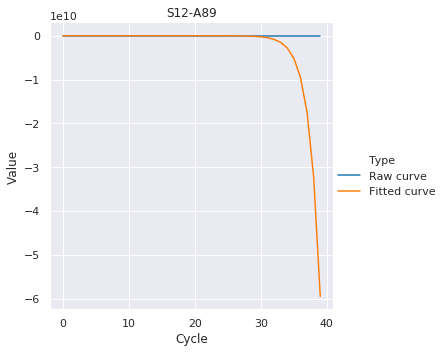

In [23]:
## Display a curve and its fitting
import pandas as pd
import string

# Loading data
dir = "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/"
data = pd.read_csv(dir + "final_data.Gompertz_with_bump.bump_corrected.REF.tsv", sep="\t", index_col=0)
display(data.head(2))

# Setting curve variables variables
cols = cycles_col
#w = ["S49-A55"]
#w = ["S27-A58"]
w = ["S12-A89"]
#w = ["S77-A13"]

# Setting the 2 curves
df1 = format_raw_fluo_data(data, cols, w, "Raw curve")
equation = Gompertz_with_bump
params = ["P_" + letter + "_final_" + equation.__name__ for letter in list(string.ascii_lowercase)[0:equation.__code__.co_argcount - 1]]
df2 = format_equation_data(np.array(data.loc[w, params]), Gompertz_with_bump, w, "Fitted curve")

# Gathering the 2 curves
df_list = [df1, df2]
df_total = pd.concat(df_list, sort=False, ignore_index=True)

# Plotting
plot_curves(df_total, title=w[0])

1 w1 RPL13a1 - PS1 df1
2 w2 RPL13a1 - PS2 df2
3 w3 RPL13a1 - PS3 df3
4 w4 RPL13a1 - PS4 df4
5 w5 RPL13a1 - PS5 df5
6 w6 RPL13a1 - PS6 df6


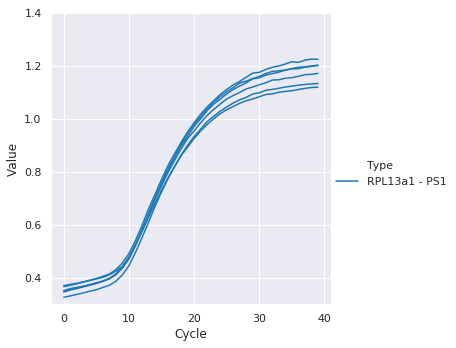

In [72]:
## Display curve(s) (modelled or raw)
import seaborn as sns

cols = cycles_col
#cols = corr_cycles_col
#cols = cycles_col_log
#cols = cycles_col_mod_Gwb
#cols = cycles_col_mod_GwbfE
#w = create_wellIDs([4], list(range(63, 69)))
w = create_wellIDs([53], list(range(17, 18)))
#w = create_wellIDs([1], [91])
#w2 = create_wellIDs([2], list(range(25, 31)))
#w2 = create_wellIDs([50], list(range(91, 97)))
#df = format_raw_fluo_data(data, ["S49-A13"], "Test_raw")
#df = format_raw_fluo_data(data, ["S49-A13", "S21-A87"], "Test_raw")
#df = format_raw_fluo_data(data, cols, w, "S01-A91")
#df = format_raw_fluo_data(data, cols, w, "PS1_mod")
#df2 = format_raw_fluo_data(data, cols, w2, "PC2")
#df2 = format_raw_fluo_data(data, cols, w2, "PC2_Fitted")
#df2 = format_raw_fluo_data(data, cols, w2, "PC2_mod")
#df2 = format_raw_fluo_data(data, w2, "PC1")
#df2 = format_raw_fluo_data(data, cycles_col, w2, "RPL13a2 - PS2")
#df2 = format_equation_data(np.array([[0.32, 1.04, 39.98, 0.26, -0.057, -0.11]]), Gompertz_with_bump, ["S07-A76"], "Fitted")

for i, j, k, l in zip(range(1, 7), ["w" + str(x) for x in range(1, 7)], ["RPL13a1 - PS" + str(x) for x in range(1, 7)],
                   ["df" + str(x) for x in range(1, 7)]):
    print(i, j, k, l)
    exec(j + " = create_wellIDs([" + str(i) + "], list(range(1, 7)))")
    exec(l + " = format_raw_fluo_data(data, cols, " + j + ", '" + k + "')")

"""
w1 = create_wellIDs([1], list(range(1, 7)))
df1 = format_raw_fluo_data(data, cols, w1, "RPL13a1 - PS1")
w2 = create_wellIDs([2], list(range(1, 7)))
df2 = format_raw_fluo_data(data, cols, w2, "RPL13a2 - PS2")
w3 = create_wellIDs([3], list(range(1, 7)))
df3 = format_raw_fluo_data(data, cols, w3, "RPL13a2 - PS3")
w4 = create_wellIDs([4], list(range(1, 7)))
df4 = format_raw_fluo_data(data, cols, w4, "RPL13a2 - PS4")
w5 = create_wellIDs([5], list(range(1, 7)))
df5 = format_raw_fluo_data(data, cols, w5, "RPL13a2 - PS5")
w6 = create_wellIDs([6], list(range(1, 7)))
df6 = format_raw_fluo_data(data, cols, w6, "RPL13a2 - PS6")
"""
#df_list = [df1, df2, df3, df4, df5, df6]
df_list = [df1]
df_total = pd.concat(df_list, sort=False, ignore_index=True)
#plot_curves(df3, "WellID")
plot_curves(df_total)

Condition     Gene  Fluidigm_Ct  Sample  Assay       F00       F01  \
WellID                                                                       
S01-A01       PS1  RPL13a1     8.491106       1      1  0.370476  0.375293   
S01-A02       PS1  RPL13a1     8.375671       1      2  0.351437  0.359487   

              F02       F03       F04  ...  F30_bump_corr  F31_bump_corr  \
WellID                                 ...                                 
S01-A01  0.379359  0.384355  0.390125  ...       0.980859       0.986623   
S01-A02  0.363358  0.368100  0.374405  ...       1.012791       1.017023   

         F32_bump_corr  F33_bump_corr  F34_bump_corr  F35_bump_corr  \
WellID                                                                
S01-A01       0.986413       0.990092       0.990711       0.990850   
S01-A02       1.024297       1.022283       1.025398       1.024531   

         F36_bump_corr  F37_bump_corr  F38_bump_corr  F39_bump_corr  
WellID                                                               
S01-A01       0.992990       0.994700       0.995854       0.994744  
S01-A02       1.026882       1.029944       1.028336       1.029068  

[2 rows x 107 columns]

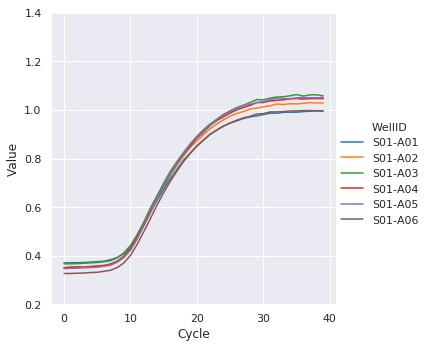

In [41]:
## Display curve(s) (modelled or raw)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Loading data
dir = "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/"
#data = pd.read_csv( dir + "final_data.Gompertz_with_bump.REF.tsv", sep="\t", index_col=0)
data = pd.read_csv( dir + "final_data.Gompertz_with_bump.bump_corrected.REF.tsv", sep="\t", index_col=0)
display(data.head(2))

#cols = cycles_col
cols = cycles_col_bump_corr
#cols = corr_cycles_col

w = create_wellIDs([1], list(range(1, 7)))
#w = create_wellIDs([55], list(range(55, 61)))
#w = create_wellIDs([50], list(range(91, 97)))
#w = ["S" + str(s).zfill(2) + "-A" + str(a).zfill(2) for s, a in zip(np.random.randint(1, 97, 10), np.random.randint(1, 97, 10))]
#w2 = create_wellIDs([2], list(range(1, 7)))
#w2 = create_wellIDs([55], list(range(55, 61)))
w2 = ["S" + str(s).zfill(2) + "-A" + str(a).zfill(2) for s, a in zip(np.random.randint(1, 97, 10), np.random.randint(1, 97, 10))]

#gene1 = "RPL13a1"
#gene1 = "Rarab"
gene1 = "Her7"
#cond1 = "PS1"
#cond1 = "PC2"
cond1 = "PC7"
#gene2 = "PSL13a1"
#gene2 = "Her7"
#cond2 = "PS2"
#cond2 = "PC7"

df1 = format_raw_fluo_data(data, cols, w, gene1 + " - " + cond1)
#df2 = format_raw_fluo_data(data, cols, w2, gene2 + " - " + cond2)

#df_list = [df1, df2, df3, df4, df5, df6]
#df_list = [df1, df2]
df_list = [df1]
df_total = pd.concat(df_list, sort=False, ignore_index=True)
#plot_curves(df_total)
plot_curves(df_total, hue="WellID")

WellID Condition     Gene  Cycle     Value
0  S06-A01       PS6  RPL13a1      0  0.282063
1  S06-A02       PS6  RPL13a1      0  0.268009

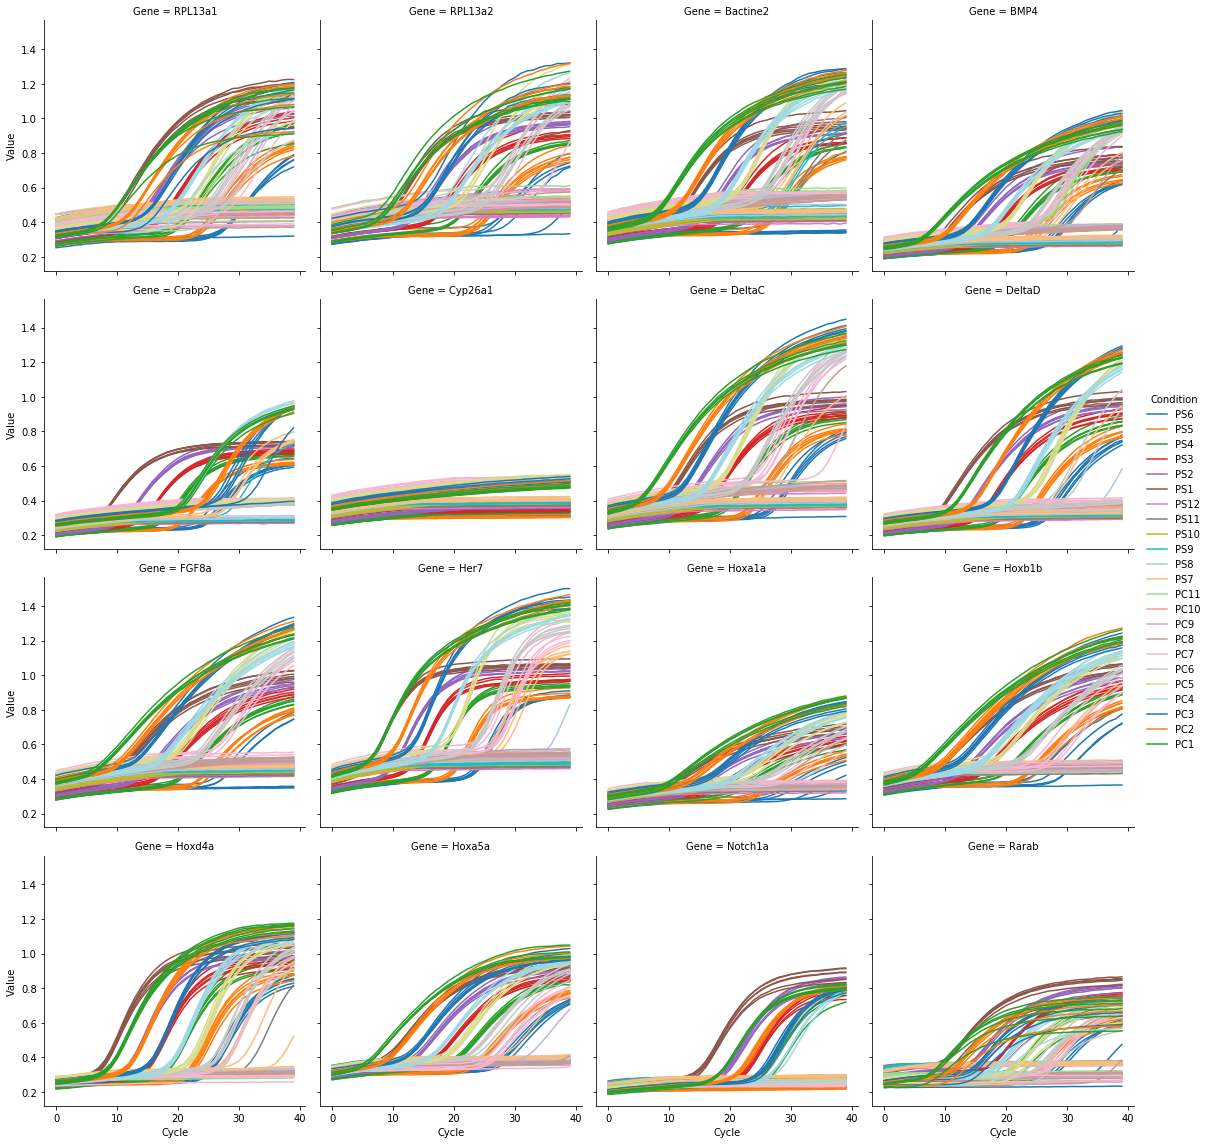

In [30]:
## Display all raw curves (not pre-amplified) gathered by gene
import seaborn as sns

# Loading data
dir = "/users/biocomp/bahin/Mounted_dir/data_bioclust/qPCR/Research_plate/Fixed_keys/"
data = pd.read_csv( dir + "research_plate.tsv", sep="\t", index_col=0)
data = data.loc[data.Pre_amplification == 0, :].copy()

df = data.reset_index().copy()
df = df.loc[:, ["WellID", "Condition", "Gene"] + cycles_col]
df = pd.melt(df, id_vars=["WellID", "Condition", "Gene"], value_vars=cycles_col, var_name="Cycle", value_name="Value")
df["Cycle"] = df.apply(lambda row: int(row["Cycle"][1:3]), axis=1)
display(df.head(2))
g = sns.FacetGrid(df, col="Gene", col_wrap=4, hue="Condition", palette=HiFit_colormap, height=4)
g = (g.map_dataframe(sns.lineplot, "Cycle", "Value", units="WellID", estimator=None).add_legend())

<h1>Background removal</h1>

In [22]:
## Removing the background through correct_bump function

# Loading data
dir = "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/QV_plate/"
df = pd.read_csv(dir + "final_data.Gompertz_with_bump.REF.tsv", sep="\t", index_col=0)
display(df.head(2))

df[cycles_col_bump_corr] = qPCR_functions.correct_bump(df[cycles_col], df["P_e_final_Gompertz_with_bump"], df["P_f_final_Gompertz_with_bump"])
display(df.head(2))
df.to_csv(dir + "final_data.Gompertz_with_bump.bump_corrected.REF.tsv", sep="\t")

Condition     Gene  Fluidigm_Ct  Sample  Assay       F00       F01  \
WellID                                                                       
S01-A01       H2O  RPL13a1        999.0       1      1  0.494518  0.494806   
S01-A02       H2O  RPL13a2        999.0       1      2  0.507942  0.508734   

              F02       F03       F04  ...  P_d_Gompertz_with_bump  \
WellID                                 ...                           
S01-A01  0.495674  0.494908  0.494846  ...                0.071051   
S01-A02  0.506930  0.511395  0.511412  ...                0.015346   

         P_e_Gompertz_with_bump  P_f_Gompertz_with_bump  \
WellID                                                    
S01-A01                0.046920               -0.172179   
S01-A02                0.008756               -0.456503   

         P_a_final_Gompertz_with_bump  P_b_final_Gompertz_with_bump  \
WellID                                                                
S01-A01                      0.494454                      0.523135   
S01-A02                      0.419362                      0.691440   

         P_c_final_Gompertz_with_bump  P_d_final_Gompertz_with_bump  \
WellID                                                                
S01-A01                     34.516207                      0.054700   
S01-A02                     29.039687                      0.004049   

         P_e_final_Gompertz_with_bump  P_f_final_Gompertz_with_bump  \
WellID                                                                
S01-A01                      0.000000                     -0.155101   
S01-A02                      0.001244                     -0.473187   

         RSS_Gompertz_with_bump  
WellID                           
S01-A01                0.000028  
S01-A02                0.000042  

[2 rows x 67 columns]

Condition     Gene  Fluidigm_Ct  Sample  Assay       F00       F01  \
WellID                                                                       
S01-A01       H2O  RPL13a1        999.0       1      1  0.494518  0.494806   
S01-A02       H2O  RPL13a2        999.0       1      2  0.507942  0.508734   

              F02       F03       F04  ...  F30_bump_corr  F31_bump_corr  \
WellID                                 ...                                 
S01-A01  0.495674  0.494908  0.494846  ...       0.502118       0.504411   
S01-A02  0.506930  0.511395  0.511412  ...       0.518615       0.522525   

         F32_bump_corr  F33_bump_corr  F34_bump_corr  F35_bump_corr  \
WellID                                                                
S01-A01       0.503367       0.505322       0.504533       0.506134   
S01-A02       0.519842       0.522273       0.522224       0.521652   

         F36_bump_corr  F37_bump_corr  F38_bump_corr  F39_bump_corr  
WellID                                                               
S01-A01       0.504314       0.506348       0.505859       0.507777  
S01-A02       0.522821       0.521387       0.523672       0.523385  

[2 rows x 107 columns]

Condition     Gene  Fluidigm_Ct  Sample  Assay       F00       F01  \
WellID                                                                       
S01-A01       PS1  RPL13a1     8.491106       1      1  0.370476  0.375293   
S01-A02       PS1  RPL13a1     8.375671       1      2  0.351437  0.359487   

              F02       F03       F04  ...  F30_bump_corr  F31_bump_corr  \
WellID                                 ...                                 
S01-A01  0.379359  0.384355  0.390125  ...       0.981822       0.987464   
S01-A02  0.363358  0.368100  0.374405  ...       1.011652       1.015638   

         F32_bump_corr  F33_bump_corr  F34_bump_corr  F35_bump_corr  \
WellID                                                                
S01-A01       0.987123       0.990666       0.991142       0.991131   
S01-A02       1.022655       1.020373       1.023212       1.022059   

         F36_bump_corr  F37_bump_corr  F38_bump_corr  F39_bump_corr  
WellID                                                               
S01-A01       0.993115       0.994663       0.995649       0.994365  
S01-A02       1.024114       1.026872       1.024951       1.025362  

[2 rows x 107 columns]

WellID Condition     Gene  Cycle     Value
0  S01-A01       PS1  RPL13a1      0  0.370476
1  S01-A02       PS1  RPL13a1      0  0.351437

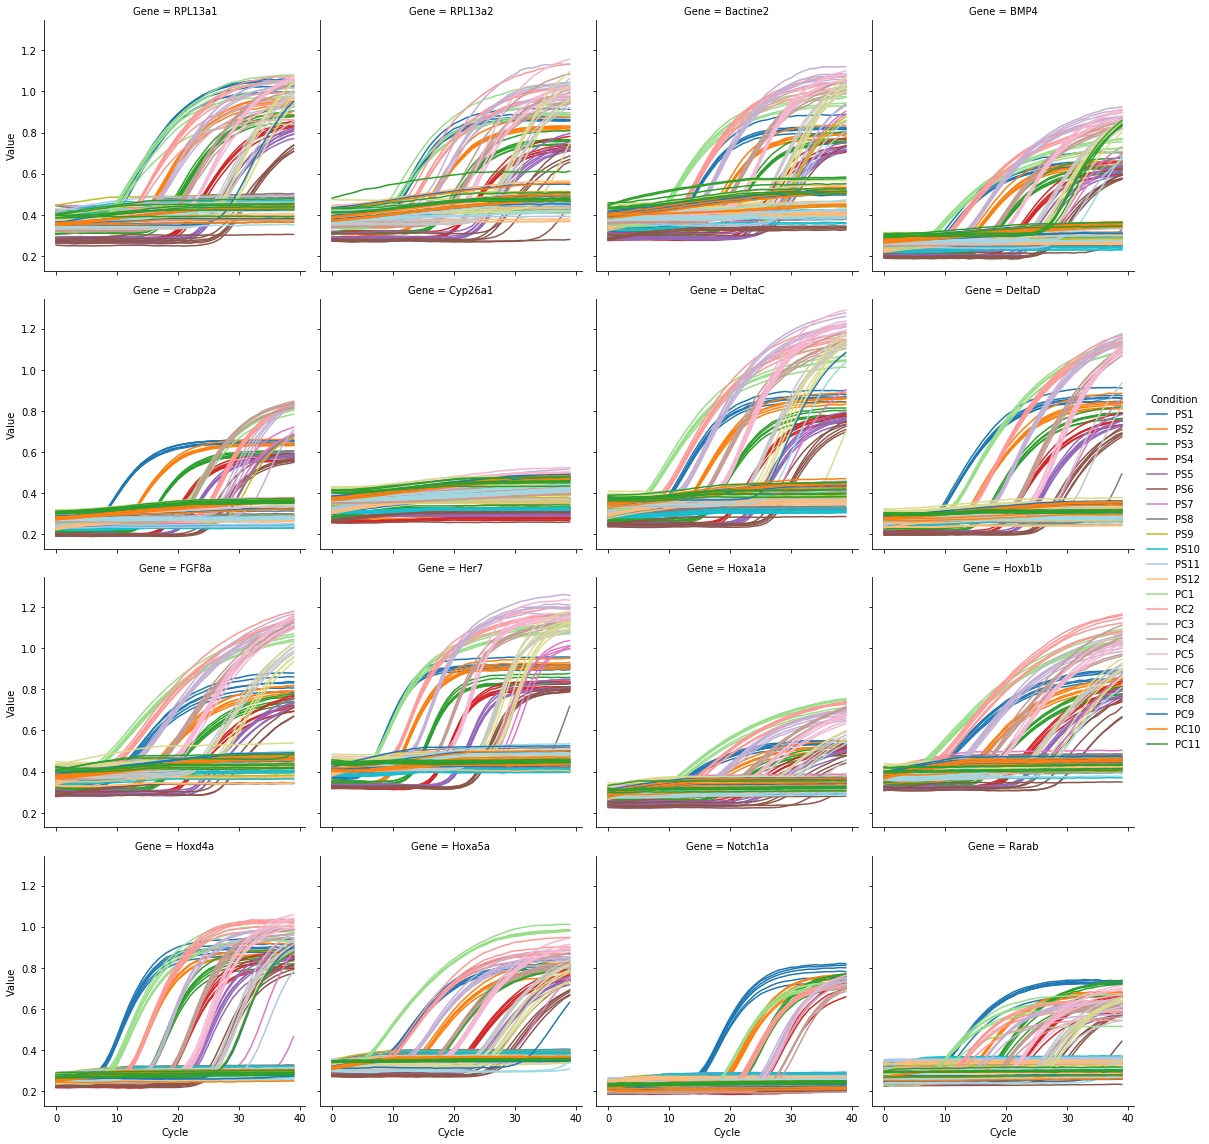

In [37]:
## Displaying all curves (not pre-amplified) with the bump corrected and gathered by gene
import seaborn as sns

# Loading data
dir = "/users/biocomp/bahin/Mounted_dir/data_bioclust/qPCR/Research_plate/Fixed_keys/"
data = pd.read_csv(dir + "final_data.Gompertz_with_bump.bump_corrected.REF.tsv", sep="\t", index_col=0)
data = data.loc[data.Pre_amplification == 0, :].copy()
display(data.head(2))

# Formatting data
df = data.reset_index().copy()
df = df.loc[:, ["WellID", "Condition", "Gene"] + cycles_col_bump_corr]
df = pd.melt(df, id_vars=["WellID", "Condition", "Gene"], value_vars=cycles_col_bump_corr, var_name="Cycle", value_name="Value")
df["Cycle"] = df.apply(lambda row: int(row["Cycle"][1:3]), axis=1)
display(df.head(2))

# Displating FacetGrid
g = sns.FacetGrid(df, col="Gene", col_wrap=4, hue="Condition", palette=HiFit_colormap, height=4)
g = (g.map_dataframe(sns.lineplot, "Cycle", "Value", units="WellID", estimator=None).add_legend())

<h1>Methods</h1>
<h2>Cq method</h2>

(568, 107)
[0.]


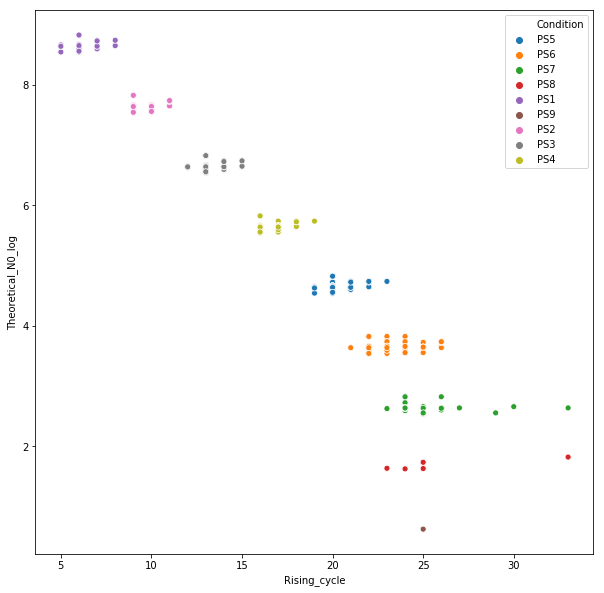

In [75]:
# Displaying Cq vs N0 (logged)
# Loading data
dir = "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/QV_plate/"
data = pd.read_csv(dir + "final_data.Gompertz_with_bump.bump_corrected.REF.tsv", sep="\t", index_col=0)
data = data.loc[(data.Condition.isin(["PS" + str(x) for x in range(1, 13)])) & data.Sigmoid_curve, :]
print(data.shape)

plt.figure(figsize=(10, 10))
sns.scatterplot(x="Rising_cycle", y="Theoretical_N0_log", hue="Condition", palette=HiFit_colormap, data=data)

<h2>Cy0</h2>

In [256]:
## Computing Cy0
from numpy import log as ln
                                                     
dataset2 = data2.loc[data2.Sigmoid_curve, :].copy()
dataset2.loc[:, "Cy0"] = dataset2.apply(lambda row: compute_Cy0(row), axis=1)
display(dataset2.head(2))
pairs = compare_feat(dataset2, "Cy0", reversed=True)

Condition     Gene  Fluidigm_Ct  Sample  Assay       F00       F01  \
WellID                                                                       
S01-A01       PS1  RPL13a1     8.491106       1      1  0.370476  0.375293   
S01-A02       PS1  RPL13a1     8.375671       1      2  0.351437  0.359487   

              F02       F03       F04  ...  P_g_Richards_with_bump  \
WellID                                 ...                           
S01-A01  0.379359  0.384355  0.390125  ...               -3.205544   
S01-A02  0.363358  0.368100  0.374405  ...               -0.057951   

         P_a_final_Richards_with_bump  P_b_final_Richards_with_bump  \
WellID                                                                
S01-A01                      0.379512                      0.737280   
S01-A02                      0.173273                      0.676842   

         P_c_final_Richards_with_bump  P_d_final_Richards_with_bump  \
WellID                                                                
S01-A01                      2.422517                      5.135184   
S01-A02                     10.522292                      3.923520   

         P_e_final_Richards_with_bump  P_f_final_Richards_with_bump  \
WellID                                                                
S01-A01                      9.234992                     -0.009303   
S01-A02                      2.479141                      0.177657   

         P_g_final_Richards_with_bump  RSS_Richards_with_bump        Cy0  
WellID                                                                    
S01-A01                     -3.197203                0.001052  15.717766  
S01-A02                      0.015774                0.001501  11.843858  

[2 rows x 70 columns]

Fluidigm_Ct accuracy: 84.0%
Cy0 accuracy: 71.5%
Equal Cy0: 0.0%


<h2>LinReg</h2>

Eff  Upper
0     1.055701      5
1     1.061439      5
2     1.062947      5
3     1.067540      5
4     1.068699      5
...        ...    ...
5595  1.214437      1
5596  1.216203      1
5597  1.152910      1
5598  1.210863      1
5599  1.410001      1

[5600 rows x 2 columns]

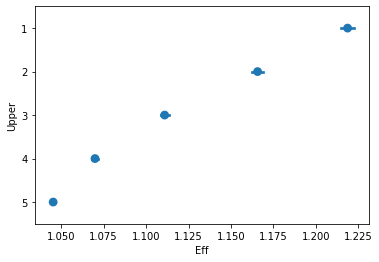

In [10]:
## LinReg attempts
from scipy import stats

def corrected_fluo(row, equation):
    # Getting the fitting parameters except the 2 first that are the min and max (we'll set them to 0 and 1) and the 2 lasts that are the bump parameters (we'll set them to 0 to remove it)
    params = ["P_" + letter + "_final_" + equation.__name__ for letter in list(string.ascii_lowercase)[1:equation.__code__.co_argcount - 3]]
    args = [0] + row[params].values.tolist() + [0, 0]
    # Running the fitting equation with these parameters
    return equation(np.arange(40), *args)

def get_eff(row, x):
    """ Get the efficiency from linear regression of a 4 cycles window within the log-linear region and with the equation E = 10^slope. """
    # Set the cycle range
    cycles = list(range(row["Mean_SDM"] - x, row["Mean_SDM"] - x + 4))
    # Get the logged fluo values
    cols = ["F" + str(x).zfill(2) + "_log" for x in cycles]
    # Compute the linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(cycles, row[cols].tolist())
    return np.power(10, slope)

# Set the dataset
gene = "RPL13a1"
#dataset = data.loc[(data["Pre_amplification"] == 0) & (data["Sigmoid_curve"]) & (data.Gene == gene), :]
dataset = data.loc[(data["Pre_amplification"] == 0) & (data["Sigmoid_curve"]), :]
# Computing the corrected fluo values
data[corr_cycles_col] = data.apply(lambda row: corrected_fluo(row, Gompertz_with_bump), axis=1, result_type="expand")
# Computing the log fluo values
data[cycles_col_log] = data.loc[:, cycles_col].apply(lambda x: np.log(x))
# Computing the corrected log fluo values
data[log_corr_cycles_col] = data.loc[:, corr_cycles_col].apply(lambda x: np.log(x))

# Compute the individual SDM on logged fluo values
dataset.loc[:, "SDM"] = dataset.apply(lambda row: max_second_derivative(row[cycles_col_log]), axis=1)
#display(dataset.head(2))
# Compute the mean SDM per gene and condtion and add it to the DataFrame
df = dataset.groupby(["Gene", "Condition"])["SDM"].mean()
dataset.loc[:, "Mean_SDM"] = dataset.apply(lambda row: int(df.loc[(df.index.get_level_values("Gene") == row.Gene) & (df.index.get_level_values("Condition") == row.Condition)].values[0]), axis=1)

# Compute the mean efficiencies for each window
res = pd.DataFrame()
for x in range(5, 0, -1):  # It's not directly a range of cycles because it has to be adapted for each gene/condition
    # Compute the efficiencies for the considered window
    s = dataset.apply(lambda row: get_eff(row, x), axis=1)
    df = pd.DataFrame(s)
    df.loc[:, "Upper"] = x
    # Add results to the growing results
    res = pd.concat([res, df], ignore_index=True)
res.rename(columns={0: "Eff"}, inplace=True)
display(res)

# Set the upper limit as a category for the plot
res["Upper"] = res["Upper"].astype("category")
# Creating the fern pattern plot
sns.pointplot(x="Eff", y="Upper", data=res, order=list(range(1, 6)), join=False)

In [2]:
## LinReg???
import numpy as np
import seaborn as sns

#display(data.columns.values)
#dataset = data.loc[(data.Gene == "RPL13a1") & (data.Condition == "PS1"), :].copy()
data[cycles_col_log] = data.loc[:, cycles_col].apply(lambda row: np.log(row), axis=1, result_type="expand")
#display(dataset.index)
#cycles_col_log = ["F" + str(i).zfill(2) + "_log" for i in range(40)]
#dataset[cycles_col_log] = dataset.loc[:, cycles_col].apply(lambda row: np.log(row), axis=1, result_type="expand")
#display(dataset.head(2))
w = create_wellIDs([1], list(range(1, 7)))
print(w)
df1 = format_raw_fluo_data(data.reset_index(), cycles_col_log, w, "RPL13a1 - PS1")
w2 = create_wellIDs([1], list(range(7, 13)))
print(w2)
df2 = format_raw_fluo_data(data.reset_index(), cycles_col_log, w2, "RPL13a1 - PS2")
df_list = [df1, df2]
df_total = pd.concat(df_list, sort=False, ignore_index=True)
plot_curves(df_total)

NameError: name 'data' is not defined

<h2>Logistic5p</h2>

In [6]:
## 5p testing (WARNING NEW EQUATION FROM IMPORT)
import pandas as pd
import numpy as np
import string
import seaborn as sns    

# Loading the data
df = pd.read_csv("final_data.logistic5p_with_bump.tsv", sep="\t", index_col=0)
#df = pd.read_csv("final_data.Gompertz_with_bump.REF.tsv", sep="\t", index_col=0)
df = df.loc[(df.Sigmoid_curve) & (df.Pre_amplification == 0), :].copy()
#display(df.head(2))

# Getting the modelled curve
equation = logistic5p_with_bump
cycles_col_mod_5p = ["F" + str(i).zfill(2) + "_mod_5p_with_bump" for i in range(40)]
df[cycles_col_mod_5p] = df.apply(lambda row: modelled_fluo(row, equation), axis=1, result_type="expand")

# Computing the SDM
df.loc[:, "5p_mod_SDM"] = df.apply(lambda row: max_second_derivative_smart(row[cycles_col_mod_5p]), axis=1)

# Getting the efficiency at SDM
df.loc[:, "Eff_5p_SDM"] = df.apply(lambda row: row["F" + str(row["5p_mod_SDM"]).zfill(2) + "_mod_5p_with_bump"] / row["F" + str(int(row["5p_mod_SDM"]) - 1).zfill(2) + "_mod_5p_with_bump"], axis=1)

# Getting the F0 at SDM
df.loc[:, "F0_5p"] = df.apply(lambda row: row["F" + str(row["5p_mod_SDM"]).zfill(2) + "_mod_5p_with_bump"] / np.power(row["Eff_5p_SDM"], row["5p_mod_SDM"]), axis=1)
display(df.head(2))

sns.scatterplot(x="Theoretical_N0_log", y="F0_5p", data=df, hue="Gene")

FileNotFoundError: [Errno 2] File final_data.logistic5p_with_bump.tsv does not exist: 'final_data.logistic5p_with_bump.tsv'

<h2>LRE</h2>

In [ ]:
## LRE original background removal
import pandas as pd
import numpy as np

# Loading data
dir = "/users/biocomp/bahin/Mounted_dir/data_bioclust/qPCR/Research_plate/Fixed_keys/"
eq = "Gompertz_with_bump"
data = pd.read_csv( dir + "final_data." + eq + ".REF.tsv", sep="\t", index_col=0)
display(data.head(2))

# Creating the cols
cycles_col_bump_corr_LRE = ["F" + str(i).zfill(2) + "_bump_corr_LRE" for i in range(40)]

# Substracting the bump
data[cycles_col_bump_corr_LRE] = data[cycles_col] - np.mean(data[["F0" + str(x) for x in range(7)]].values)
display(data.head(2))

Condition      Gene  Fluidigm_Ct  Sample  Assay       F00       F01  \
WellID                                                                        
S53-A17       PC5  Bactine2    20.603761      53     17  0.408243  0.419531   

              F02       F03       F04  ...  F30_noBL  F31_noBL  F32_noBL  \
WellID                                 ...                                 
S53-A17  0.426079  0.432923  0.438902  ...  0.507205  0.538055  0.562594   

         F33_noBL  F34_noBL  F35_noBL  F36_noBL  F37_noBL  F38_noBL  F39_noBL  
WellID                                                                         
S53-A17  0.582072   0.59733  0.611785  0.619887  0.629057  0.633856  0.636721  

[1 rows x 107 columns]

/users/biocomp/bahin/anaconda3/envs/Env_conda_qPCR/lib/python3.6/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


WellID  Cycle      Fluo       Eff
0   S53-A17      1  0.000091 -1.019310
1   S53-A17      2  0.000241  1.661629
2   S53-A17      3  0.000794  2.290793
3   S53-A17      4  0.000583 -0.265804
4   S53-A17      5  0.003353  4.750742
5   S53-A17      6  0.003169 -0.054932
6   S53-A17      7  0.000839 -0.735395
7   S53-A17      8  0.002951  2.519040
8   S53-A17      9  0.000879 -0.702050
9   S53-A17     10  0.000167 -0.810167
10  S53-A17     11 -0.000510 -4.055464
11  S53-A17     12 -0.000883  0.732414
12  S53-A17     13 -0.001617  0.830511
13  S53-A17     14 -0.003214  0.987529
14  S53-A17     15 -0.001936 -0.397605
15  S53-A17     16 -0.003314  0.711727
16  S53-A17     17 -0.002799 -0.155607
17  S53-A17     18  0.001095 -1.391209
18  S53-A17     19  0.007803  6.127355
19  S53-A17     20  0.013371  0.713533
20  S53-A17     21  0.037500  1.804568
21  S53-A17     22  0.068010  0.813589
22  S53-A17     23  0.116648  0.715152
23  S53-A17     24  0.176260  0.511037
24  S53-A17     25  0.242334  0.374867
25  S53-A17     26  0.308685  0.273802
26  S53-A17     27  0.371607  0.203836
27  S53-A17     28  0.425429  0.144836
28  S53-A17     29  0.470069  0.104931
29  S53-A17     30  0.507205  0.079000
30  S53-A17     31  0.538055  0.060824
31  S53-A17     32  0.562594  0.045608
32  S53-A17     33  0.582072  0.034622
33  S53-A17     34  0.597330  0.026212
34  S53-A17     35  0.611785  0.024200
35  S53-A17     36  0.619887  0.013242
36  S53-A17     37  0.629057  0.014793
37  S53-A17     38  0.633856  0.007629
38  S53-A17     39  0.636721  0.004520

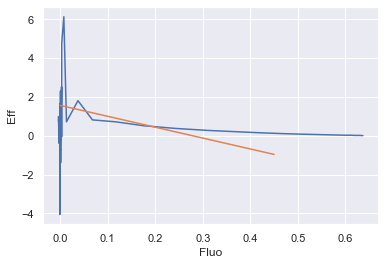

In [65]:
## Displaying LRE fluo vs eff plot
import seaborn as sns

# Loading the data
dir = "/users/biocomp/bahin/Mounted_dir/data_bioclust/qPCR/Research_plate/Fixed_keys/"
#df = pd.read_csv(dir + "final_data.Boltzmann_LRE_with_bump.REF.tsv", sep="\t", index_col=0)
data = pd.read_csv(dir + "final_data.Gompertz_with_bump.REF.tsv", sep="\t", index_col=0)

# Correct the bump
#df[cycles_col_noBL] = df.apply(lambda row: correct_bump(row, row["P_e_final_Gompertz_with_bump"], row["P_f_final_Gompertz_with_bump"]), axis=1, result_type="expand")
data[cycles_col_noBL] = df.apply(lambda row: correct_bump(row, row["P_e_final_Gompertz_with_bump"], row["P_f_final_Gompertz_with_bump"], row["P_a_final_Gompertz_with_bump"]), axis=1, result_type="expand")

# Setting the dataset (the curve)
#dataset = data.iloc[6:7]
dataset = data.iloc[919:920]
display(dataset)

# Melting the DataFrame to have one fluo cyle per row
dataset2 = pd.melt(dataset.reset_index(), id_vars=["WellID"], value_vars=cycles_col_noBL, var_name="Cycle", value_name="Fluo")
dataset2["Cycle"] = dataset2["Cycle"].str.slice(1,3).astype("int")

# Melting the DataFrame to have one eff cycle per row
cycles_eff = ["E" + str(x).zfill(2) for x in range(1, 40)]
dataset[cycles_eff] = dataset.apply(compute_Ec_val, axis=1, result_type="expand")
dataset3 = pd.melt(dataset.reset_index(), id_vars=["WellID"], value_vars=cycles_eff, var_name="Cycle", value_name="Eff")
dataset3["Cycle"] = dataset3["Cycle"].str.slice(1,3).astype("int")

# Merging the 2 previous info
dataset = dataset2.merge(dataset3, left_on=["WellID", "Cycle"], right_on=["WellID", "Cycle"])
display(dataset)

# Plotting
sns.lineplot(x="Fluo", y="Eff", data=dataset)
plt.plot(np.arange(0, 0.5, 0.05), [-5.61 * a + 1.56 for a in np.arange(0, 0.5, 0.05)])

E06     1.33963
E07    0.978164
E08    0.834772
E09    0.577795
E10    0.370373
E11    0.265907
E12    0.176841
Name: S01-A25, dtype: object
F06_noBL    0.0215726
F07_noBL    0.0426742
F08_noBL    0.0782974
F09_noBL     0.123537
F10_noBL     0.169292
F11_noBL     0.214308
F12_noBL     0.252207
Name: S01-A25, dtype: object


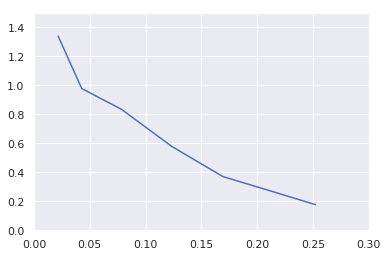

In [38]:
## Displaying only the window (to check the linear regression)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Loading the data
dir = "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/"
data = pd.read_csv(dir + "methods_comparison.tsv", sep="\t", index_col=0)
#display(data.head(2))

wellID = "S01-A25"
cycle_start = 6
cycle_stop = 13
#print(data.loc[wellID, ])

print(data.loc[wellID, ["E" + str(x).zfill(2) for x in range(cycle_start, cycle_stop)]])
print(data.loc[wellID, ["F" + str(x).zfill(2) + "_noBL" for x in range(cycle_start, cycle_stop)]])
plt.xlim(0, 0.3)
plt.ylim(0, 1.5)
plt.plot(data.loc[wellID, ["F" + str(x).zfill(2) + "_noBL" for x in range(cycle_start, cycle_stop)]],
        data.loc[wellID, ["E" + str(x).zfill(2) for x in range(cycle_start, cycle_stop)]])

Condition     Gene  Fluidigm_Ct  Sample  Assay       F00       F01  \
WellID                                                                       
S01-A07       PS1  RPL13a2     8.461267       1      7  0.346537  0.352955   

              F02      F03       F04  ...  F30_bump_corr  F31_bump_corr  \
WellID                                ...                                 
S01-A07  0.359149  0.36477  0.371611  ...       0.885142       0.886815   

         F32_bump_corr  F33_bump_corr  F34_bump_corr  F35_bump_corr  \
WellID                                                                
S01-A07       0.887732       0.890818       0.886926       0.888711   

         F36_bump_corr  F37_bump_corr  F38_bump_corr  F39_bump_corr  
WellID                                                               
S01-A07       0.888911       0.887675        0.88709       0.886624  

[1 rows x 107 columns]

/users/biocomp/bahin/anaconda3/envs/Env_conda_qPCR/lib/python3.6/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


WellID  Cycle      Fluo       Eff
0   S01-A07      1  0.346519 -0.000053
1   S01-A07      2  0.346472 -0.000134
2   S01-A07      3  0.346042 -0.001242
3   S01-A07      4  0.347015  0.002813
4   S01-A07      5  0.347509  0.001424
5   S01-A07      6  0.349338  0.005262
6   S01-A07      7  0.352950  0.010341
7   S01-A07      8  0.364650  0.033148
8   S01-A07      9  0.386399  0.059644
9   S01-A07     10  0.417047  0.079316
10  S01-A07     11  0.460796  0.104903
11  S01-A07     12  0.514087  0.115649
12  S01-A07     13  0.570492  0.109718
13  S01-A07     14  0.621806  0.089947
14  S01-A07     15  0.666533  0.071931
15  S01-A07     16  0.709641  0.064675
16  S01-A07     17  0.745608  0.050683
17  S01-A07     18  0.775078  0.039525
18  S01-A07     19  0.797297  0.028666
19  S01-A07     20  0.818747  0.026904
20  S01-A07     21  0.829819  0.013524
21  S01-A07     22  0.845440  0.018824
22  S01-A07     23  0.856170  0.012692
23  S01-A07     24  0.864072  0.009230
24  S01-A07     25  0.869368  0.006129
25  S01-A07     26  0.875683  0.007263
26  S01-A07     27  0.879275  0.004102
27  S01-A07     28  0.882718  0.003915
28  S01-A07     29  0.886938  0.004781
29  S01-A07     30  0.885142 -0.002025
30  S01-A07     31  0.886815  0.001891
31  S01-A07     32  0.887732  0.001034
32  S01-A07     33  0.890818  0.003475
33  S01-A07     34  0.886926 -0.004369
34  S01-A07     35  0.888711  0.002013
35  S01-A07     36  0.888911  0.000225
36  S01-A07     37  0.887675 -0.001390
37  S01-A07     38  0.887090 -0.000659
38  S01-A07     39  0.886624 -0.000526

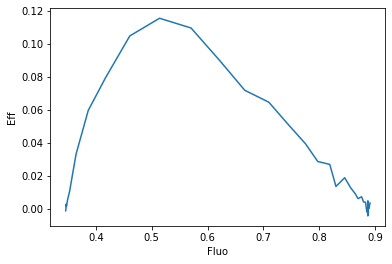

In [32]:
## Displaying LRE fluo vs eff plot
import seaborn as sns

# Loading the data
dir = "/users/biocomp/bahin/Mounted_dir/data_bioclust/qPCR/Research_plate/Fixed_keys/"
#df = pd.read_csv(dir + "final_data.Boltzmann_LRE_with_bump.REF.tsv", sep="\t", index_col=0)
df = pd.read_csv(dir + "final_data.Gompertz_with_bump.REF.tsv", sep="\t", index_col=0)

# Correct the bump
cycles_col_noBL = ["F" + str(i).zfill(2) + "_bump_corr" for i in range(40)]
df[cycles_col_noBL] = df.apply(lambda row: correct_bump(row, row["P_e_final_Gompertz_with_bump"], row["P_f_final_Gompertz_with_bump"]), axis=1, result_type="expand")

# Setting the dataset (the curve)
dataset = df.iloc[6:7]
display(dataset)

# Melting the DataFrame to have one fluo cyle per row
dataset2 = pd.melt(dataset.reset_index(), id_vars=["WellID"], value_vars=cycles_col_noBL, var_name="Cycle", value_name="Fluo")
dataset2["Cycle"] = dataset2["Cycle"].str.slice(1,3).astype("int")

# Melting the DataFrame to have one eff cycle per row
cycles_eff = ["E" + str(x).zfill(2) for x in range(1, 40)]
dataset[cycles_eff] = dataset.apply(compute_Ec_val, axis=1, result_type="expand")
dataset3 = pd.melt(dataset.reset_index(), id_vars=["WellID"], value_vars=cycles_eff, var_name="Cycle", value_name="Eff")
dataset3["Cycle"] = dataset3["Cycle"].str.slice(1,3).astype("int")

# Merging the 2 previous info
dataset = dataset2.merge(dataset3, left_on=["WellID", "Cycle"], right_on=["WellID", "Cycle"])
display(dataset)

# Plotting
sns.lineplot(x="Fluo", y="Eff", data=dataset)

(337896, 23)
(239396, 23)


/users/biocomp/bahin/anaconda3/envs/Env_conda_qPCR/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # This is added back by InteractiveShellApp.init_path()


LRE_method_status
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

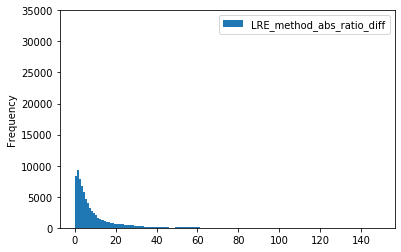

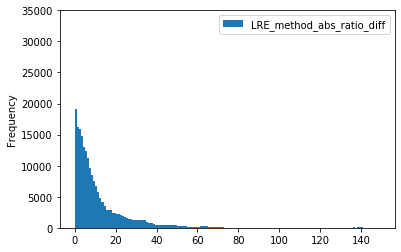

In [3]:
## Trying to understand the two metrics median abs log diff and accuracy changing the start of the window
import pandas as pd
import numpy as np

# Loading data
dir = "/users/biocomp/bahin/Mounted_dir/data_bioclust/qPCR/Research_plate/Fixed_keys/"
data = pd.read_csv( dir + "pairs.SDM-3.tsv", sep="\t", index_col=0)
#display(data.head(2))
print(data.shape)
print(data.loc[data.LRE_method_status, :].shape)
data.groupby("LRE_method_status")["LRE_method_status", "LRE_method_abs_ratio_diff"].plot.hist(ylim=(0, 35000), bins=np.arange(0, 150))

(0, 50000)

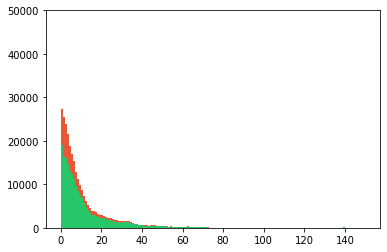

In [4]:
## Merging the 2 previous graphs
import matplotlib.pyplot as plt
plt.hist([data.loc[data.LRE_method_status, "LRE_method_abs_ratio_diff"],
          data.loc[data.LRE_method_status == False, "LRE_method_abs_ratio_diff"]],
          bins=150, range=(0,150), stacked=True, color=["#26C669", "#EC5638"])
plt.ylim(0, 50000)

<h2>MAK2 (attempts)</h2>

In [54]:
import numpy as np

def MAK2(x, minimum, D0, k):
    if x == 0:
        return minimum + D0
    else:
        return  minimum + MAK2(x - 1, minimum, D0, k) + k * np.log(1 + (MAK2(x - 1, minimum, D0, k) / k))

print([np.round_(MAK2(x, 0.208, 1e-8, 0.0000000002), 4) for x in range(10)])
print(np.round_(MAK2(np.array(range(10)), 0.208, 1e-8, 0.0000000002), 4))

[0.208, 0.416, 0.624, 0.832, 1.04, 1.248, 1.456, 1.664, 1.872, 2.08]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [64]:
def fun_test(x, a, b):
    return a + (b * x)

print("Comp. list version: ", [fun_test(x, 2, 6) for x in range(5)])
print("Array version: ", fun_test(np.array(range(5)), 2, 6))

Comp. list version:  [2, 8, 14, 20, 26]
Array version:  [ 2  8 14 20 26]


In [66]:
def fun_test(x, a, b):
    if x == 0:
        return 1
    else:
        return a + (b * fun_test(x - 1, a, b))

print("Comp. list version: ", [fun_test(x, 2, 6) for x in range(5)])
print("Array version: ", fun_test(np.array(range(5)), 2, 6))

Comp. list version:  [1, 8, 50, 302, 1814]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [70]:
vfunc = np.vectorize(fun_test)
vfunc(np.array(range(5)), 2, 6)

array([   1,    8,   50,  302, 1814])

<h1>T-test</h1>

In [9]:
## Special covid local setup
data = pd.read_csv("final_data.Gompertz_with_bump.REF.tsv", sep="\t", index_col=0)
dataset = data.loc[(data.Sigmoid_curve) & (data["Pre_amplification"] == 0), :].copy()

In [15]:
## Testing one t-test
from scipy import stats

dataset = data.loc[(data.Sigmoid_curve) & (data.Pre_amplification == 0) & (data.Gene != "Notch1a") & ~((data.Gene == "Crabp2a") & (data.S_or_C == "PC")) & ~((data.Gene == "BMP4") & (data.S_or_C == "PC")), :].copy()
FCq1 = dataset.loc[(dataset.Gene == "RPL13a1") & (dataset.Condition == "PS1"), "Fluidigm_Ct"].tolist()
FCq2 = dataset.loc[(dataset.Gene == "Hoxa1a") & (dataset.Condition == "PC1"), "Fluidigm_Ct"].tolist()
print(FCq1, FCq2)
print(stats.ttest_ind(FCq1, FCq2))
print(np.mean(FCq1), np.mean(FCq2))

[8.49110578713415, 8.37567116665749, 8.264054485047309, 8.35986430872871, 8.43287565814817, 8.366298749339999] [8.926165313906491, 8.979433209960769, 8.879155690850949, 8.949739679640471, 9.04816977061397, 8.892801684958801]
Ttest_indResult(statistic=-14.042231957108156, pvalue=6.580202885113992e-08)
8.381645025842639 8.945910891655243


In [22]:
## Compute the t-test over 6 replicates comparisons
from scipy import stats

# Selecting data: gene/condition for which the 6 replicats have a sigmoid curve
df = dataset.groupby(["Gene", "Condition"]).filter(lambda row: row.Condition.count() == 6).copy()
# Creating all the pair combinations
df = df.reset_index().loc[:, ["Gene", "Condition"]].copy()
display(comb.drop_duplicates().head(2))
pairs = pd.merge(comb.drop_duplicates(), comb.drop_duplicates(), on="key", suffixes=["_1", "_2"])
print(pairs.shape)
pairs = pairs.loc[((pairs.Condition_1 != pairs.Condition_2) | (pairs.Gene_1 != pairs.Gene_2)) & (pairs.Theoretical_N0_log_1 != pairs.Theoretical_N0_log_2) & (pairs.WellID_1 > pairs.WellID_2)].copy()
display(pairs.head(2))

Gene Condition
0  RPL13a1       PS1
6  RPL13a2       PS1

(27225, 5)


Gene_1 Condition_1  key    Gene_2 Condition_2
2  RPL13a1         PS1    0  Bactine2         PS1
3  RPL13a1         PS1    0      BMP4         PS1

In [23]:
# Testing the average Fluidigm_Ct against the ground truth
pairs.loc[:, "Fluidigm_Ct_6rep_test"] = pairs.apply(lambda row: compute_t_test(dataset, row.Gene_1, row.Condition_1, row.Gene_2, row.Condition_2, "Fluidigm_Ct", reversed=True), axis=1)

# Testing the average Predicted_N0 against the ground truth
copairsmbs.loc[:, "Predicted_N0_6rep_test"] = pairs.apply(lambda row: compute_t_test(dataset, row.Gene_1, row.Condition_1, row.Gene_2, row.Condition_2, "Predicted_N0"), axis=1)

display(pairs.head(2))
display(pairs.groupby(["Fluidigm_Ct_6rep_test", "Predicted_N0_6rep_test"]).count())

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

<h1>Metrics</h1>

Plate Method Value
0  plate1     M1    25
1  plate1     M1    51

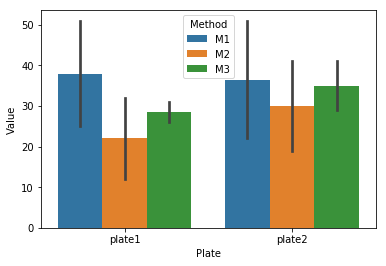

In [31]:
## Toy dataset
df = pd.DataFrame(np.array([["plate1", "M1", 25], ["plate1", "M1", 51],
                            ["plate1", "M2", 12], ["plate1", "M2", 32],
                            ["plate1", "M3", 26], ["plate1", "M3", 31],
                            ["plate2", "M1", 22], ["plate2", "M1", 51],
                            ["plate2", "M2", 19], ["plate2", "M2", 41],
                            ["plate2", "M3", 29], ["plate2", "M3", 41]
                           ]), columns=["Plate", "Method", "Value"])
display(df.head(2))
df["Value"] = pd.to_numeric(df["Value"])

sns.barplot(x="Plate", y="Value", hue="Method", data=df)

In [41]:
# Method color palette
meth_pal = ["#2961af", "#f30ecd", "#4abfba", "#bd8c48", "#a559cb"]

<h2>Median log ratio absolute difference</h2>

Plate Method     Value
0  Plate1     Cq  0.041436
1  Plate1     Cq  0.040261

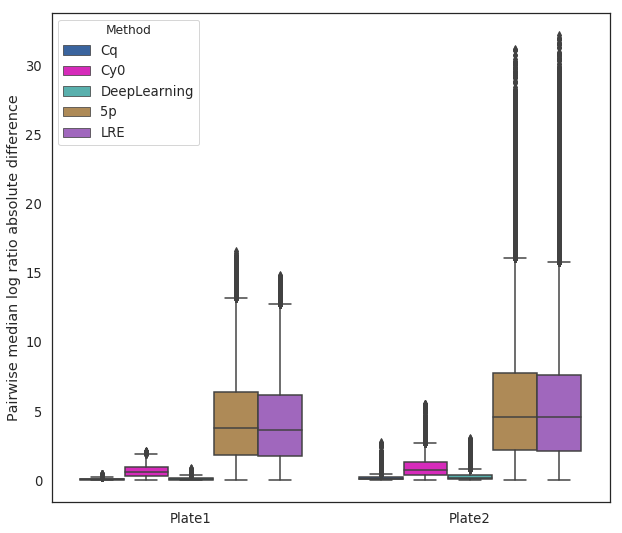

In [39]:
## Version with both plates
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading data
dir = "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/"
data_p1 = pd.read_csv(dir + "QV_plate/pairs.REF.tsv", sep="\t", index_col=0)
#display(data_p1.head(2))
data_p2 = pd.read_csv(dir + "pairs.REF.tsv", sep="\t", index_col=0)
#display(data_p2.head(2))

# Plotting
methods = ["Cq", "Cy0", "DeepLearning", "5p", "LRE"]
MLRAD = [meth + "_method_abs_ratio_diff" for meth in methods]
df_p1 = data_p1.loc[:, MLRAD].copy()
df_p1["Plate"] = "Plate1"
df_p2 = data_p2.loc[:, MLRAD].copy()
df_p2["Plate"] = "Plate2"
#display("P1", df_p1.head(2))
#display("P2", df_p2.head(2))
df = pd.concat([df_p1, df_p2])
df.columns = methods + ["Plate"]
df = pd.melt(df, id_vars=["Plate"], value_vars=methods, var_name="Method", value_name="Value")
display(df.head(2))
plt.figure(figsize=(10, 9))
ax = sns.boxplot(x="Plate", y="Value", hue="Method", data=df, palette=meth_pal)
ax.set(xlabel="", ylabel="Pairwise median log ratio absolute difference")
sns.set_style(style="white")
plt.savefig("/data/biocomp/bahin/qPCR/Diffusion/Paper/metric1.2plates.png")

<h2>Percentage of proper pariwise ranking</h2>

Cq        Cy0  DeepLearning         5p        LRE   Plate
True  87.883917  87.810323     88.927321  83.926177  82.734766  Plate1
True  91.070625  84.275635     89.519556  85.206395  84.478064  Plate2

Plate Method  Percentage
0  Plate1     Cq   87.883917
1  Plate2     Cq   91.070625

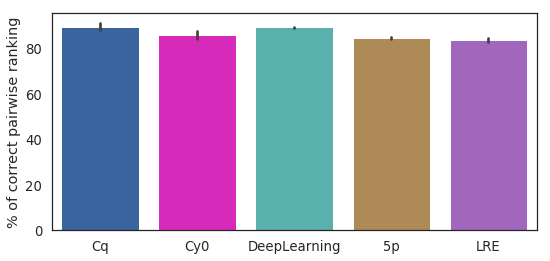

In [40]:
# Loading data
dir = "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/"
data_p1 = pd.read_csv(dir + "QV_plate/pairs.REF.tsv", sep="\t", index_col=0)
#display(data_p1.head(2))
data_p2 = pd.read_csv(dir + "pairs.REF.tsv", sep="\t", index_col=0)
#display(data_p2.head(2))

# Merging the two plates data
methods = ["Cq", "Cy0", "DeepLearning", "5p", "LRE"]
MLRAD = [meth + "_method_status" for meth in methods]
df_p1 = data_p1.loc[:, MLRAD].copy()
#display(df_p1.head(2))
perc_p1 = df_p1[MLRAD].apply(lambda x: x.value_counts(normalize=True).mul(100))
perc_p1["Plate"] = "Plate1"
#display(perc_p1)
df_p2 = data_p2.loc[:, MLRAD].copy()
#display(df_p2.head(2))
perc_p2 = df_p2[MLRAD].apply(lambda x: x.value_counts(normalize=True).mul(100))
perc_p2["Plate"] = "Plate2"
#display(perc_p2)
df = pd.concat([perc_p1, perc_p2])
df.index = df.index.map(str)
df = df.loc["True", :].copy()
df.columns = methods + ["Plate"]
display(df.head(2))

# Plotting
df = pd.melt(df, id_vars=["Plate"], value_vars=methods, var_name="Method", value_name="Value")
df.columns=["Plate", "Method", "Percentage"]
display(df.head(2))
plt.figure(figsize=(8.7, 4))
#plt.title("Percentage of correct pairwise ranking")
ax = sns.barplot(x="Method", y="Percentage", data=df, palette=meth_pal)
ax.set(xlabel="", ylabel="% of correct pairwise ranking")
#sns.barplot(x="Percentage", y="Method", data=df, palette=meth_pal)
plt.savefig("/data/biocomp/bahin/qPCR/Diffusion/Paper/metric2.2plates.svg")

<h2>Replicates coefficient of variation</h2>

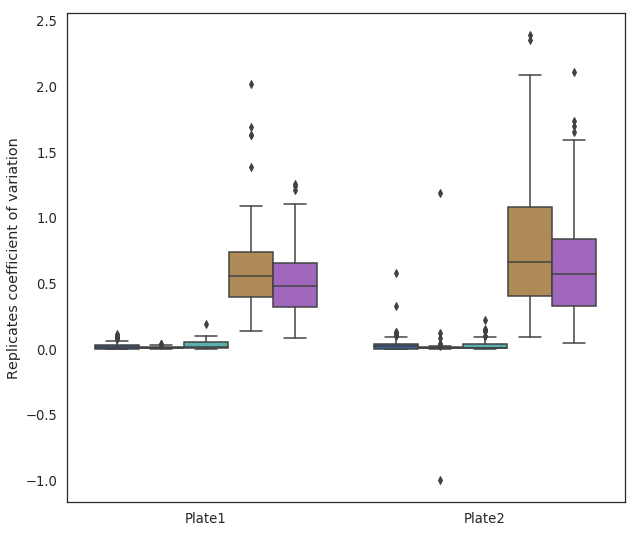

In [42]:
## Computing the standard deviation / coefficient of variation (version with both plots)
# Loading data
dir = "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/"
data_p1 = pd.read_csv(dir + "QV_plate/methods_results.REF.tsv", sep="\t", index_col=0)
#display(data_p1.head(2))
data_p2 = pd.read_csv(dir + "methods_results.REF.tsv", sep="\t", index_col=0)
#display(data_p2.head(2))

# Merging the two plates data
methods = ["Cq", "Cy0", "5p", "LRE", "DeepLearning"]
df_p1 = data_p1[["Condition", "Gene", "Cq_method_N0_log", "Cy0", "DL_predicted_N0_log", "F0_5p", "F0_LRE"]].copy()
df_p1["Plate"] = "Plate1"
#display(df_p1.head(2))
df_p2 = data_p2[["Condition", "Gene", "Cq_method_N0_log", "Cy0", "DL_predicted_N0_log", "F0_5p", "F0_LRE"]].copy()
df_p2["Plate"] = "Plate2"
#display(df_p2.head(2))
df = pd.concat([df_p1, df_p2])
#display(df.head(2))

# Comuputing the coeff of variation
std = df.reset_index().groupby(["Gene", "Condition", "Plate"])["Cq_method_N0_log", "Cy0", "DL_predicted_N0_log", "F0_5p", "F0_LRE"].std()
mean = df.reset_index().groupby(["Gene", "Condition", "Plate"])["Cq_method_N0_log", "Cy0", "DL_predicted_N0_log", "F0_5p", "F0_LRE"].mean()
cv = std / mean
cv.columns = methods
cv = cv.reset_index()[methods + ["Plate"]]
#display(cv.head(2))

# Plotting
cv = pd.melt(cv, id_vars=["Plate"], value_vars=methods, var_name="Method", value_name="Value")
#display(cv.head(2))
plt.figure(figsize=(10, 9))
ax = sns.boxplot(x="Plate", y="Value", hue="Method", data=cv, palette=meth_pal)
ax.set(xlabel="", ylabel="Replicates coefficient of variation")
ax.legend_.remove()
plt.savefig("/data/biocomp/bahin/qPCR/Diffusion/Paper/metric3.2plates.svg")

<h2>The replicates t-test</h2>

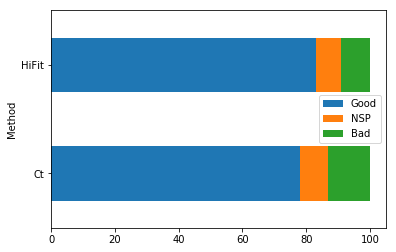

In [44]:
test = pd.DataFrame(np.array([["Ct", 78, 9, 13], ["HiFit", 83, 8, 9]]), columns=["Method", "Good", "NSP", "Bad"])
#test.astype({"Good": np.int64, "NSP": np.int64, "Bad": np.int64}).dtypes
convert_dict = {"Good": int, "NSP": int, "Bad": int}
test = test.astype(convert_dict)
test.set_index("Method", inplace=True)
test.plot.barh(stacked=True)

Method  Cluster  Good  DK  Bad
0    LRE        1    90   6    4
1    LRE        2    74  18    8
2    LRE        3    42  17   41
3  HiFit        1    92   7    1
4  HiFit        2    81   7   11
5  HiFit        3    53  21   26

/users/biocomp/bahin/anaconda3/envs/Env_conda_qPCR/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  from ipykernel import kernelapp as app


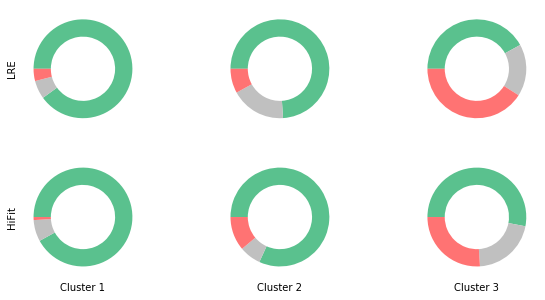

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame(np.array([["LRE", 1, 90, 6, 4], ["LRE", 2, 74, 18, 8], ["LRE", 3, 42, 17, 41],
                           ["HiFit", 1, 92, 7, 1], ["HiFit", 2, 81, 7, 11], ["HiFit", 3, 53, 21, 26]]),
                  columns=["Method", "Cluster", "Good", "DK", "Bad"])
convert_dict = {"Cluster": int, "Good": int, "DK": int, "Bad": int}
df = df.astype(convert_dict)
display(df)

fig, axes = plt.subplots(2,3, figsize=(10,5))
for ax, meth, cluster in zip(axes.flat, df.Method.unique().repeat(3), list(range(1, 4)) * 3):
    ax.pie(df.loc[(df.Method == meth) & (df.Cluster.astype("int") == cluster), ["Good", "DK", "Bad"]].T,
           colors=["#5ac18e", "#c0c0c0", "#ff7373"], radius=1, wedgeprops=dict(width=.35), startangle=180, counterclock=False)
    ax.set(xlabel="Cluster " + str(cluster), ylabel=meth, aspect="equal")
    ax.label_outer()

Theoretical_log_ratio_diff Method 6rep_test_res  Ranking %   Plate
3               intermediate     Cq       Correct  88.153846  Plate1
4               intermediate     Cq  Undetermined  11.076923  Plate1

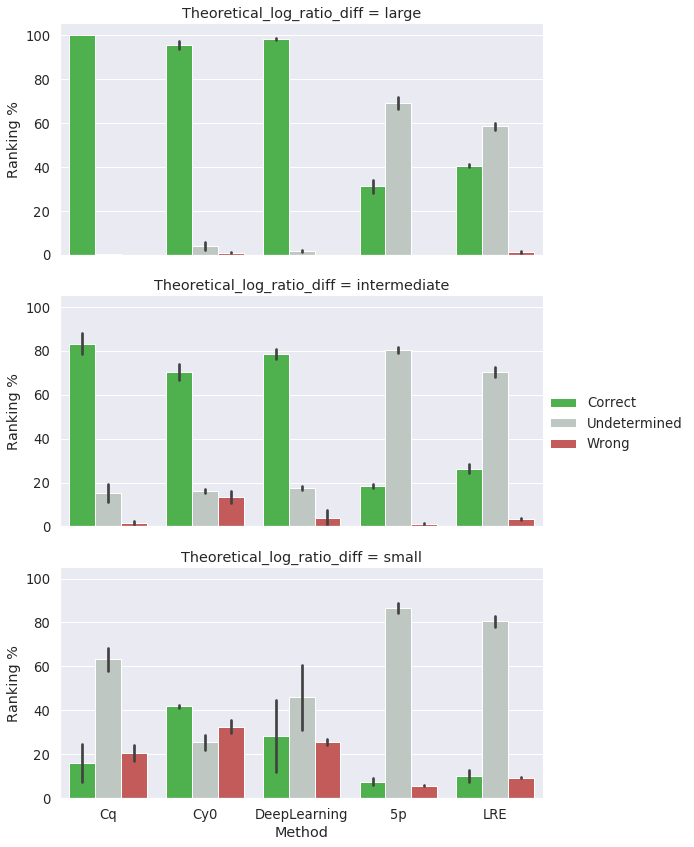

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Loading data
dir = "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/"
data_p1 = pd.read_csv(dir + "QV_plate/ttres.REF.tsv", sep="\t")
data_p1["Plate"] = "Plate1"
#display(data_p1.head(2))
data_p2 = pd.read_csv(dir + "ttres.REF.tsv", sep="\t")
data_p2["Plate"] = "Plate2"
#display(data_p2.head(2))
df = pd.concat([data_p1, data_p2])
df.columns = ["Theoretical_log_ratio_diff", "Method", "6rep_test_res", "Ranking %", "Plate"]

# Sorting the methods
df["Method"].replace({"Cq_method":0, "Cy0_method":1, "DeepLearning_method":2, "5p_method":3, "LRE_method":4}, inplace=True)
df.sort_values(by=["Method", "Theoretical_log_ratio_diff"], inplace=True)
df["Method"].replace({0:"Cq", 1:"Cy0", 2:"DeepLearning", 3:"5p", 4:"LRE"}, inplace=True)
display(df.head(2))

# Plotting
sns.set(font_scale=1.2)
g = sns.FacetGrid(df, col="Theoretical_log_ratio_diff", col_order=["large", "intermediate", "small"], col_wrap=1, height=4, aspect=2)
g = (g.map_dataframe(sns.barplot, "Method", "Ranking %", hue="6rep_test_res", hue_order=["Correct", "Undetermined", "Wrong"], palette=["#3fc13d", "#bcc9c2", "#d54a48"]).add_legend())
plt.savefig("/data/biocomp/bahin/qPCR/Diffusion/Paper/metric4.2plates.svg")

Pair_theoretical_difference Method 6rep_test_res  Percentage   Plate
3                intermediate     Cq          Good   88.153846  Plate1
4                intermediate     Cq  Undetermined   11.076923  Plate1

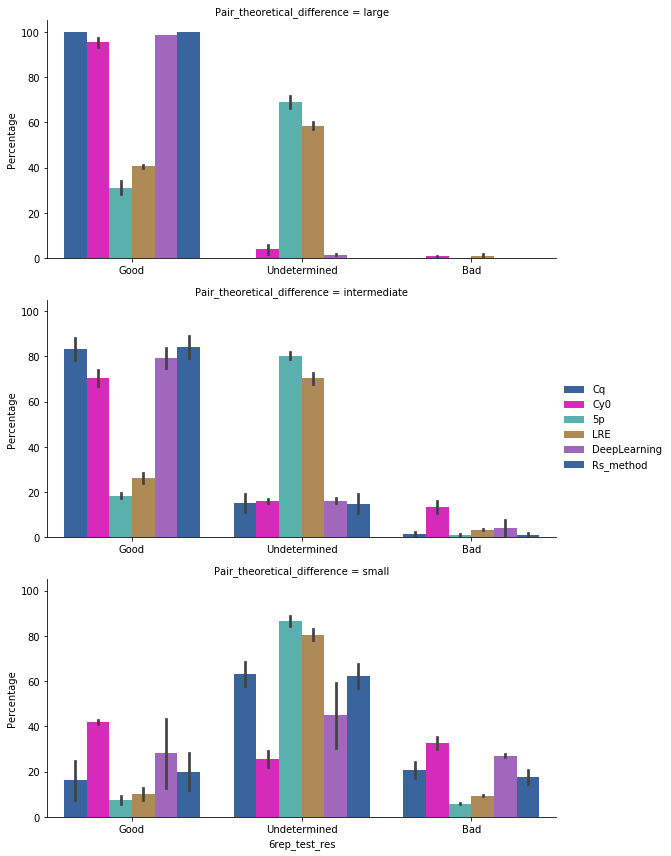

In [22]:
## Packed by status version

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Loading data
dir = "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/"
data_p1 = pd.read_csv(dir + "QV_plate/ttres.tsv", sep="\t")
data_p1["Plate"] = "Plate1"
#display(data_p1.head(2))
data_p2 = pd.read_csv(dir + "ttres.tsv", sep="\t")
data_p2["Plate"] = "Plate2"
#display(data_p2.head(2))
df = pd.concat([data_p1, data_p2])
df.columns = ["Pair_theoretical_difference", "Method", "6rep_test_res", "Percentage", "Plate"]

# Sorting the methods
df["Method"].replace({"Cq_method":0, "Cy0_method":1, "5p_method":2, "LRE_method":3, "DeepLearning_method":4}, inplace=True)
df.sort_values(by=["Method", "Pair_theoretical_difference"], inplace=True)
df["Method"].replace({0:"Cq", 1:"Cy0", 2:"5p", 3:"LRE", 4:"DeepLearning"}, inplace=True)
display(df.head(2))

# Plotting
g = sns.FacetGrid(df, col="Pair_theoretical_difference", sharex=False, col_order=["large", "intermediate", "small"], col_wrap=1, height=4, aspect=2)
g = (g.map_dataframe(sns.barplot, "6rep_test_res", "Percentage", order=["Good", "Undetermined", "Bad"], hue="Method", palette=meth_pal).add_legend())

     Plate Method        Status Cluster  Value
0   plate1     M1          Good   Small     87
1   plate1     M1  Undetermined   Small     83
2   plate1     M2          Good   Small     81
3   plate1     M2  Undetermined   Small     87
4   plate2     M1          Good   Small     86
5   plate2     M1  Undetermined   Small     85
6   plate2     M2          Good   Small     88
7   plate2     M2  Undetermined   Small     54
8   plate1     M1          Good   Large     74
9   plate1     M1  Undetermined   Large     59
10  plate1     M2          Good   Large     89
11  plate1     M2  Undetermined   Large     99
12  plate2     M1          Good   Large     56
13  plate2     M1  Undetermined   Large     81
14  plate2     M2          Good   Large     78
15  plate2     M2  Undetermined   Large     72


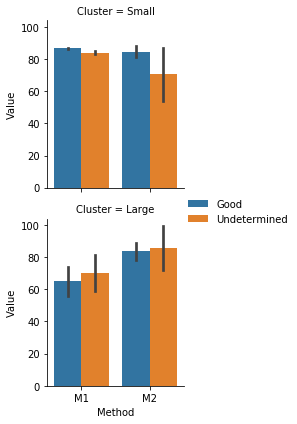

In [112]:
df = pd.DataFrame(np.array([["plate1", "M1", "Good", "Small", 87], ["plate1", "M1", "Undetermined", "Small", 83],
                            ["plate1", "M2", "Good", "Small", 81], ["plate1", "M2", "Undetermined", "Small", 87],
                            ["plate2", "M1", "Good", "Small", 86], ["plate2", "M1", "Undetermined", "Small", 85],
                            ["plate2", "M2", "Good", "Small", 88], ["plate2", "M2", "Undetermined", "Small", 54],
                            ["plate1", "M1", "Good", "Large", 74], ["plate1", "M1", "Undetermined", "Large", 59],
                            ["plate1", "M2", "Good", "Large", 89], ["plate1", "M2", "Undetermined", "Large", 99],
                            ["plate2", "M1", "Good", "Large", 56], ["plate2", "M1", "Undetermined", "Large", 81],
                            ["plate2", "M2", "Good", "Large", 78], ["plate2", "M2", "Undetermined", "Large", 72]
                           ]), columns=["Plate", "Method", "Status", "Cluster", "Value"])
df["Value"] = pd.to_numeric(df["Value"])
print(df)
g = sns.FacetGrid(df, col="Cluster", col_wrap=1)
g = (g.map_dataframe(sns.barplot, "Method", "Value", hue="Status").add_legend())

<h1>Merging fitting results</h1>

In [23]:
## Merging several fitting files (research plate)
import pandas as pd
import string

# Loading data
dir = "/data/biocomp/bahin/qPCR/Research_plate/Fixed_keys/QV_plate/"
file1 = pd.read_csv(dir + "final_data.Gompertz.bump_corrected.REF.tsv", sep="\t", index_col=0)
file2 = pd.read_csv(dir + "final_data.Richards.bump_corrected.REF.tsv", sep="\t", index_col=0)
file3 = pd.read_csv(dir + "final_data.logistic5p.bump_corrected.REF.tsv", sep="\t", index_col=0)
#display(file1.head(2))
#display(file2.head(2))
data = file1.join(file2.loc[:, ["P_" + letter + "_final_" + "Richards" for letter in list(string.ascii_lowercase)[0:5]]])
data = data.join(file3.loc[:, ["P_" + letter + "_final_" + "logistic5p" for letter in list(string.ascii_lowercase)[0:5]]])
data.to_csv(dir + "final_data.total.tsv", sep="\t")